In [1]:
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats

import multiprocessing

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMClassifier, plot_importance


# 데이터 다운받기

In [ ]:

import pandas_datareader as web
import pandas_datareader.naver as web_naver

import pandas as pd
import datetime
import nasdaqdatalink
import yfinance as yf

# TIGER ETF와 KODEX ETF 자료 다운로드
df_tiger=web_naver.NaverDailyReader(symbols='137610', start='20110111',adjust_price=True)
df_kodex=web_naver.NaverDailyReader(symbols='271060', start='20170613',adjust_price=True)

# TIGER ETF와 KODEX ETF에 종가 등락 라벨링 해주기
df_tiger['Close_1']=df_tiger['Close'].shift(-1)
df_tiger['Change']=np.log(df_tiger['Close'].astype(float)/df_tiger['Close_1'].astype(float))
df_tiger['label']=np.where(np.sign(df_tiger['Change'])>=0,1,-1)

df_kodex['Close_1']=df_kodex['Close'].shift(-1)
df_kodex['Change']=np.log(df_kodex['Close'].astype(float)/df_kodex['Close_1'].astype(float))
df_kodex['label']=np.where(np.sign(df_kodex['Change'])>=0,1,-1)

# 익영업일의 정보가 없는 마지막 row drop
df_kodex.dropna(inplace=True)
df_tiger.dropna(inplace=True)

# sp500 자료와 sp500 선물 자료 다운로드
sp500 = web.DataReader('^GSPC','yahoo',start='1/1/2011', end='21/1/2022')
sp500_f = web.DataReader('ES=F','yahoo',start='1/1/2011', end='21/1/2022')



# 데이터 불러오기

In [6]:
# Datetime으로 형식 지정하는 함수 정의
def index_to_date(df):
    df['Date']=pd.to_datetime(df['Date'])
    return df

In [41]:
DATA_PATH='C:/'
# 코덱스 종가, 볼륨, 라벨 자료
kodex = pd.read_csv(DATA_PATH+'df_kodex.csv')
kodex = index_to_date(kodex)
kodex = kodex.set_index('Date')
kodex = kodex[['Close','Volume','label']]
kodex.columns = ['kodex_adjclose','kodex_volume','kodex_label']

# 타이거 종가, 볼륨, 라벨 자료
tiger = pd.read_csv(DATA_PATH+'df_tiger.csv')
tiger = index_to_date(tiger)
tiger = tiger.set_index('Date')
tiger = tiger[['Close','Volume','label']]
tiger.columns = ['tiger_adjclose','tiger_volume','tiger_label']

# sp500 수정종가, 볼륨 자료
sp500 = pd.read_csv(DATA_PATH+'sp500.csv')
sp500 = index_to_date(sp500)
sp500 = sp500.set_index('Date')
sp500 = sp500[['Adj Close','Volume']]
sp500.columns = ['sp500_adjclose','sp500_volume']

# sp500_f 수정종가, 볼륨 자료
sp500_f = pd.read_csv(DATA_PATH+'sp500_futures.csv')
sp500_f = index_to_date(sp500_f)
sp500_f = sp500_f.set_index('Date')
sp500_f = sp500_f[['Adj Close','Volume']]
sp500_f.columns = ['sp500_f_adjclose','sp500_f_volume']

# real_gdp 발표/예측/이전 성장률 자료
real_gdp = pd.read_csv(DATA_PATH+'real_gdp_announce.csv')
real_gdp.columns = ['Date','actual_growth','pred_growth','prev_growth']
real_gdp = index_to_date(real_gdp)
real_gdp = real_gdp.set_index('Date')

# grains_f 설탕/밀(ke)/밀(zw)/대두/옥수수 종가 및 볼륨 자료
grains_f = pd.read_csv(DATA_PATH+'곡물선물가격.csv')
grains_f = grains_f[grains_f['Date']>='2011-01-01'] # 필요 없는 날짜 제거
grains_f = index_to_date(grains_f)
grains_f = grains_f.set_index('Date')

# oil_ethanol_tbond_f 원유/에탄올/10년만기 미국 국채 선물 종가 및 볼륨 자료
oil_ethanol_tbond_f = pd.read_csv(DATA_PATH+'원유에탄올국채선물.csv')
oil_ethanol_tbond_f = index_to_date(oil_ethanol_tbond_f)
oil_ethanol_tbond_f = oil_ethanol_tbond_f.set_index('Date')

# other_etf 인베스코/Tieucrium옥수수/대두/밀/VanEck ETF 수정종가 및 볼륨 자료
other_etf = pd.read_csv(DATA_PATH+'외국원자재선물etf.csv')
other_etf = index_to_date(other_etf)
other_etf = other_etf.set_index('Date')

# kodex_dollar_iron 코덱스달러선물/코덱스철강선물 etf 종가 및 볼륨 자료
kodex_dollar_iron = pd.read_csv(DATA_PATH+'kodex_dollar_iron.csv')
kodex_dollar_iron = index_to_date(kodex_dollar_iron)
kodex_dollar_iron = kodex_dollar_iron.set_index('Date')

# kosef_usd_f KOSEF 달러선물 종가 및 볼륨 자료
kosef_usd_f = pd.read_csv(DATA_PATH+'kosef_usd_f.csv')
kosef_usd_f = kosef_usd_f[['Date','Close','Volume']]
kosef_usd_f.columns = ['Date','usd_f_close','usd_f_volume']
kosef_usd_f = index_to_date(kosef_usd_f)
kosef_usd_f = kosef_usd_f.set_index('Date')

# tiger_metal_oil 타이거금속선물/원유선물 종가 및 볼륨 자료
tiger_metal_oil = pd.read_csv(DATA_PATH+'tiger_metal_oil.csv')
tiger_metal_oil = index_to_date(tiger_metal_oil)
tiger_metal_oil = tiger_metal_oil.set_index('Date')

# gsci SP500 GSCI Grains select index 종가 자료
gsci = pd.read_csv(DATA_PATH+'GSCI.csv').iloc[:,:2]
gsci.columns = ['Date','gsci_adjclose']
gsci = index_to_date(gsci)
gsci = gsci.set_index('Date')

In [42]:
# 컬럼명 및 데이터타입 확인
#kodex.info()
#tiger.info()
#sp500.info()
#sp500_f.info()
#real_gdp.info()
#grains_f.info()
#oil_ethanol_tbond_f.info()
#other_etf.info()
#kodex_dollar_iron.info()
#tiger_dollar.info()
#tiger_metal_oil.info()
#gsci.info()
#kosef_usd_f.info()

## 각 데이터프레임 결측치 확인 및 처리

In [43]:
for df in [kosef_usd_f,kodex,tiger,sp500,sp500_f,real_gdp,grains_f,oil_ethanol_tbond_f,other_etf,kodex_dollar_iron,tiger_metal_oil,gsci]:
    print(df.isna().sum())

usd_f_close     0
usd_f_volume    0
dtype: int64
kodex_adjclose    0
kodex_volume      0
kodex_label       0
dtype: int64
tiger_adjclose    0
tiger_volume      0
tiger_label       0
dtype: int64
sp500_adjclose    0
sp500_volume      0
dtype: int64
sp500_f_adjclose    0
sp500_f_volume      0
dtype: int64
actual_growth    0
pred_growth      0
prev_growth      0
dtype: int64
sugar_close        0
sugar_volume       0
wheat_ke_close     0
wheat_ke_volume    0
wheat_zw_close     0
wheat_zw_volume    0
soybean_close      0
soybean_volume     0
corn_close         2
corn_volume        2
dtype: int64
crude_oil_adjclose      0
crude_oil_volume        0
ethanol_close           3
ethanol_volume        368
tbond_fut_adjclose      2
tbond_fut_volume        2
dtype: int64
DBA_adjclose       0
DBA_volume         0
CORN_adjclose      0
CORN_volume        0
SOYB_adjclose    184
SOYB_volume      184
WEAT_adjclose    181
WEAT_volume      181
MOO_adjclose       0
MOO_volume         0
dtype: int64
kodex_doll

거래량의 경우 결측치로 처리된 날은 거래량이 미미한 것으로 보고 0을 넣어주었고, 종가의 경우에는 fillna() 함수의 `method='ffill'` 옵션 이용해 전날 종가로 대체했다. 이러한 처리가 확실하지 않은 가정에 의존하기는 하나, 대부분의 데이터프레임에서 결측치는 2~3개에 불과하고 에탄올 거래량만 368개의 결측치를 보이기에 모델의 성능에 큰 영향을 미치지 않을 것으로 판단했다.

그러나 other_etf 데이터프레임의 SOYB와 WEAT 선물지수의 종가 및 거래량 자료는 2011-09-19부터 존재하기에 결측치가 181개 이상이었다. 타이거 지수 예측 모델에서 해당 피처를 사용하게 될 경우, 학습데이터는 첫 8달 가량의 데이터를 제거한 후 2011-09-19일 자료부터 사용하겠다.

In [44]:
grains_f = grains_f.fillna(method='ffill')
grains_f.isna().sum()

sugar_close        0
sugar_volume       0
wheat_ke_close     0
wheat_ke_volume    0
wheat_zw_close     0
wheat_zw_volume    0
soybean_close      0
soybean_volume     0
corn_close         0
corn_volume        0
dtype: int64

In [45]:
oil_ethanol_tbond_f['ethanol_volume'] = oil_ethanol_tbond_f['ethanol_volume'].fillna(value=0)
oil_ethanol_tbond_f = oil_ethanol_tbond_f.fillna(method='ffill')
oil_ethanol_tbond_f.isna().sum()

crude_oil_adjclose    0
crude_oil_volume      0
ethanol_close         0
ethanol_volume        0
tbond_fut_adjclose    0
tbond_fut_volume      0
dtype: int64

In [46]:
cond = pd.to_datetime(other_etf.index)>='2011-09-19' # 아예 자료가 없는 2011-09-19 이전은 그대로 두고, 학습 전에 drop시킨다.
other_etf[cond]['SOYB_volume'] = other_etf[cond]['SOYB_volume'].fillna(value=0) # 2011-09-19 이후의 결측치 처리
other_etf[cond]['WEAT_volume'] = other_etf[cond]['WEAT_volume'].fillna(value=0)
other_etf[cond] = other_etf[cond].fillna(method='ffill')
print(other_etf[cond].isna().sum())
print(other_etf.isna().sum())

DBA_adjclose     0
DBA_volume       0
CORN_adjclose    0
CORN_volume      0
SOYB_adjclose    0
SOYB_volume      0
WEAT_adjclose    0
WEAT_volume      0
MOO_adjclose     0
MOO_volume       0
dtype: int64
DBA_adjclose       0
DBA_volume         0
CORN_adjclose      0
CORN_volume        0
SOYB_adjclose    180
SOYB_volume      180
WEAT_adjclose    180
WEAT_volume      180
MOO_adjclose       0
MOO_volume         0
dtype: int64


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_14936/2303983350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_etf[cond]['SOYB_volume'] = other_etf[cond]['SOYB_volume'].fillna(value=0) # 2011-09-19 이후의 결측치 처리
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_14936/2303983350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_etf[cond]['WEAT_volume'] = other_etf[cond]['WEAT_volume'].fillna(value=0)


이제 결측치를 모두 처리했으므로 모델 학습을 위해 데이터를 합치자.

# 데이터 병합

## 1. 타이거 지수 예측 모델을 위한 데이터프레임

사용하는 데이터프레임 :
- tiger
- sp500
- sp500_f
- real_gdp
- grains_f
- oil_ethanol_tbond_f
- other_etf
- tiger_metal_oil
- kosef_usd_f # tiger 달러선물레버리지는 2016년 말에 상장했기 때문에 대체 자료 사용

In [47]:
df_list = [sp500, sp500_f, real_gdp, grains_f, oil_ethanol_tbond_f, other_etf, tiger_metal_oil, kosef_usd_f]
df_mod1 = tiger

for df in df_list:
    df_mod1 = df_mod1.join(df)

df_mod1

,tiger_adjclose,tiger_volume,tiger_label,sp500_adjclose,sp500_volume,sp500_f_adjclose,sp500_f_volume,actual_growth,pred_growth,prev_growth,...,WEAT_adjclose,WEAT_volume,MOO_adjclose,MOO_volume,tiger_metal_close,tiger_metal_volume,tiger_oil_close,tiger_oil_volume,usd_f_close,usd_f_volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-11,10065,221076,-1,1274.479980,4.050750e+09,1270.50,1662412.0,2.6,2.6,2.6,...,NaN,NaN,45.009132,1312200.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-12,10005,120538,1,1285.959961,4.226940e+09,1283.50,1604117.0,2.6,2.6,2.6,...,NaN,NaN,46.220470,2162500.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-13,10200,75912,1,1283.760010,4.310840e+09,1281.25,1671242.0,2.6,2.6,2.6,...,NaN,NaN,46.344082,3373400.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-14,10200,102051,1,1293.239990,4.661590e+09,1289.50,1631162.0,2.6,2.6,2.6,...,NaN,NaN,46.558331,1801300.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-17,10450,182345,-1,NaN,NaN,NaN,NaN,2.6,2.6,2.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,7310,14183,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7990.0,12294.0,4280.0,551913.0,12535.0,13502.0
2022-02-21,7360,18761,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-22,7470,50805,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


결측치가 얼마나 생겼는지 확인해보자.

In [48]:
df_mod1.isna().sum()

tiger_adjclose          0
tiger_volume            0
tiger_label             0
sp500_adjclose        105
sp500_volume          105
sp500_f_adjclose      106
sp500_f_volume        106
actual_growth          17
pred_growth            17
prev_growth            17
sugar_close            91
sugar_volume           91
wheat_ke_close         91
wheat_ke_volume        91
wheat_zw_close         91
wheat_zw_volume        91
soybean_close          91
soybean_volume         91
corn_close             91
corn_volume            91
crude_oil_adjclose     90
crude_oil_volume       90
ethanol_close          90
ethanol_volume         90
tbond_fut_adjclose     90
tbond_fut_volume       90
DBA_adjclose           89
DBA_volume             89
CORN_adjclose          89
CORN_volume            89
SOYB_adjclose         252
SOYB_volume           252
WEAT_adjclose         252
WEAT_volume           252
MOO_adjclose           89
MOO_volume             89
tiger_metal_close      63
tiger_metal_volume     63
tiger_oil_cl

In [49]:
df_mod1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2741 entries, 2011-01-11 to 2022-02-24
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tiger_adjclose      2741 non-null   int64  
 1   tiger_volume        2741 non-null   int64  
 2   tiger_label         2741 non-null   int64  
 3   sp500_adjclose      2636 non-null   float64
 4   sp500_volume        2636 non-null   float64
 5   sp500_f_adjclose    2635 non-null   float64
 6   sp500_f_volume      2635 non-null   float64
 7   actual_growth       2724 non-null   float64
 8   pred_growth         2724 non-null   float64
 9   prev_growth         2724 non-null   float64
 10  sugar_close         2650 non-null   float64
 11  sugar_volume        2650 non-null   float64
 12  wheat_ke_close      2650 non-null   float64
 13  wheat_ke_volume     2650 non-null   float64
 14  wheat_zw_close      2650 non-null   float64
 15  wheat_zw_volume     2650 non-null   f

결측치를 포함한 행을 drop시키자.

앞서 언급했던 SOYB, WEAT와 같은 commodity futures etf들의 상장일 차이로 인해 180일의 데이터(2011-01-11~2011-09-18까지의 영업일에 해당하는 데이터)가 drop되었고, 미장과 한국장의 영업일 차이나 각종 선물상품들의 거래일 차이 등으로 인해 90일의 데이터가 drop되면서 총 270일의 데이터가 drop되었다.

In [50]:
df_mod1 = df_mod1.dropna()
df_mod1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2471 entries, 2011-09-19 to 2022-01-21
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tiger_adjclose      2471 non-null   int64  
 1   tiger_volume        2471 non-null   int64  
 2   tiger_label         2471 non-null   int64  
 3   sp500_adjclose      2471 non-null   float64
 4   sp500_volume        2471 non-null   float64
 5   sp500_f_adjclose    2471 non-null   float64
 6   sp500_f_volume      2471 non-null   float64
 7   actual_growth       2471 non-null   float64
 8   pred_growth         2471 non-null   float64
 9   prev_growth         2471 non-null   float64
 10  sugar_close         2471 non-null   float64
 11  sugar_volume        2471 non-null   float64
 12  wheat_ke_close      2471 non-null   float64
 13  wheat_ke_volume     2471 non-null   float64
 14  wheat_zw_close      2471 non-null   float64
 15  wheat_zw_volume     2471 non-null   f

## 2. 코덱스 지수 예측 모델을 위한 데이터프레임

사용하는 데이터프레임 :
- kodex
- sp500
- sp500_f
- real_gdp
- grains_f
- oil_ethanol_tbond_f
- other_etf
- kodex_dollar_iron
- gsci

In [51]:
df_list = [sp500, sp500_f, real_gdp, grains_f, oil_ethanol_tbond_f, other_etf, kodex_dollar_iron, gsci]
df_mod2 = kodex

for df in df_list:
    df_mod2 = df_mod2.join(df)

df_mod2

,kodex_adjclose,kodex_volume,kodex_label,sp500_adjclose,sp500_volume,sp500_f_adjclose,sp500_f_volume,actual_growth,pred_growth,prev_growth,...,SOYB_volume,WEAT_adjclose,WEAT_volume,MOO_adjclose,MOO_volume,kodex_dollar_close,kodex_dollar_volume,kodex_metal_close,kodex_metal_volume,gsci_adjclose
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-13,10060,10010,1,2440.350098,3.275500e+09,2440.00,1028985.0,1.4,1.2,1.2,...,17700.0,6.99,74400.0,52.382080,187000.0,9425.0,133661.0,9211.0,5686.0,NaN
2017-06-14,10135,1106,-1,2437.919922,3.555590e+09,2437.25,684544.0,1.4,1.2,1.2,...,4900.0,7.00,165200.0,52.307316,46300.0,9390.0,113434.0,9168.0,29257.0,NaN
2017-06-15,10065,432,1,2432.459961,3.353050e+09,2434.25,470700.0,1.4,1.2,1.2,...,10000.0,7.15,201000.0,51.998913,27400.0,9390.0,126559.0,9029.0,26571.0,NaN
2017-06-16,10200,6212,1,2433.149902,5.284720e+09,2433.75,1336684.0,1.4,1.2,1.2,...,21300.0,7.30,374400.0,52.288628,60300.0,9490.0,123699.0,9029.0,2755.0,NaN
2017-06-19,10250,4031,-1,2453.459961,3.264700e+09,2447.50,1223334.0,1.4,1.2,1.2,...,8700.0,7.25,291500.0,52.419464,54300.0,9480.0,137298.0,8940.0,2943.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,12395,7323,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10565.0,60243.0,8580.0,233168.0,NaN
2022-02-21,12600,17961,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-22,12760,43388,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


결측치가 얼마나 생겼는지 확인해보자.

In [52]:
df_mod2.isna().sum()

kodex_adjclose          0
kodex_volume            0
kodex_label             0
sp500_adjclose         55
sp500_volume           55
sp500_f_adjclose       54
sp500_f_volume         54
actual_growth          17
pred_growth            17
prev_growth            17
sugar_close            39
sugar_volume           39
wheat_ke_close         39
wheat_ke_volume        39
wheat_zw_close         39
wheat_zw_volume        39
soybean_close          39
soybean_volume         39
corn_close             39
corn_volume            39
crude_oil_adjclose     38
crude_oil_volume       38
ethanol_close          38
ethanol_volume         38
tbond_fut_adjclose     38
tbond_fut_volume       38
DBA_adjclose           39
DBA_volume             39
CORN_adjclose          39
CORN_volume            39
SOYB_adjclose          39
SOYB_volume            39
WEAT_adjclose          39
WEAT_volume            39
MOO_adjclose           39
MOO_volume             39
kodex_dollar_close      4
kodex_dollar_volume     4
kodex_metal_

In [53]:
df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1157 entries, 2017-06-13 to 2022-02-24
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kodex_adjclose       1157 non-null   int64  
 1   kodex_volume         1157 non-null   int64  
 2   kodex_label          1157 non-null   int64  
 3   sp500_adjclose       1102 non-null   float64
 4   sp500_volume         1102 non-null   float64
 5   sp500_f_adjclose     1103 non-null   float64
 6   sp500_f_volume       1103 non-null   float64
 7   actual_growth        1140 non-null   float64
 8   pred_growth          1140 non-null   float64
 9   prev_growth          1140 non-null   float64
 10  sugar_close          1118 non-null   float64
 11  sugar_volume         1118 non-null   float64
 12  wheat_ke_close       1118 non-null   float64
 13  wheat_ke_volume      1118 non-null   float64
 14  wheat_zw_close       1118 non-null   float64
 15  wheat_zw_volume     

마찬가지로 결측치를 포함한 행을 drop시키자.

83일의 데이터가 drop되었다.

In [54]:
df_mod2 = df_mod2.dropna()
df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1074 entries, 2017-07-24 to 2022-01-21
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kodex_adjclose       1074 non-null   int64  
 1   kodex_volume         1074 non-null   int64  
 2   kodex_label          1074 non-null   int64  
 3   sp500_adjclose       1074 non-null   float64
 4   sp500_volume         1074 non-null   float64
 5   sp500_f_adjclose     1074 non-null   float64
 6   sp500_f_volume       1074 non-null   float64
 7   actual_growth        1074 non-null   float64
 8   pred_growth          1074 non-null   float64
 9   prev_growth          1074 non-null   float64
 10  sugar_close          1074 non-null   float64
 11  sugar_volume         1074 non-null   float64
 12  wheat_ke_close       1074 non-null   float64
 13  wheat_ke_volume      1074 non-null   float64
 14  wheat_zw_close       1074 non-null   float64
 15  wheat_zw_volume     

# 데이터 전처리

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [56]:
# tiger 등락은 거의 유사
df_mod1['tiger_label'].value_counts()

 1    1236
-1    1235
Name: tiger_label, dtype: int64

In [57]:
# kodex 등락은 상승이 조금 더 많음
df_mod2['kodex_label'].value_counts()

-1    551
 1    523
Name: kodex_label, dtype: int64

<AxesSubplot:xlabel='Date', ylabel='tiger_close'>

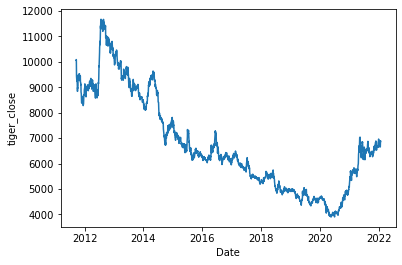

In [25]:
# tiger 주가는 하락 후 상승 중
sns.lineplot(x=df_mod1.index,y=df_mod1['tiger_close'])

<AxesSubplot:xlabel='Date', ylabel='kodex_close'>

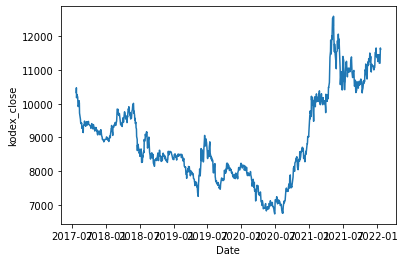

In [26]:
# kodex 주가는 하락 후 상승 중. 다만 이 때 2017년 자료부터 있음을 고려해보면 큰 차이는 없음. 둘 다 같은 지수를 추종하기 때문.
sns.lineplot(x=df_mod2.index,y=df_mod2['kodex_close'])

이상치도 확인해보자.

In [58]:
# lineplot 그리는 함수 정의
def show_plot(df, columns):
    for col in columns:
        plt.figure()
        sns.lineplot(x=df.index,y=df[col])

In [59]:
# 이상치를 확인할 컬럼명 리스트 만들기
df1_cols = [x for x in df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')

df2_cols = [x for x in df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('prev_growth')

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_14936/2599486245.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


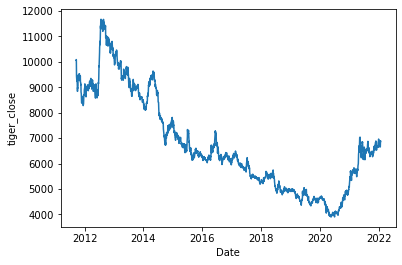

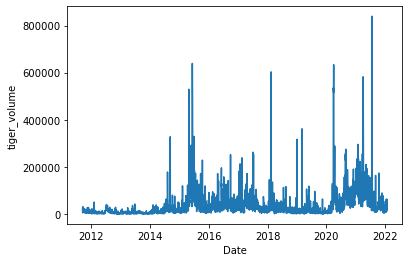

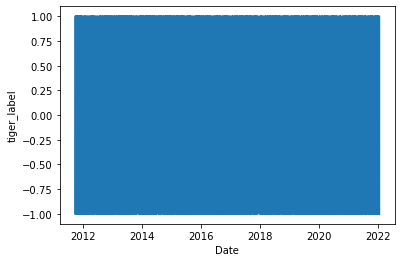

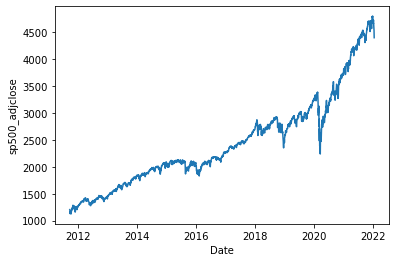

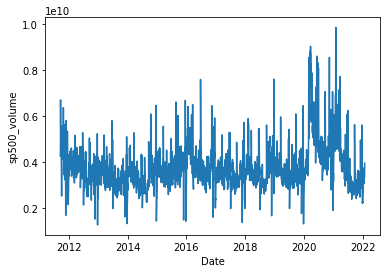

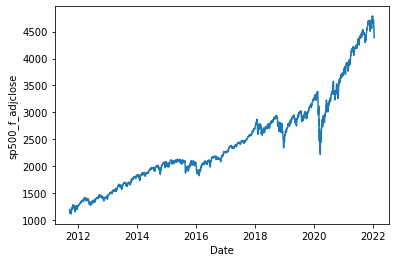

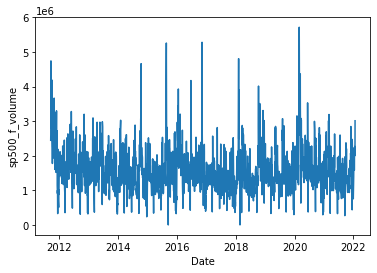

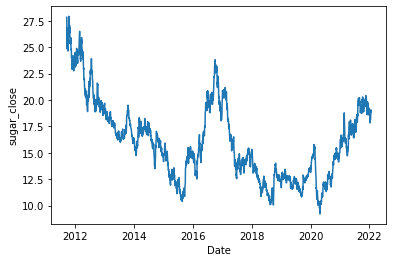

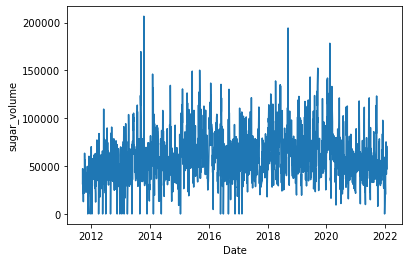

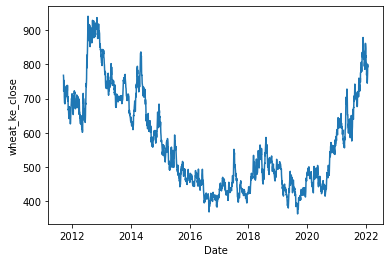

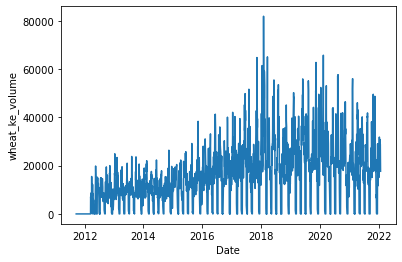

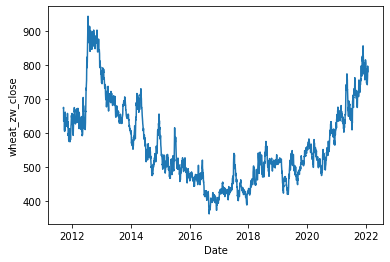

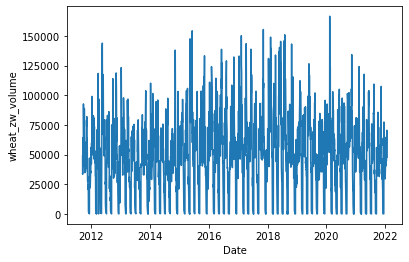

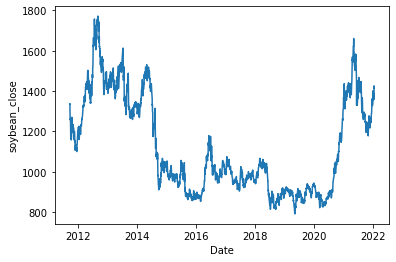

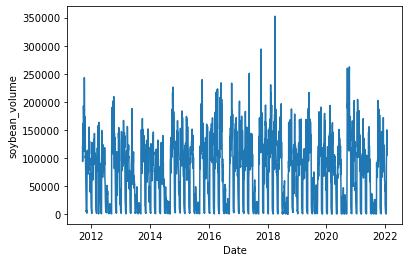

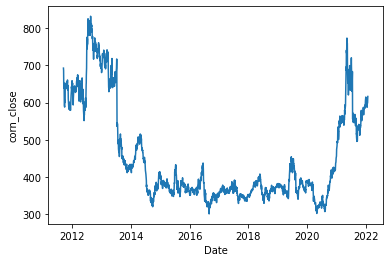

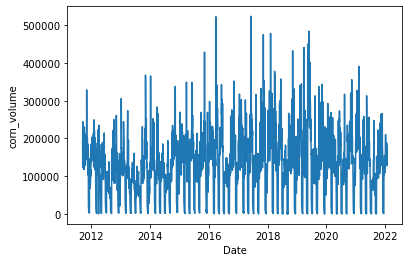

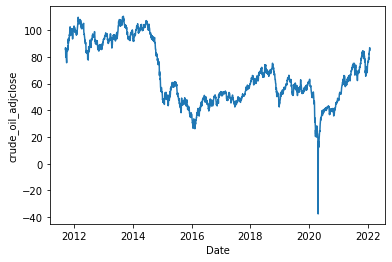

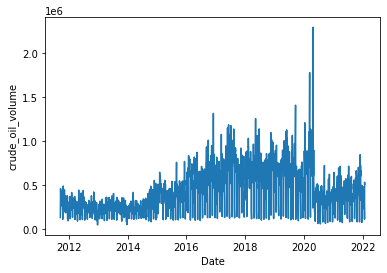

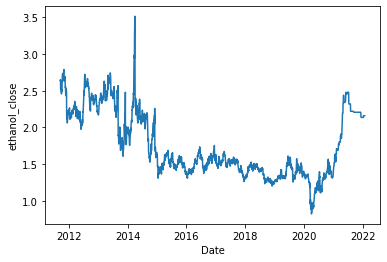

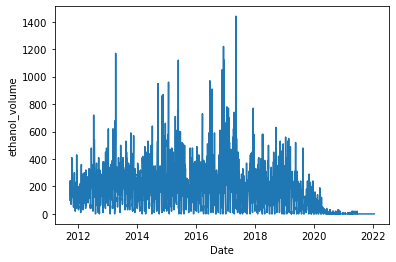

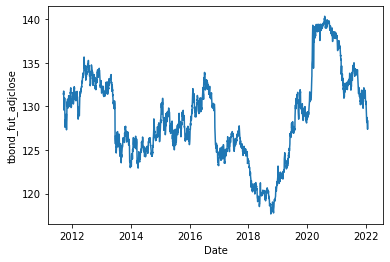

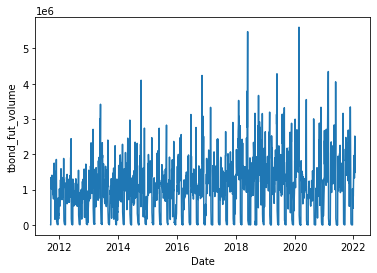

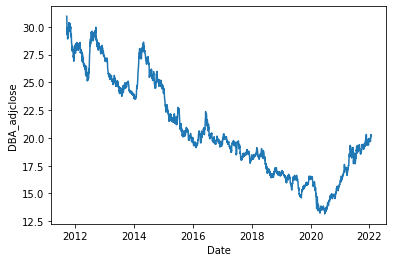

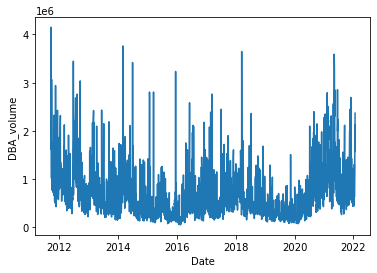

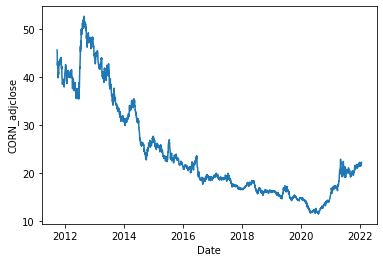

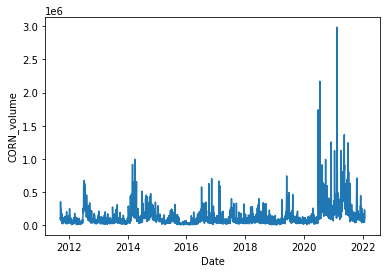

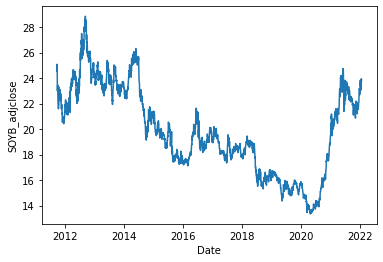

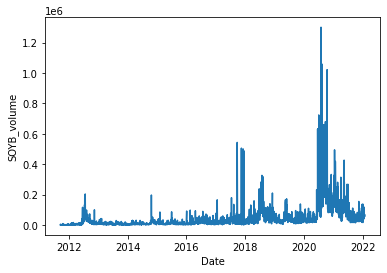

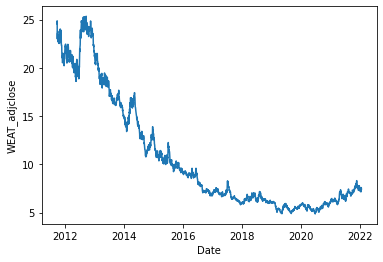

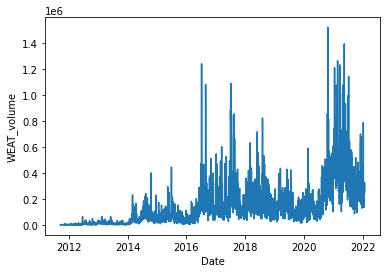

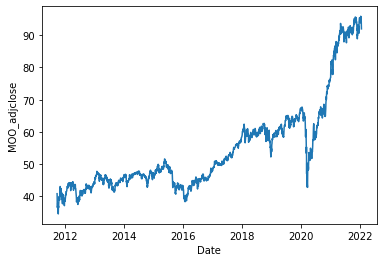

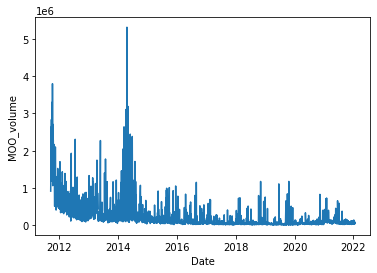

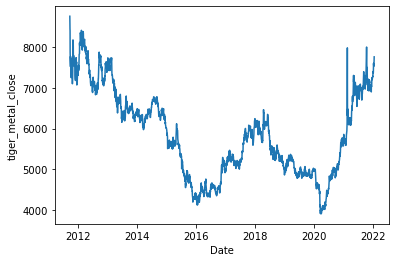

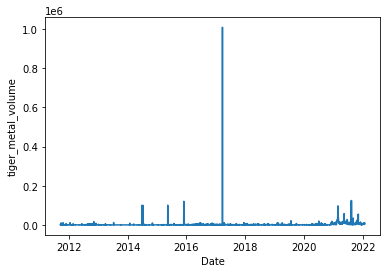

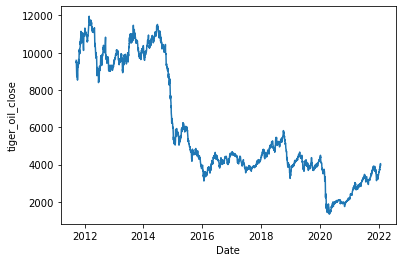

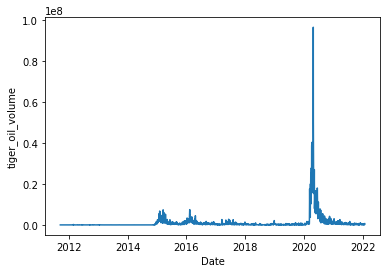

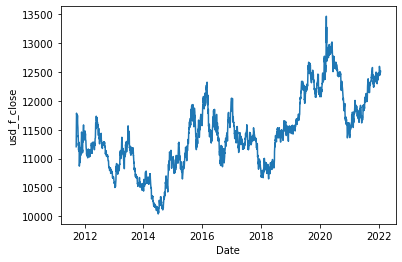

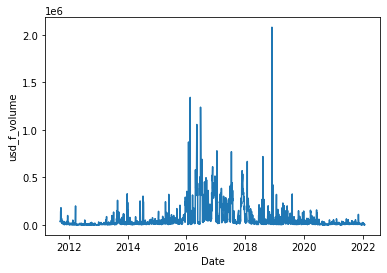

In [29]:
show_plot(df_mod1,df1_cols)

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_14936/2599486245.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


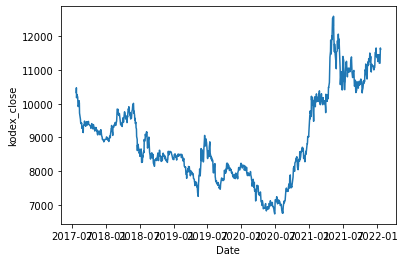

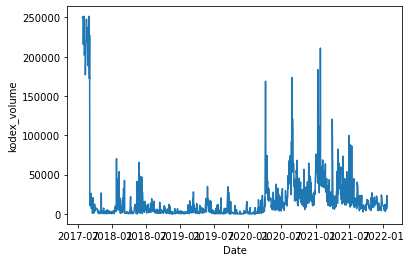

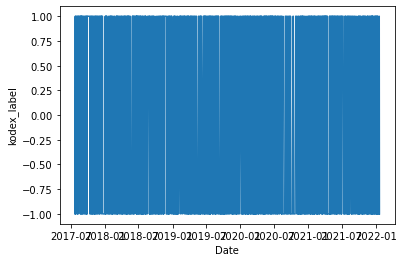

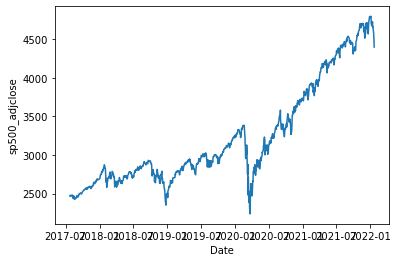

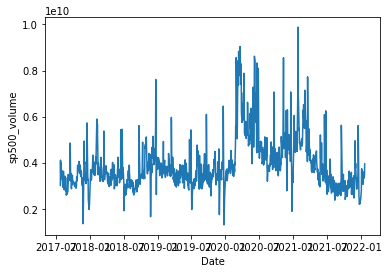

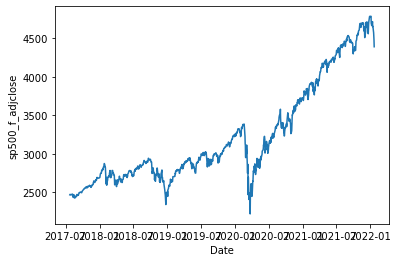

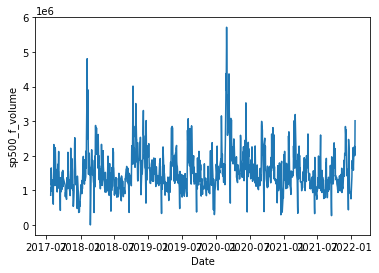

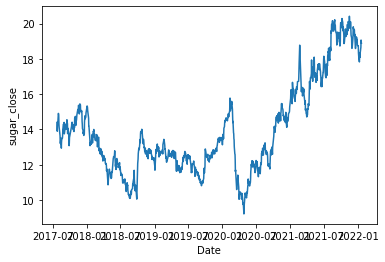

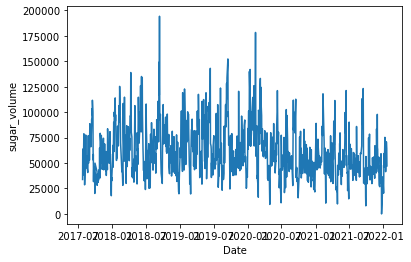

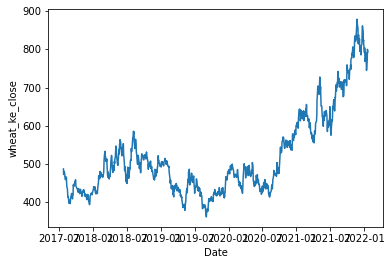

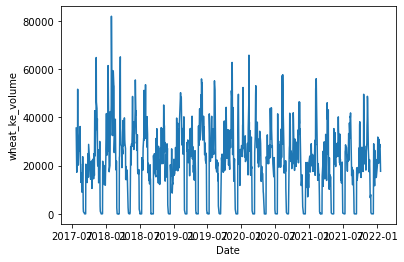

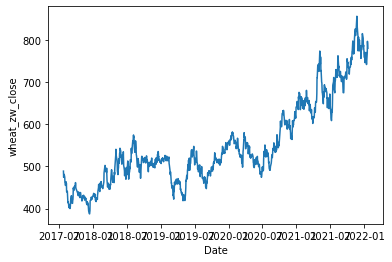

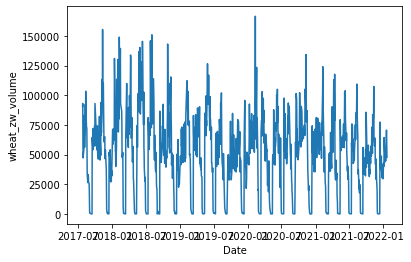

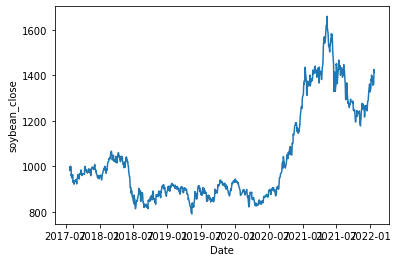

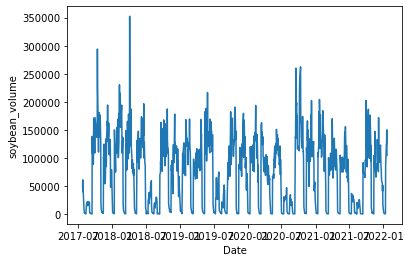

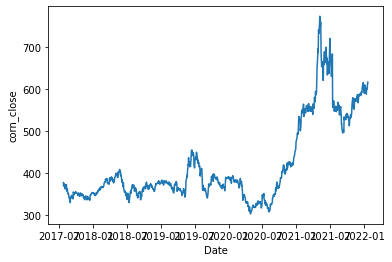

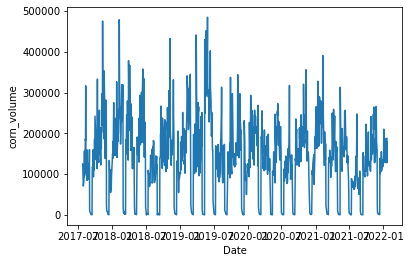

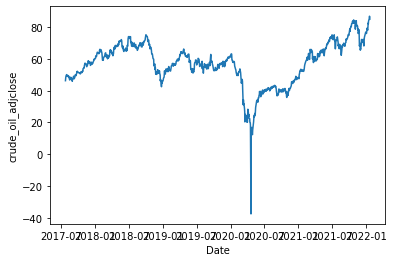

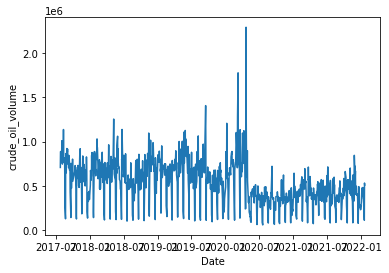

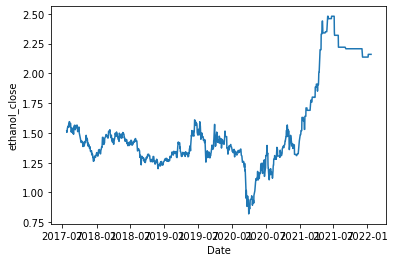

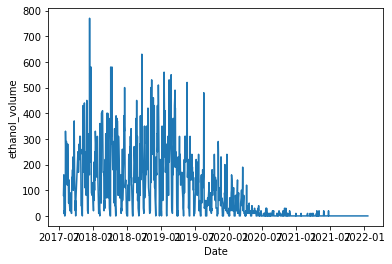

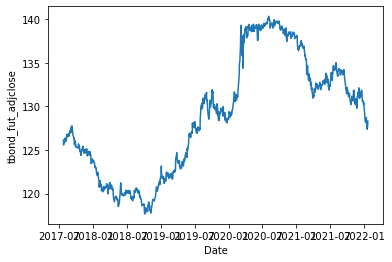

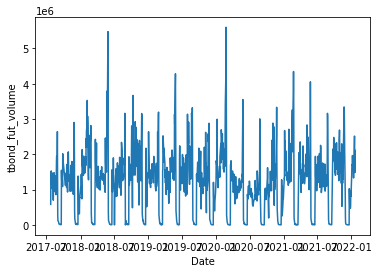

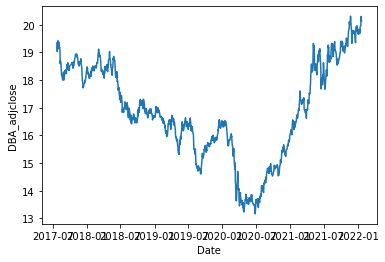

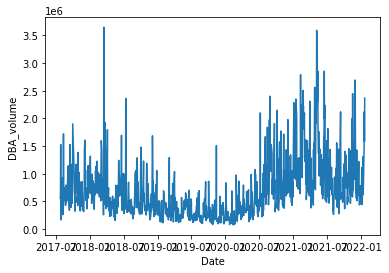

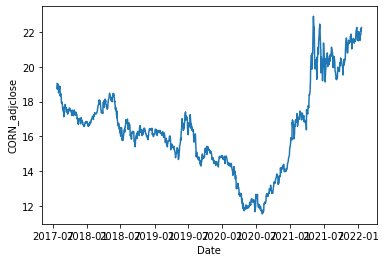

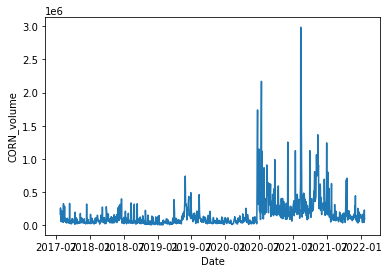

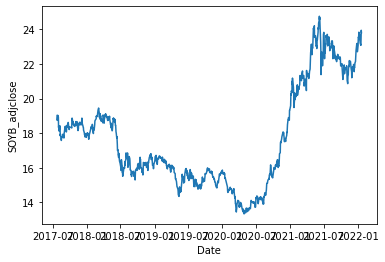

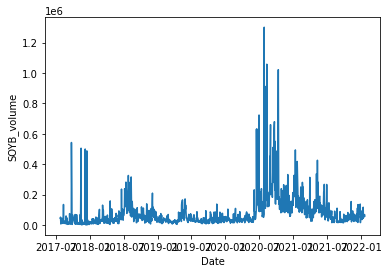

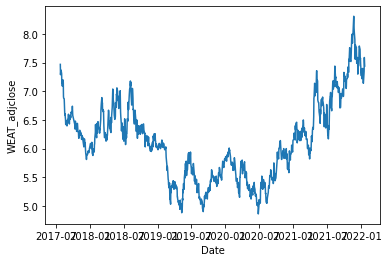

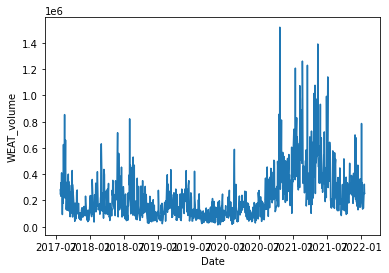

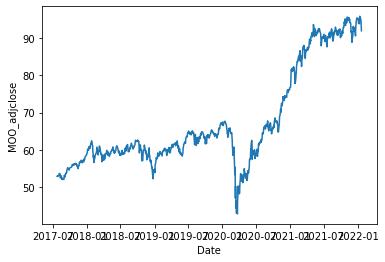

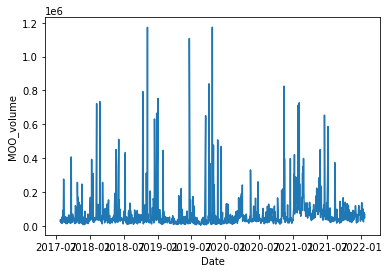

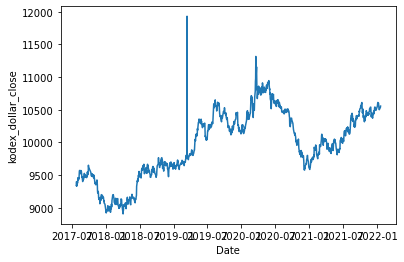

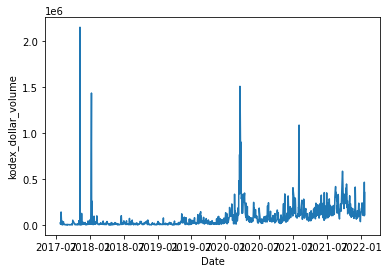

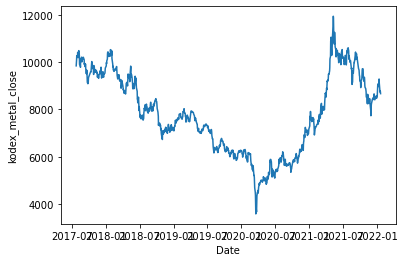

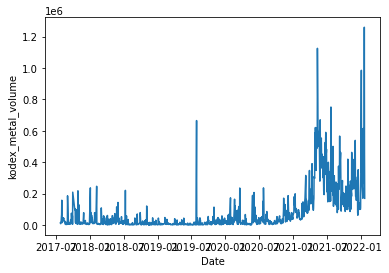

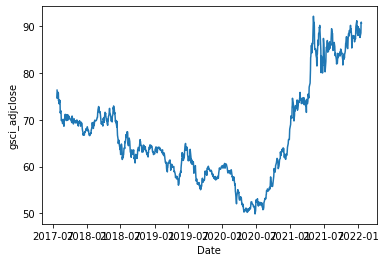

In [30]:
show_plot(df_mod2,df2_cols)

그래프를 보면 알 수 있듯이, 잦은 빈도로 outlier가 등장한다. 이러한 outlier는 모델의 성능을 악화시킬 수 있으므로 추후 전처리 과정에서 제거해야 하는데, 단순히 표준정규화 후 몇 표준편차 떨어져있는가로 제거해버리면 주가의 상하 움직임을 고려하지 못한다. 방법을 찾아야 함.

<AxesSubplot:>

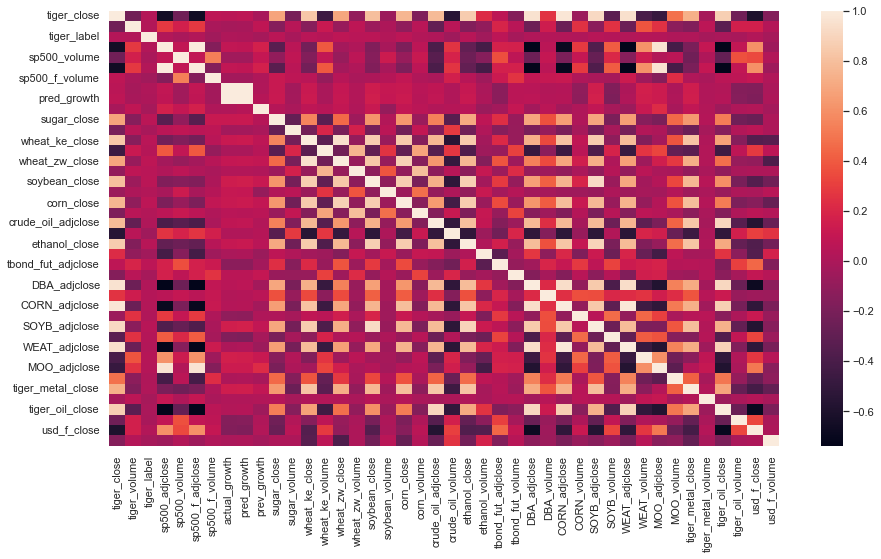

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_mod1.astype('float').corr())

<AxesSubplot:>

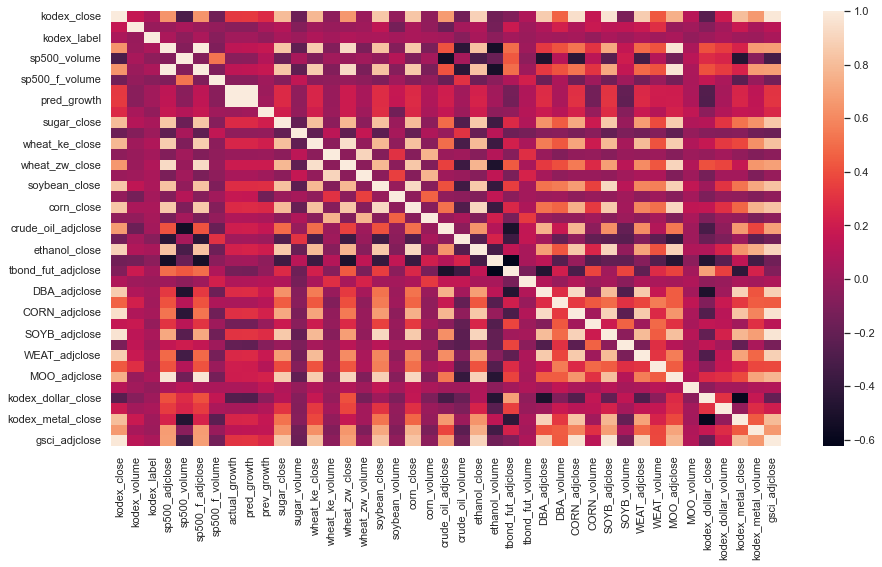

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_mod2.astype('float').corr())

상관관계가 보이는 컬럼들이 몇 개 있지만, 우선 그대로 두고 모델을 돌려보자.

outlier 제거 및 정규화를 진행하자.

In [60]:
# Outlier removal 및 Scaling 할 컬럼명 저장
df1_cols = [x for x in df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')
df1_cols.remove('tiger_label')

df2_cols = [x for x in df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

In [ ]:
'''
아래 방법 쓰면 주가 상하 움직임 고려 x 일단 실행 안함.

# Outlier Removal
def outlier_remove_tiger(df,cols):
    z = np.abs(stats.zscore(df[cols]))
    clean_df = df[cols][(z<6).all(axis=1)].join(df[['actual_growth','pred_growth','prev_growth','tiger_label']])
    print("shape of original data : ",df.shape)
    print("shape of cleared data : ",clean_df.shape)
    return clean_df

def outlier_remove_kodex(df,cols):
    z = np.abs(stats.zscore(df[cols]))
    clean_df = df[cols][(z<6).all(axis=1)].join(df[['actual_growth','pred_growth','prev_growth','kodex_label']])
    print("shape of original data : ",df.shape)
    print("shape of cleared data : ",clean_df.shape)
    return clean_df


df_mod1 = outlier_remove_tiger(df_mod1,df1_cols)
df_mod2 = outlier_remove_kodex(df_mod2,df2_cols)
'''

'\n아래 방법 쓰면 주가 상하 움직임 고려 x 일단 실행 안함.\n\n# Outlier Removal\ndef outlier_remove_tiger(df,cols):\n    z = np.abs(stats.zscore(df[cols]))\n    clean_df = df[cols][(z<6).all(axis=1)].join(df[[\'actual_growth\',\'pred_growth\',\'prev_growth\',\'tiger_label\']])\n    print("shape of original data : ",df.shape)\n    print("shape of cleared data : ",clean_df.shape)\n    return clean_df\n\ndef outlier_remove_kodex(df,cols):\n    z = np.abs(stats.zscore(df[cols]))\n    clean_df = df[cols][(z<6).all(axis=1)].join(df[[\'actual_growth\',\'pred_growth\',\'prev_growth\',\'kodex_label\']])\n    print("shape of original data : ",df.shape)\n    print("shape of cleared data : ",clean_df.shape)\n    return clean_df\n\n\ndf_mod1 = outlier_remove_tiger(df_mod1,df1_cols)\ndf_mod2 = outlier_remove_kodex(df_mod2,df2_cols)\n'

In [ ]:
'''
# time series에 대해 정규화를 하는게 맞는지 잘 모르겠다. 이것도 일단 실행 안함.

# 정규화 진행

def std_scaling_tiger(df,cols):
    scaler = preprocessing.StandardScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','tiger_label']])

def std_scaling_kodex(df,cols):
    scaler = preprocessing.StandardScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','kodex_label']])

input_df_mod1 = std_scaling_tiger(df_mod1,df1_cols)
input_df_mod2 = std_scaling_kodex(df_mod2,df2_cols)
'''

"\n# time series에 대해 정규화를 하는게 맞는지 잘 모르겠다. 이것도 일단 실행 안함.\n\n# 정규화 진행\n\ndef std_scaling_tiger(df,cols):\n    scaler = preprocessing.StandardScaler()\n    normalized_data = scaler.fit_transform(df[cols])\n    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)\n    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','tiger_label']])\n\ndef std_scaling_kodex(df,cols):\n    scaler = preprocessing.StandardScaler()\n    normalized_data = scaler.fit_transform(df[cols])\n    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)\n    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','kodex_label']])\n\ninput_df_mod1 = std_scaling_tiger(df_mod1,df1_cols)\ninput_df_mod2 = std_scaling_kodex(df_mod2,df2_cols)\n"

In [ ]:
#input_df_mod1.info()

In [ ]:
#input_df_mod2.info()

In [61]:
'''
임시 : 정규화를 안해줘서 그냥 input_df_mod1 이랑 mod2를 원래 df_mod1이랑 mod2로 저장해줌.
'''
input_df_mod1 = df_mod1
input_df_mod2 = df_mod2

이제 데이터프레임을 저장하자.

In [34]:
#input_df_mod1.to_csv(DATA_PATH+'input_df_mod1.csv')
#input_df_mod2.to_csv(DATA_PATH+'input_df_mod2.csv')

## 훈련용 / 테스트용 데이터 나누기

타이거 예측 모델은 2011-09-19 ~ 2022-01-21 까지의 자료를 가지고 있으므로 2019-12-31일을 기준으로 그 이전을 학습용 데이터로, 그 이후를 테스트용 데이터로 나누었다.

코덱스 예측 모델은 2017-07-24 ~ 2022-01-21 까지의 자료를 가지고 있으므로 2020-12-31일을 기준으로 그 이전을 학습용 데이터로, 그 이후를 테스트용 데이터로 나누었다.


In [62]:
X_train_mod1 = input_df_mod1[input_df_mod1.index <= '2019-12-31'].drop(['tiger_label'],axis=1)
y_train_mod1 = input_df_mod1[input_df_mod1.index <= '2019-12-31'][['tiger_label']]
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2019-12-31'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2019-12-31'][['tiger_label']]

X_train_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_train_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

# 모델 정의

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Model F1 Score :  0.6951724137931035


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

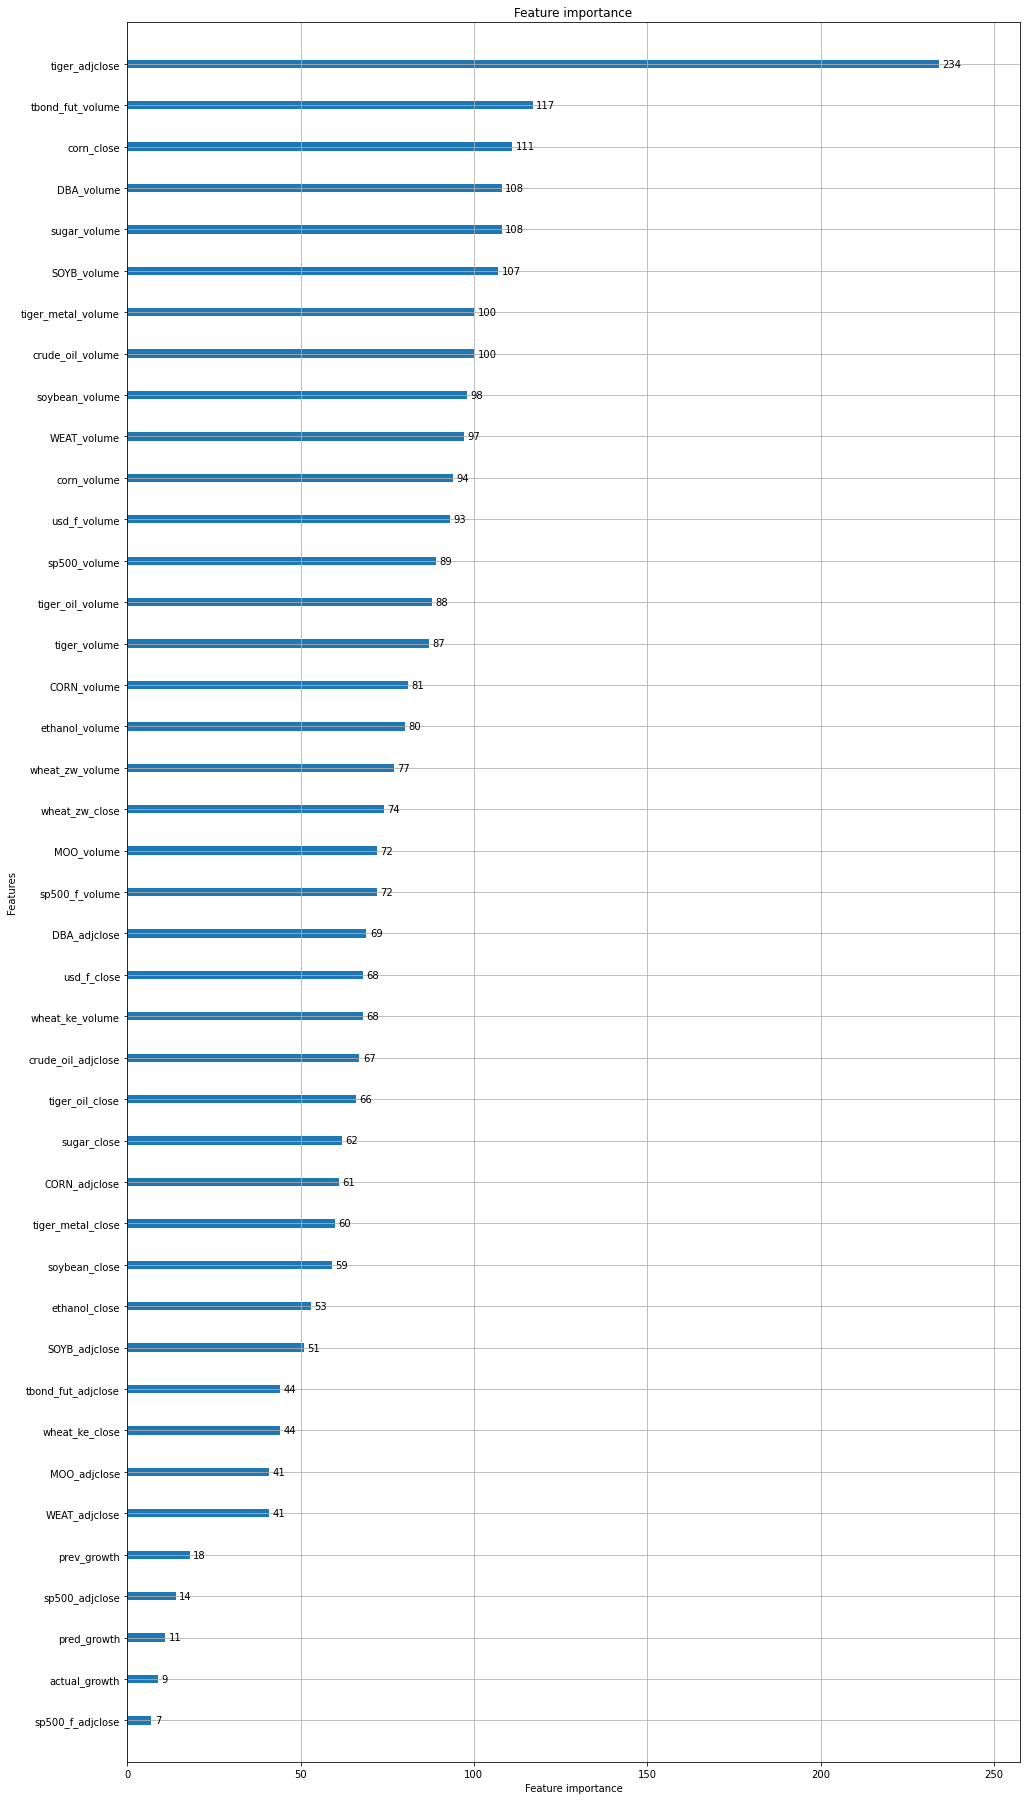

In [63]:
lgb_model1 = LGBMClassifier()

lgb_model1.fit(X_train_mod1, y_train_mod1)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32))

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Model F1 Score :  0.6525198938992042


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

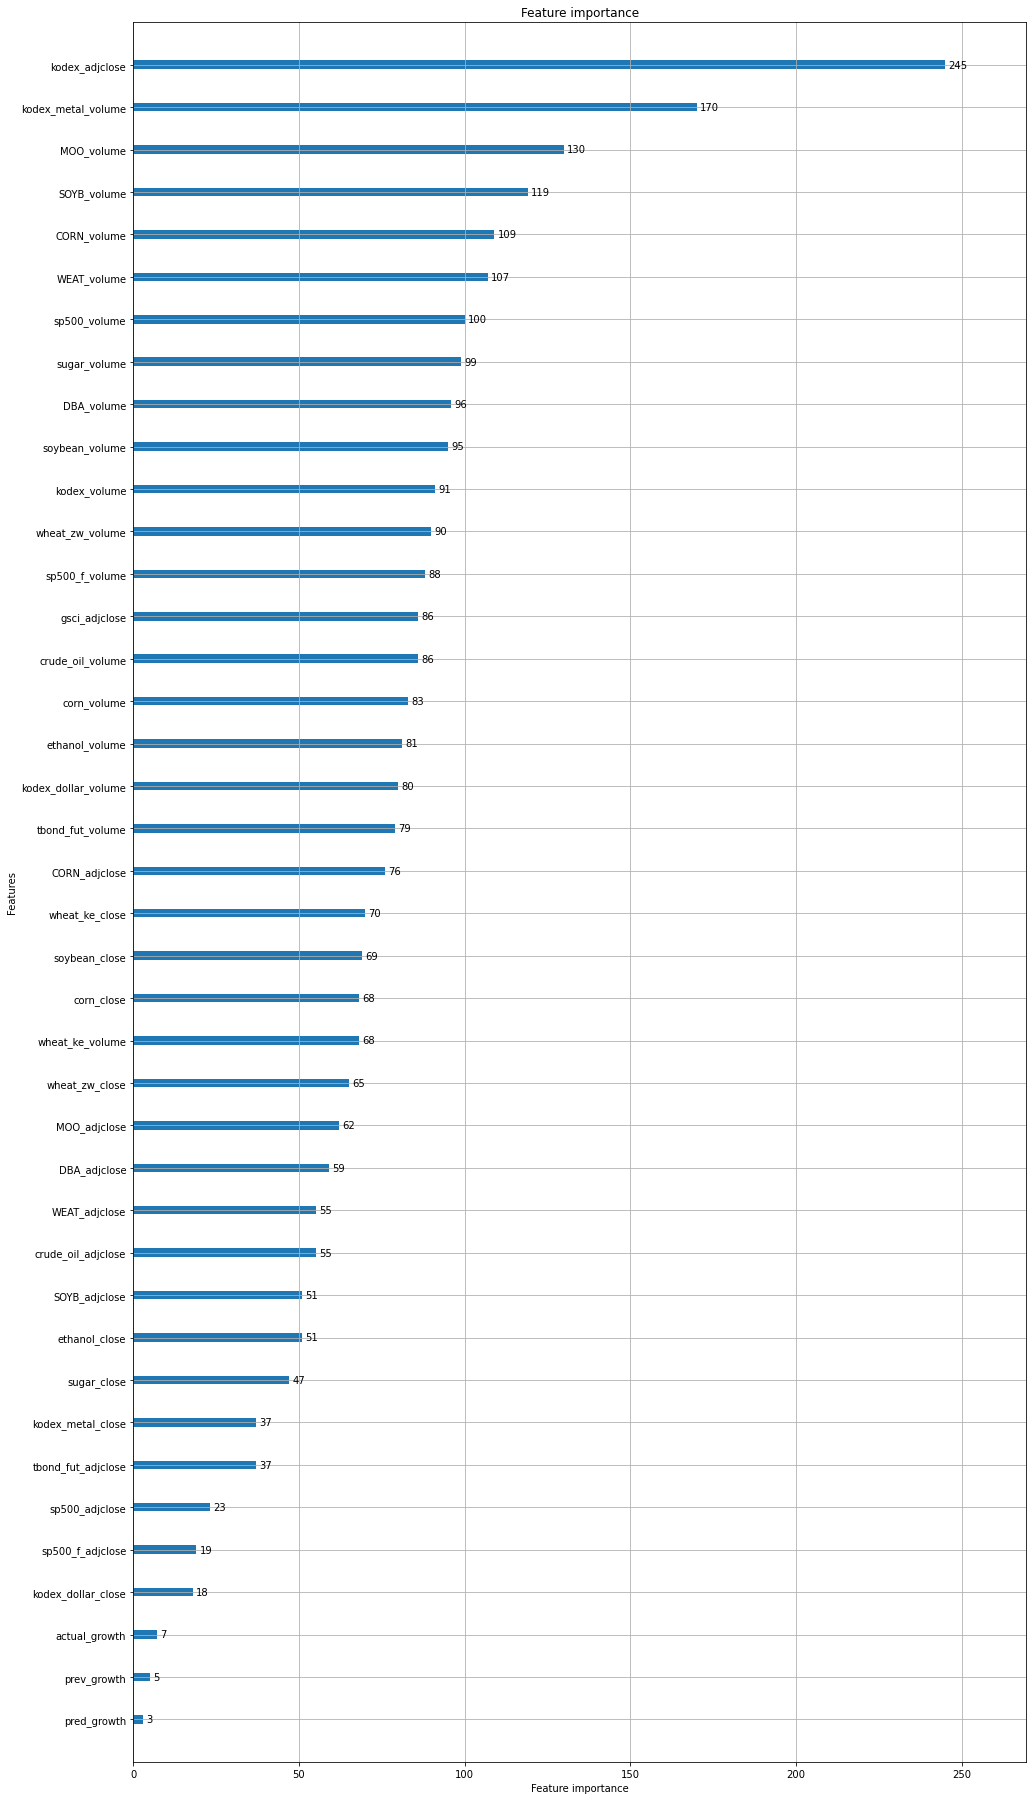

In [64]:
lgb_model2 = LGBMClassifier()

lgb_model2.fit(X_train_mod2, y_train_mod2)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32))

`미국 유효 기준금리` 추가

`Early Stopping` 추가

In [38]:
# effective_base_rate.csv 파일 불러오기
base_rate = pd.read_csv(DATA_PATH+'effective_base_rate.csv')
base_rate.columns = ['Date','base_rate']
base_rate = index_to_date(base_rate)
base_rate = base_rate.set_index('Date')

In [39]:
df_mod1 = df_mod1.join(base_rate)
df_mod1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2471 entries, 2011-09-19 to 2022-01-21
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tiger_close         2471 non-null   int64  
 1   tiger_volume        2471 non-null   int64  
 2   tiger_label         2471 non-null   int64  
 3   sp500_adjclose      2471 non-null   float64
 4   sp500_volume        2471 non-null   float64
 5   sp500_f_adjclose    2471 non-null   float64
 6   sp500_f_volume      2471 non-null   float64
 7   actual_growth       2471 non-null   float64
 8   pred_growth         2471 non-null   float64
 9   prev_growth         2471 non-null   float64
 10  sugar_close         2471 non-null   float64
 11  sugar_volume        2471 non-null   float64
 12  wheat_ke_close      2471 non-null   float64
 13  wheat_ke_volume     2471 non-null   float64
 14  wheat_zw_close      2471 non-null   float64
 15  wheat_zw_volume     2471 non-null   f

In [40]:
df_mod1.dropna()
df_mod1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2471 entries, 2011-09-19 to 2022-01-21
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tiger_close         2471 non-null   int64  
 1   tiger_volume        2471 non-null   int64  
 2   tiger_label         2471 non-null   int64  
 3   sp500_adjclose      2471 non-null   float64
 4   sp500_volume        2471 non-null   float64
 5   sp500_f_adjclose    2471 non-null   float64
 6   sp500_f_volume      2471 non-null   float64
 7   actual_growth       2471 non-null   float64
 8   pred_growth         2471 non-null   float64
 9   prev_growth         2471 non-null   float64
 10  sugar_close         2471 non-null   float64
 11  sugar_volume        2471 non-null   float64
 12  wheat_ke_close      2471 non-null   float64
 13  wheat_ke_volume     2471 non-null   float64
 14  wheat_zw_close      2471 non-null   float64
 15  wheat_zw_volume     2471 non-null   f

In [41]:
df_mod2 = df_mod2.join(base_rate)
df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1074 entries, 2017-07-24 to 2022-01-21
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kodex_close          1074 non-null   int64  
 1   kodex_volume         1074 non-null   int64  
 2   kodex_label          1074 non-null   int64  
 3   sp500_adjclose       1074 non-null   float64
 4   sp500_volume         1074 non-null   float64
 5   sp500_f_adjclose     1074 non-null   float64
 6   sp500_f_volume       1074 non-null   float64
 7   actual_growth        1074 non-null   float64
 8   pred_growth          1074 non-null   float64
 9   prev_growth          1074 non-null   float64
 10  sugar_close          1074 non-null   float64
 11  sugar_volume         1074 non-null   float64
 12  wheat_ke_close       1074 non-null   float64
 13  wheat_ke_volume      1074 non-null   float64
 14  wheat_zw_close       1074 non-null   float64
 15  wheat_zw_volume     

In [42]:
df_mod2.dropna()
df_mod2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1074 entries, 2017-07-24 to 2022-01-21
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kodex_close          1074 non-null   int64  
 1   kodex_volume         1074 non-null   int64  
 2   kodex_label          1074 non-null   int64  
 3   sp500_adjclose       1074 non-null   float64
 4   sp500_volume         1074 non-null   float64
 5   sp500_f_adjclose     1074 non-null   float64
 6   sp500_f_volume       1074 non-null   float64
 7   actual_growth        1074 non-null   float64
 8   pred_growth          1074 non-null   float64
 9   prev_growth          1074 non-null   float64
 10  sugar_close          1074 non-null   float64
 11  sugar_volume         1074 non-null   float64
 12  wheat_ke_close       1074 non-null   float64
 13  wheat_ke_volume      1074 non-null   float64
 14  wheat_zw_close       1074 non-null   float64
 15  wheat_zw_volume     

In [43]:
input_df_mod1 = df_mod1
input_df_mod2 = df_mod2

In [44]:
input_df_mod1.to_csv('input_df_mod1.csv')
input_df_mod2.to_csv('input_df_mod2.csv')

tiger 자료는 2011.09.19~2022.01.21 까지의 자료를 가지고 있으므로 2020.07.02~2022.01.21를 test 데이터셋으로, 그 이전 데이터는 9:1로 학습/검증용 데이터셋으로 random split 했다.
kodex 자료는 2017.07.24~2022.01.21 까지의 자료를 가지고 있으므로 2021.01.01~2022.01.21를 test 데이터셋으로, 그 이전 데이터는 9:1로 학습/검증용 데이터셋으로 random split 했다.

In [45]:
X_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.679233
Model F1 Score :  0.6056644880174292


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

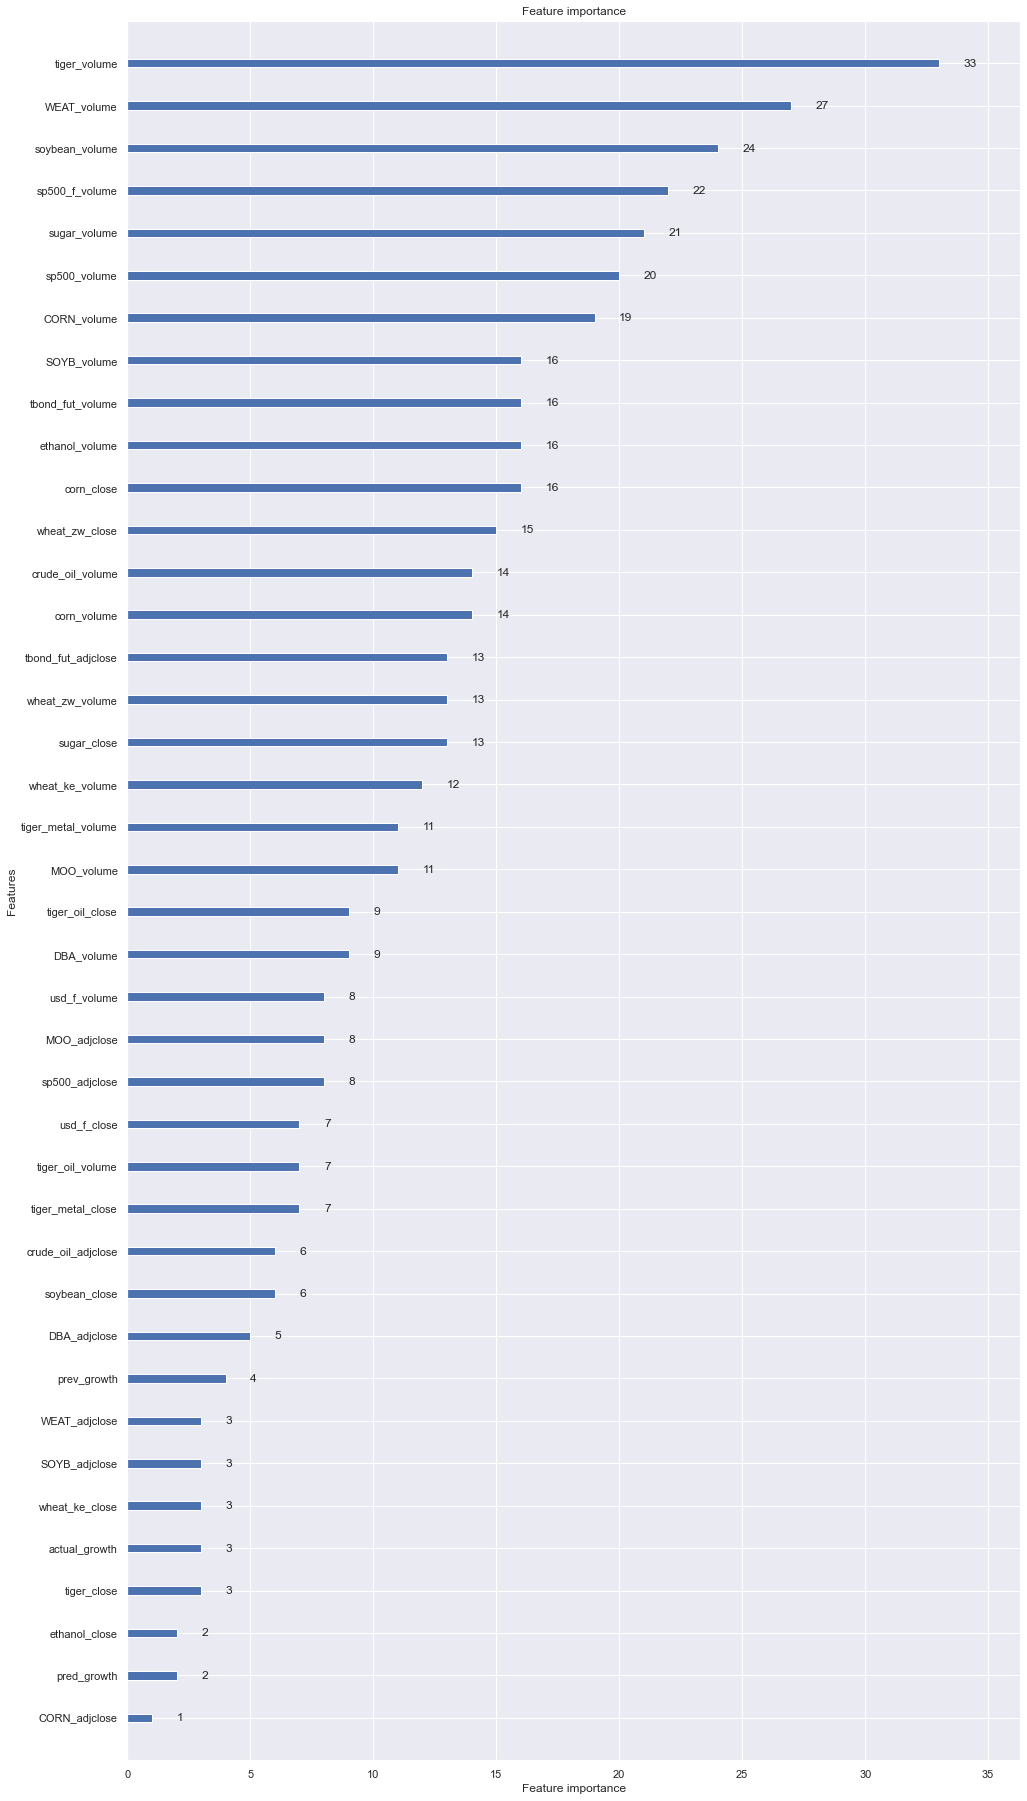

In [46]:
lgb_model1 = LGBMClassifier()

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 50)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32))

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.662707
Model F1 Score :  0.6292134831460673


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

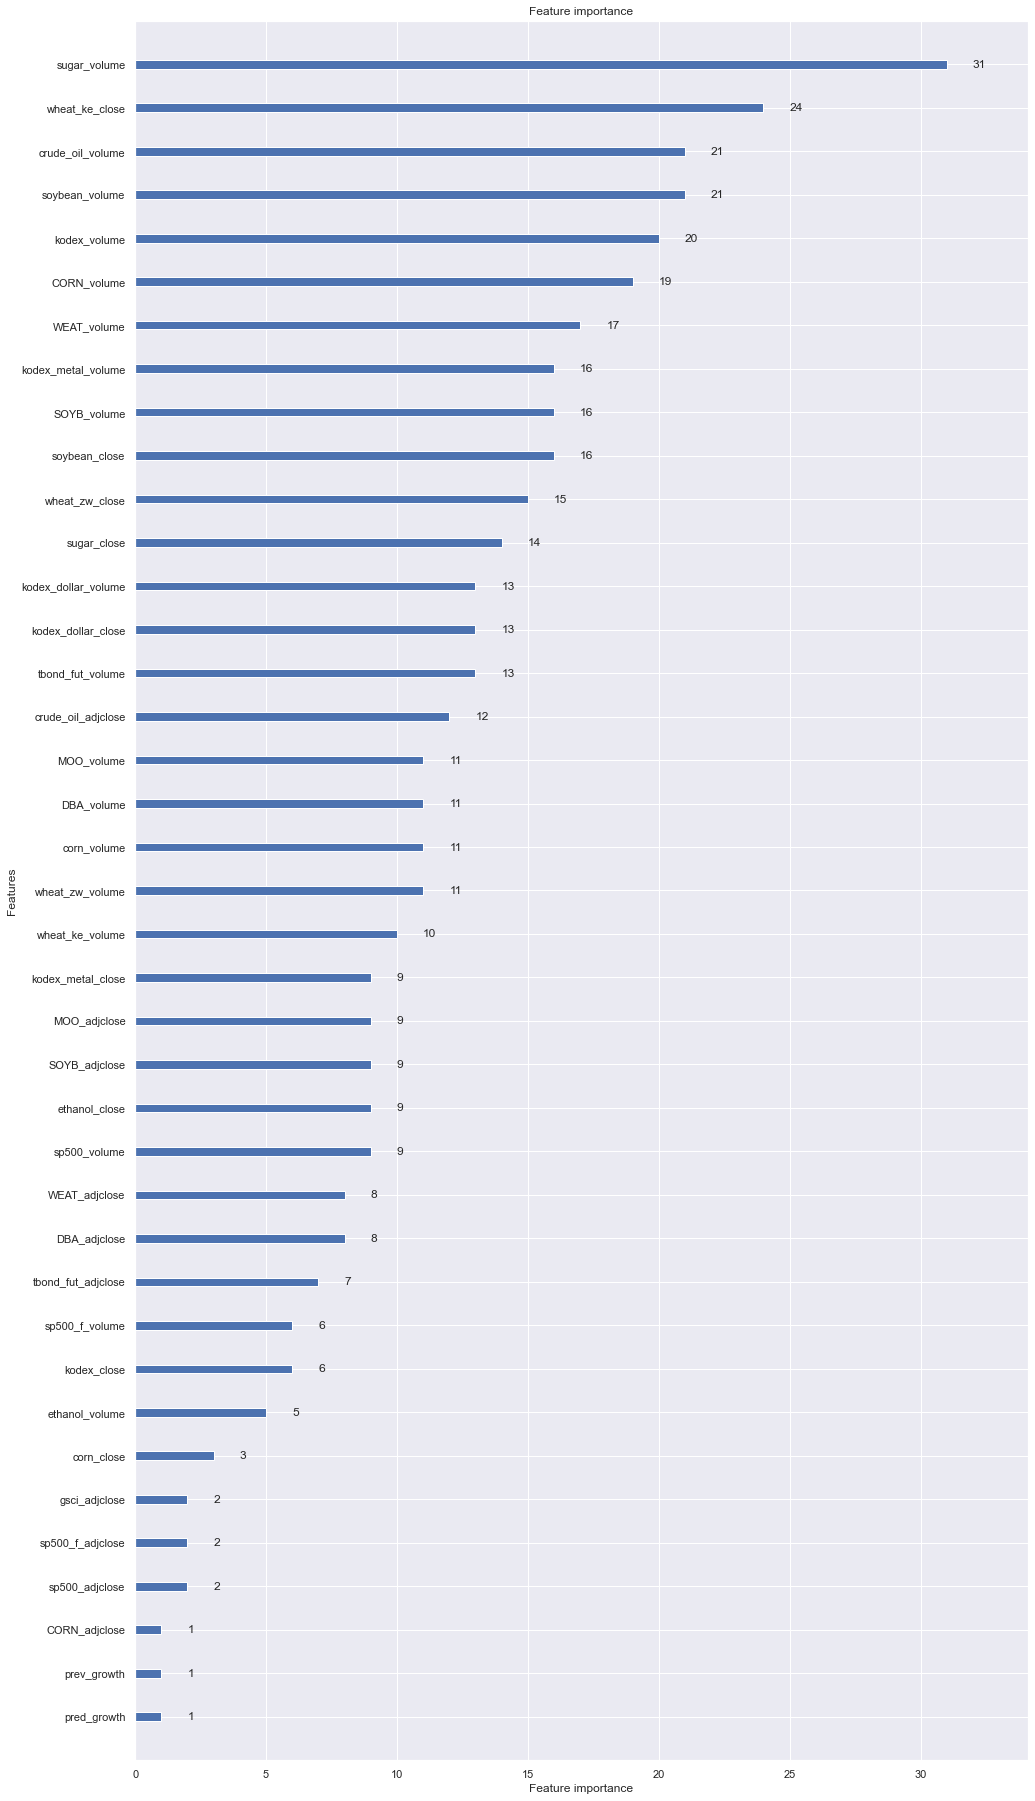

In [47]:
lgb_model2 = LGBMClassifier()

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 50)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32))

`Bollingerband & clip을 활용하여 극단값 자르기` 추가<br/>
`real_gdp 컬럼가공` 추가<br/>
`20일 이동평균` 추가

In [65]:
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats

from talib import RSI, BBANDS, MACD

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMClassifier, plot_importance


In [3]:
# Datetime으로 형식 지정하는 함수 정의
def index_to_date(df):
    df['Date']=pd.to_datetime(df['Date'])
    return df

DATA_PATH='C:/'
# 코덱스 종가, 볼륨, 라벨 자료
kodex = pd.read_csv(DATA_PATH+'df_kodex.csv')
kodex = index_to_date(kodex)
kodex = kodex.set_index('Date')
kodex = kodex[['Close','Volume','label']]
kodex.columns = ['kodex_close','kodex_volume','kodex_label']

# 타이거 종가, 볼륨, 라벨 자료
tiger = pd.read_csv(DATA_PATH+'df_tiger.csv')
tiger = index_to_date(tiger)
tiger = tiger.set_index('Date')
tiger = tiger[['Close','Volume','label']]
tiger.columns = ['tiger_close','tiger_volume','tiger_label']

# sp500 수정종가, 볼륨 자료
sp500 = pd.read_csv(DATA_PATH+'sp500.csv')
sp500 = index_to_date(sp500)
sp500 = sp500.set_index('Date')
sp500 = sp500[['Adj Close','Volume']]
sp500.columns = ['sp500_adjclose','sp500_volume']

# sp500_f 수정종가, 볼륨 자료
sp500_f = pd.read_csv(DATA_PATH+'sp500_futures.csv')
sp500_f = index_to_date(sp500_f)
sp500_f = sp500_f.set_index('Date')
sp500_f = sp500_f[['Adj Close','Volume']]
sp500_f.columns = ['sp500_f_adjclose','sp500_f_volume']

# real_gdp 발표/예측/이전 성장률 자료
real_gdp = pd.read_csv(DATA_PATH+'real_gdp_announce.csv')
real_gdp.columns = ['Date','actual_growth','pred_growth','prev_growth']
real_gdp = index_to_date(real_gdp)
real_gdp = real_gdp.set_index('Date')

# grains_f 설탕/밀(ke)/밀(zw)/대두/옥수수 종가 및 볼륨 자료
grains_f = pd.read_csv(DATA_PATH+'곡물선물가격.csv')
grains_f = grains_f[grains_f['Date']>='2011-01-01'] # 필요 없는 날짜 제거
grains_f = index_to_date(grains_f)
grains_f = grains_f.set_index('Date')

# oil_ethanol_tbond_f 원유/에탄올/10년만기 미국 국채 선물 종가 및 볼륨 자료
oil_ethanol_tbond_f = pd.read_csv(DATA_PATH+'원유에탄올국채선물.csv')
oil_ethanol_tbond_f = index_to_date(oil_ethanol_tbond_f)
oil_ethanol_tbond_f = oil_ethanol_tbond_f.set_index('Date')

# other_etf 인베스코/Tieucrium옥수수/대두/밀/VanEck ETF 수정종가 및 볼륨 자료
other_etf = pd.read_csv(DATA_PATH+'외국원자재선물etf.csv')
other_etf = index_to_date(other_etf)
other_etf = other_etf.set_index('Date')

# kodex_dollar_iron 코덱스달러선물/코덱스철강선물 etf 종가 및 볼륨 자료
kodex_dollar_iron = pd.read_csv(DATA_PATH+'kodex_dollar_iron.csv')
kodex_dollar_iron = index_to_date(kodex_dollar_iron)
kodex_dollar_iron = kodex_dollar_iron.set_index('Date')

# kosef_usd_f KOSEF 달러선물 종가 및 볼륨 자료
kosef_usd_f = pd.read_csv(DATA_PATH+'kosef_usd_f.csv')
kosef_usd_f = kosef_usd_f[['Date','Close','Volume']]
kosef_usd_f.columns = ['Date','usd_f_close','usd_f_volume']
kosef_usd_f = index_to_date(kosef_usd_f)
kosef_usd_f = kosef_usd_f.set_index('Date')

# tiger_metal_oil 타이거금속선물/원유선물 종가 및 볼륨 자료
tiger_metal_oil = pd.read_csv(DATA_PATH+'tiger_metal_oil.csv')
tiger_metal_oil = index_to_date(tiger_metal_oil)
tiger_metal_oil = tiger_metal_oil.set_index('Date')

# gsci SP500 GSCI Grains select index 종가 자료
gsci = pd.read_csv(DATA_PATH+'GSCI.csv').iloc[:,:2]
gsci.columns = ['Date','gsci_adjclose']
gsci = index_to_date(gsci)
gsci = gsci.set_index('Date')

# effective_base_rate.csv 파일 불러오기
base_rate = pd.read_csv(DATA_PATH+'effective_base_rate.csv')
base_rate.columns = ['Date','base_rate']
base_rate = index_to_date(base_rate)
base_rate = base_rate.set_index('Date')

# 결측치 처리
grains_f = grains_f.fillna(method='ffill')
oil_ethanol_tbond_f['ethanol_volume'] = oil_ethanol_tbond_f['ethanol_volume'].fillna(value=0)
oil_ethanol_tbond_f = oil_ethanol_tbond_f.fillna(method='ffill')
cond = pd.to_datetime(other_etf.index)>='2011-09-19' # 아예 자료가 없는 2011-09-19 이전은 그대로 두고, 학습 전에 drop시킨다.
other_etf[cond]['SOYB_volume'] = other_etf[cond]['SOYB_volume'].fillna(value=0) # 2011-09-19 이후의 결측치 처리
other_etf[cond]['WEAT_volume'] = other_etf[cond]['WEAT_volume'].fillna(value=0)
other_etf[cond] = other_etf[cond].fillna(method='ffill')



df_list = [sp500, sp500_f, real_gdp, grains_f, oil_ethanol_tbond_f, other_etf, tiger_metal_oil, kosef_usd_f]
df_mod1 = tiger

for df in df_list:
    df_mod1 = df_mod1.join(df)

df_mod1 = df_mod1.dropna()

df_list = [sp500, sp500_f, real_gdp, grains_f, oil_ethanol_tbond_f, other_etf, kodex_dollar_iron, gsci]
df_mod2 = kodex

for df in df_list:
    df_mod2 = df_mod2.join(df)

df_mod2 = df_mod2.dropna()

'''
위 코드는 그냥 복붙하기 귀찮아서 미리 써둔 것.
이제 위에서 나온 df_mod1과 df_mod2에 대해 bollingerband로 clipping한 df을 불러와서 input_df_mod1과 input_df_mod2로 저장하자. (bband.ipynb 파일 참조!!)
'''






C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_9008/3483442538.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_etf[cond]['SOYB_volume'] = other_etf[cond]['SOYB_volume'].fillna(value=0) # 2011-09-19 이후의 결측치 처리
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_9008/3483442538.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_etf[cond]['WEAT_volume'] = other_etf[cond]['WEAT_volume'].fillna(value=0)


'\n위 코드는 그냥 복붙하기 귀찮아서 미리 써둔 것.\n이제 위에서 나온 df_mod1과 df_mod2에 대해 bollingerband로 clipping한 df을 불러와서 input_df_mod1과 input_df_mod2로 저장하자. (bband.ipynb 파일 참조!!)\n'

In [67]:
df_mod1.to_csv('handle_mod1.csv')
df_mod2.to_csv('handle_mod2.csv')
'''
bband.ipynb에서 데이터 처리 후 다시 가져오기!!!
'''

'\nbband.ipynb에서 데이터 처리 후 다시 가져오기!!!\n'

In [68]:
input_df_mod1 = pd.read_csv(DATA_PATH+'bband_df1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'bband_df2.csv',index_col=0)

input_df_mod1.head()

,tiger_adjclose,tiger_volume,tiger_label,sp500_adjclose,sp500_volume,sp500_f_adjclose,sp500_f_volume,actual_growth,pred_growth,prev_growth,...,WEAT_adjclose,WEAT_volume,MOO_adjclose,MOO_volume,tiger_metal_close,tiger_metal_volume,tiger_oil_close,tiger_oil_volume,usd_f_close,usd_f_volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-09-19,10060,23905,1,1204.089966,4.254190e+09,1197.75,2446620.0,1.3,1.2,1.0,...,24.570000,100.0,40.831242,912500.0,8755.0,629.0,9585.0,5659.0,11205.0,35909.0
2011-09-20,10090,4621,-1,1202.089966,4.315610e+09,1196.00,2614553.0,1.3,1.2,1.0,...,24.870001,1000.0,40.279140,1184500.0,8485.0,1053.0,9460.0,6436.0,11333.0,43425.0
2011-09-21,10050,11025,-1,1166.760010,4.728550e+09,1155.75,3254771.0,1.3,1.2,1.0,...,24.230000,300.0,38.738174,1341600.0,8445.0,632.0,9520.0,2726.0,11330.0,35780.0
2011-09-22,9825,30412,-1,1129.560059,6.703140e+09,1123.50,4741905.0,1.3,1.2,1.0,...,23.000000,1000.0,36.562710,2631200.0,8400.0,792.0,9300.0,8987.0,11630.0,53347.0
2011-09-23,9435,25156,-1,1136.430054,5.639930e+09,1129.75,3365634.0,1.3,1.2,1.0,...,23.559999,300.0,36.719284,1703400.0,7860.0,4467.0,8785.0,23406.0,11785.0,138997.0


In [69]:
input_df_mod2.head()

,kodex_adjclose,kodex_volume,kodex_label,sp500_adjclose,sp500_volume,sp500_f_adjclose,sp500_f_volume,actual_growth,pred_growth,prev_growth,...,SOYB_volume,WEAT_adjclose,WEAT_volume,MOO_adjclose,MOO_volume,kodex_dollar_close,kodex_dollar_volume,kodex_metal_close,kodex_metal_volume,gsci_adjclose
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-24,10330,249973,1,2469.909912,3.010240e+09,2468.50,857750.0,2.6,2.6,1.2,...,43800.0,7.47,250200.0,52.905434,26300.0,9340.0,23457.0,9846.0,12631.0,76.34
2017-07-25,10470,249826,-1,2477.129883,4.108060e+09,2474.00,1074033.0,2.6,2.6,1.2,...,51700.0,7.29,286600.0,52.961510,36400.0,9350.0,8061.0,9954.0,10877.0,74.58
2017-07-26,10175,250878,1,2477.830078,3.557020e+09,2473.25,972444.0,2.6,2.6,1.2,...,23600.0,7.33,269400.0,52.961510,18500.0,9400.0,24160.0,10088.0,7780.0,75.34
2017-07-27,10250,230167,1,2475.419922,3.995520e+09,2472.00,1647577.0,2.6,2.6,1.2,...,6700.0,7.36,333800.0,52.886742,27600.0,9330.0,16537.0,10270.0,16202.0,75.77
2017-07-28,10270,215680,-1,2472.100098,3.294770e+09,2470.25,1156784.0,2.6,2.6,1.2,...,35100.0,7.37,231400.0,53.036274,31600.0,9395.0,140945.0,10219.0,16137.0,75.93


In [70]:
'''
real_gdp 자료 가공해주기
'''

def real_gdp_processing(df):
    temp=df
    temp['growth_pred_error'] = df['actual_growth'] - df['pred_growth']
    temp['growth_prev_diff'] = df['actual_growth'] - df['prev_growth']
    return temp

input_df_mod1 = real_gdp_processing(input_df_mod1)
input_df_mod2 = real_gdp_processing(input_df_mod2)

In [71]:
'''
wheat 선물 자료 평균처리하기
'''

input_df_mod1['wheat_close']=(input_df_mod1['wheat_ke_close']+input_df_mod1['wheat_zw_close'])/2
input_df_mod1['wheat_volume']=(input_df_mod1['wheat_ke_volume']+input_df_mod1['wheat_ke_volume'])/2
input_df_mod2['wheat_close']=(input_df_mod2['wheat_ke_close']+input_df_mod2['wheat_zw_close'])/2
input_df_mod2['wheat_volume']=(input_df_mod2['wheat_ke_volume']+input_df_mod2['wheat_ke_volume'])/2

input_df_mod1.drop(['wheat_ke_close','wheat_ke_volume','wheat_zw_close','wheat_zw_volume'],axis=1,inplace=True)
input_df_mod2.drop(['wheat_ke_close','wheat_ke_volume','wheat_zw_close','wheat_zw_volume'],axis=1,inplace=True)

In [72]:

'''
이제 위 자료에서 몇몇 유의미할 것으로 예상되는 컬럼에 대해 과거 20일 이동평균을 
계산해서 추가해주자.
'''
rolling_col_tiger = ['tiger_adjclose', 'sp500_adjclose','sp500_f_adjclose',
'sugar_close','wheat_close','soybean_close', 'corn_close', 
'crude_oil_adjclose','ethanol_close','tbond_fut_adjclose',
'DBA_adjclose','CORN_adjclose','SOYB_adjclose','WEAT_adjclose','MOO_adjclose',
'usd_f_close','tiger_metal_close','tiger_oil_close']

rolling_col_kodex = ['kodex_adjclose', 'sp500_adjclose','sp500_f_adjclose',
'sugar_close','wheat_close','soybean_close', 'corn_close', 
'crude_oil_adjclose','ethanol_close','tbond_fut_adjclose',
'DBA_adjclose','CORN_adjclose','SOYB_adjclose','WEAT_adjclose','MOO_adjclose',
'kodex_dollar_close','kodex_metal_close','gsci_adjclose']

In [73]:
def rolling_mean(df,cols):
    for col in cols:
        col_name = col+"_mean"
        df[col_name]=df[col].rolling(window=20,min_periods=1).mean()
    return df

input_df_mod1 = rolling_mean(input_df_mod1, rolling_col_tiger)
input_df_mod2 = rolling_mean(input_df_mod2, rolling_col_kodex)

In [74]:
# 레그값 추가중
input_df_mod1.to_csv('input_df_mod1.csv')
input_df_mod2.to_csv('input_df_mod2.csv')

In [110]:
'''
레그값들 추가한 데이터를 다시 불러오자.
'''

input_df_mod1 = pd.read_csv(DATA_PATH+'lag_df1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'lag_df2.csv',index_col=0)

In [111]:
'''
정규화도 진행해보자.
'''

# time series에 대해 정규화를 하는게 맞는지 잘 모르겠다. 이것도 일단 실행 안함.

# 정규화 진행

# Scaling 할 컬럼명 저장
df1_cols = [x for x in input_df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')
df1_cols.remove('growth_pred_error')
df1_cols.remove('growth_prev_diff')
df1_cols.remove('tiger_label')

df2_cols = [x for x in input_df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
df2_cols.remove('growth_prev_diff')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def robust_scaling_tiger(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','tiger_label']])

def robust_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','kodex_label']])

input_df_mod1 = robust_scaling_tiger(input_df_mod1,df1_cols)
input_df_mod2 = robust_scaling_kodex(input_df_mod2,df2_cols)


In [112]:
# 데이터 처리중
#input_df_mod1.to_csv('model1.csv')
#input_df_mod2.to_csv('model2.csv')

In [113]:
X_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]



C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.669745
Model F1 Score :  0.676416819012797


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

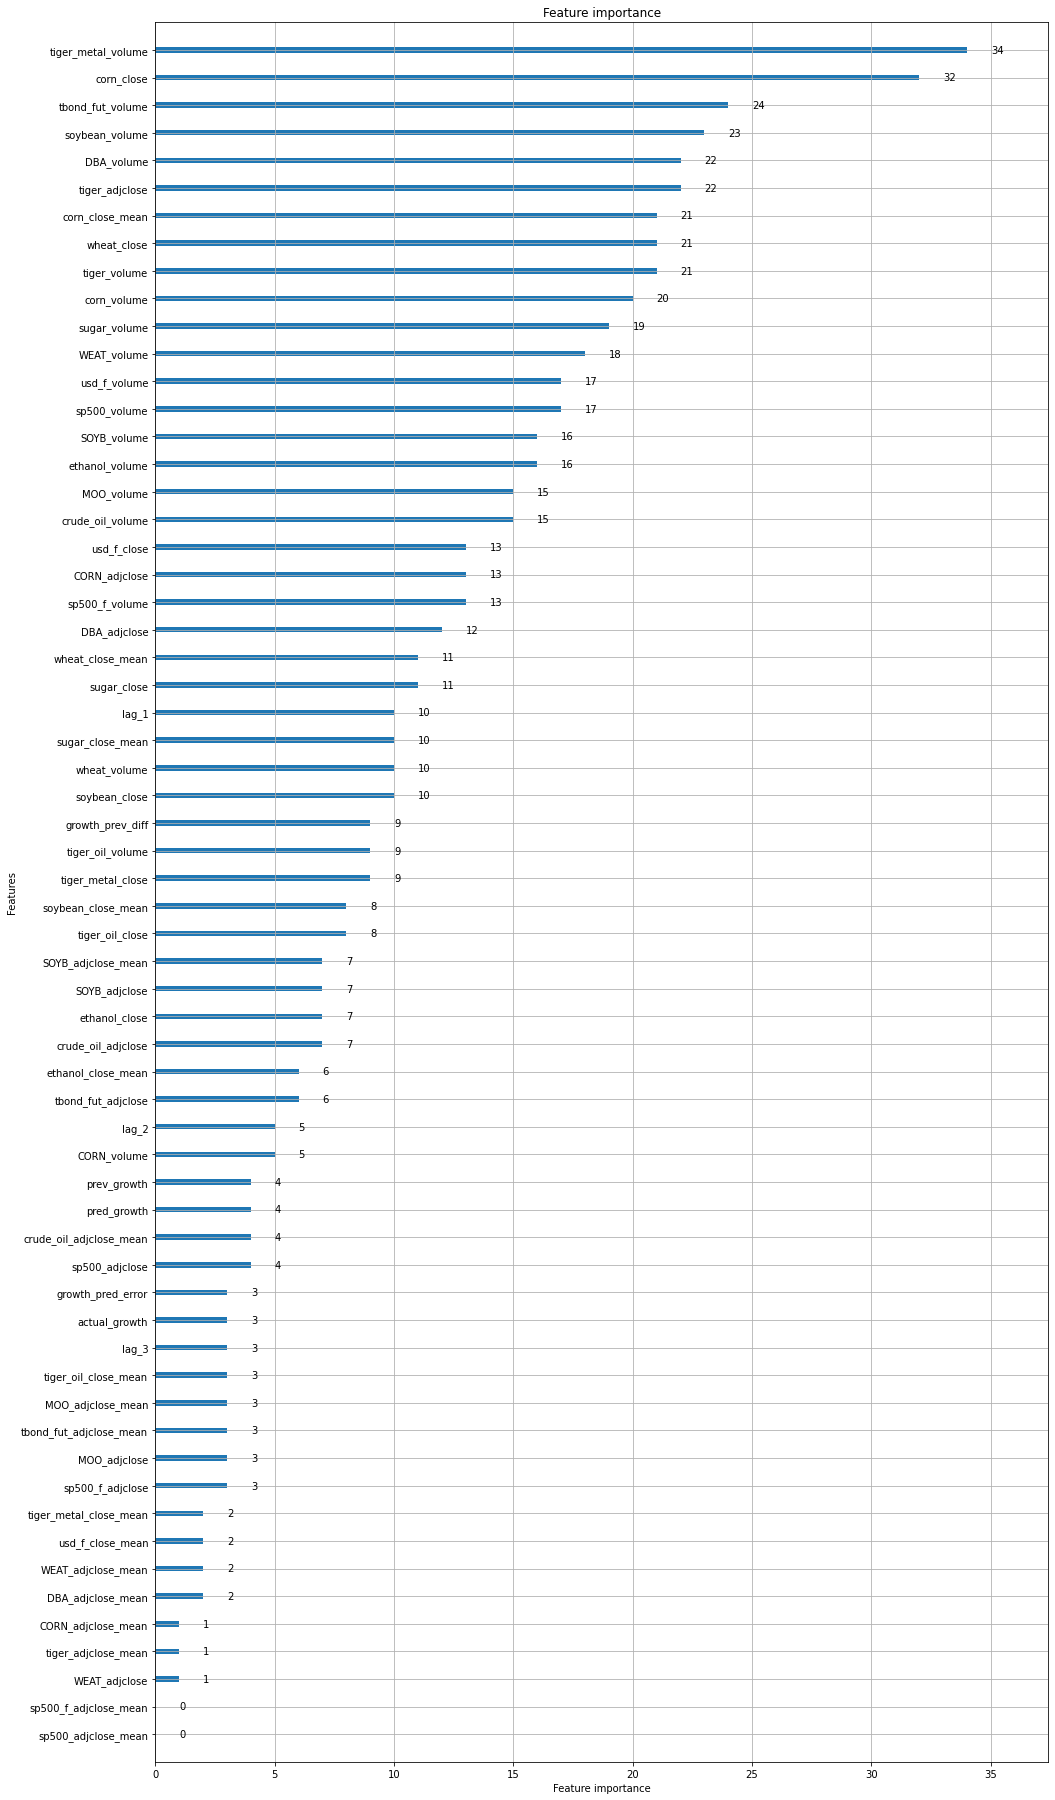

In [114]:
lgb_model1 = LGBMClassifier()

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32),ignore_zero=False)

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.658984
Model F1 Score :  0.6525198938992042


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

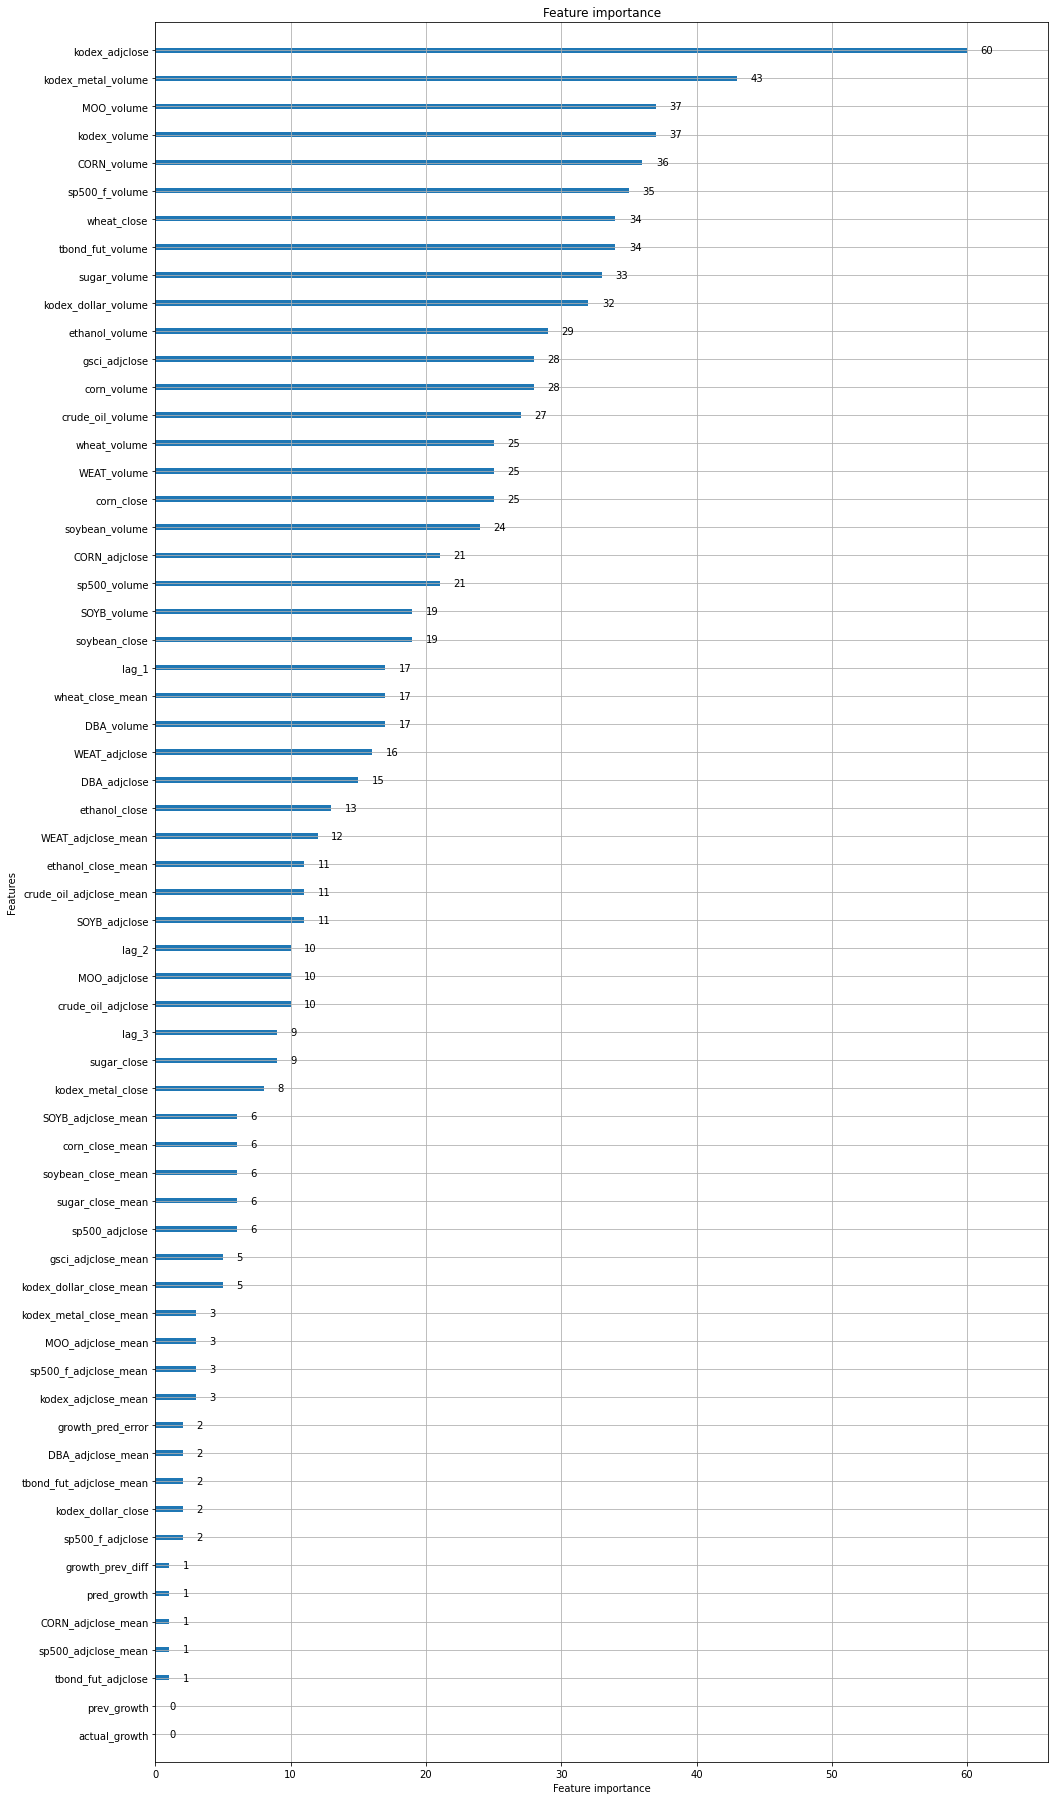

In [115]:
lgb_model2 = LGBMClassifier()

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

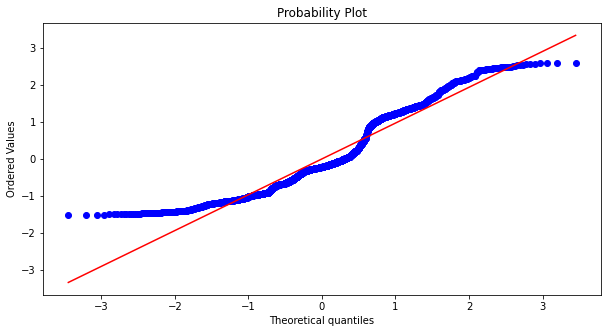

In [92]:
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(10,5))
stats.probplot(input_df_mod1['tiger_adjclose'],dist=stats.norm,plot=plt)
plt.show()

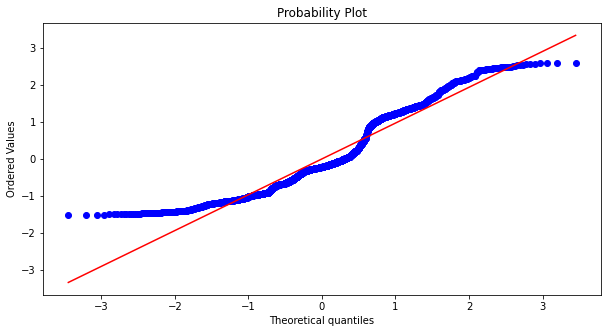

In [93]:
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(10,5))
stats.probplot(input_df_mod1['tiger_adjclose'],dist=stats.norm,plot=plt)
plt.show()

`GridSearchCV` 추가

In [ ]:
'''
LGBMClassifier()
boosting_type='gbdt',
 num_leaves=31, 
 max_depth=-1, 
 learning_rate=0.1, 
 n_estimators=100, 
 subsample_for_bin=200000, 
 objective=None, 
 class_weight=None, 
 min_split_gain=0, 
 min_child_weight=0.001, 
 min_child_samples=20, 
 subsample=1, 
 subsample_freq=0, 
 colsample_bytree=1, 
 reg_alpha=0, 
 reg_lambda=0, 
 random_state=None, 
 n_jobs=-1, 
 silent=True, 
 importance_type='split',
 '''

In [116]:
params_mod = {
    'max_depth': (1, 20), 
    'num_leaves': (10,40), 
    'min_child_samples': (10, 170), 
    'min_child_weight':(0.0001, 20),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_lambda':(0, 20),
    'reg_alpha': (0, 50) 
}
tuner_mod1 = GridSearchCV(lgb_model1,params_mod,n_jobs=multiprocessing.cpu_count(),verbose=True)
tuner_mod1.fit(X_train_mod1,np.array(y_train_mod1).ravel())
print(tuner_mod1.best_params_)

tuner_mod2 = GridSearchCV(lgb_model2,params_mod,n_jobs=multiprocessing.cpu_count(),verbose=True)
tuner_mod2.fit(X_train_mod2,np.array(y_train_mod2).ravel())
print(tuner_mod2.best_params_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'colsample_bytree': 1.0, 'max_depth': 20, 'min_child_samples': 10, 'min_child_weight': 20, 'num_leaves': 40, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'colsample_bytree': 1.0, 'max_depth': 20, 'min_child_samples': 10, 'min_child_weight': 20, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.665344
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.660137
Model F1 Score :  0.6459143968871596


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

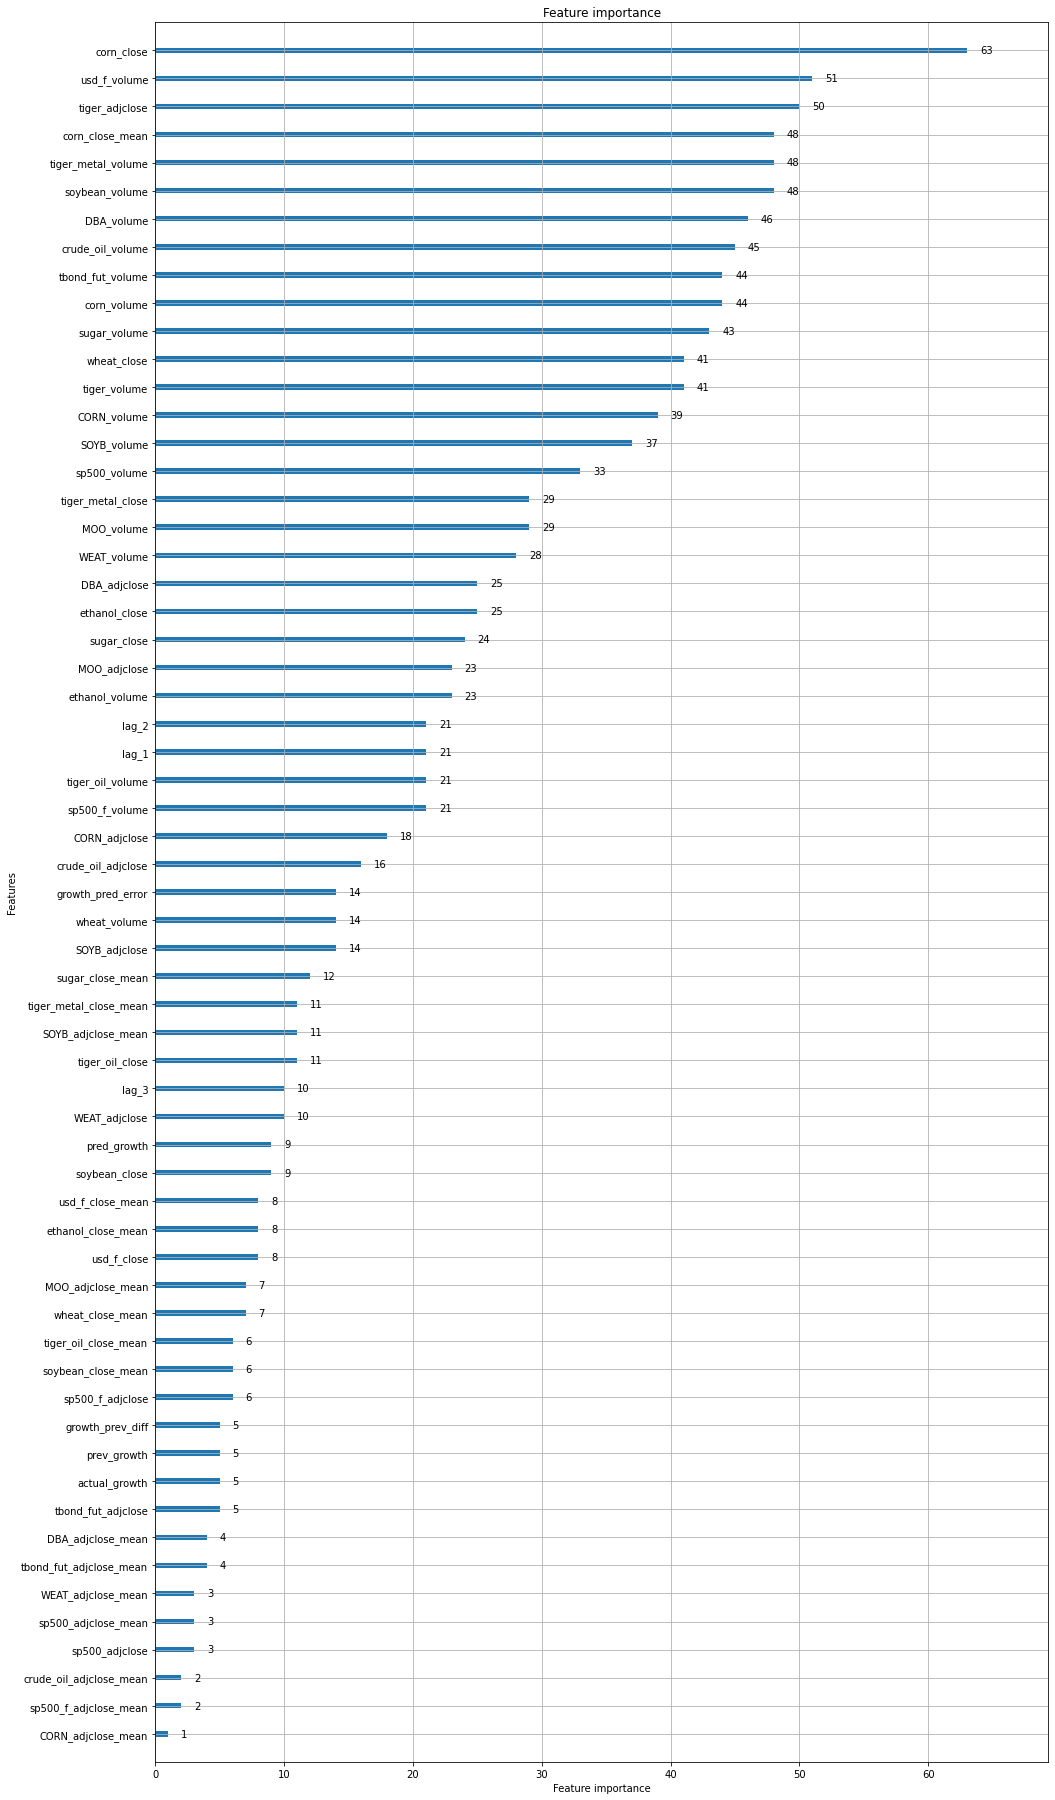

In [117]:
lgb_model1 = LGBMClassifier(**tuner_mod1.best_params_)

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 50)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32))

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.663287
Model F1 Score :  0.6525198938992042


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

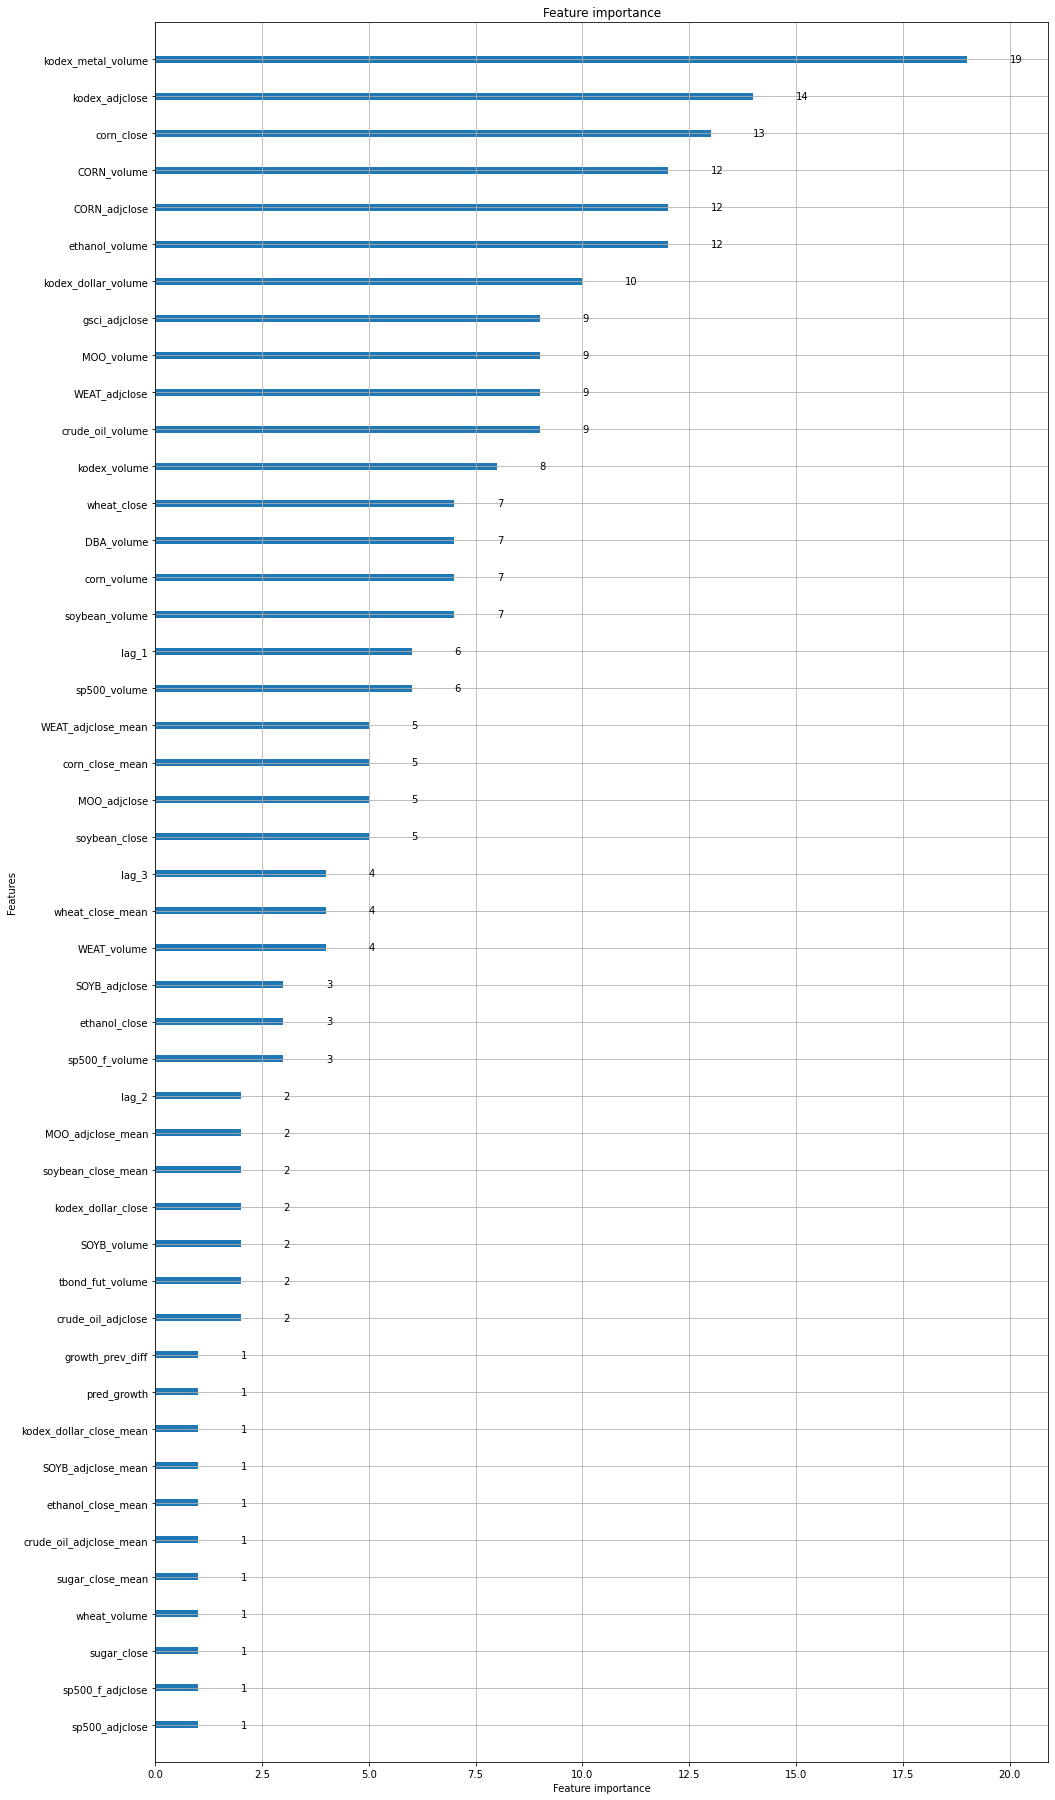

In [118]:
lgb_model2 = LGBMClassifier(**tuner_mod2.best_params_)

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 50)
preds_mod2 = lgb_model2.predict(X_test_mod2, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32))

`피쳐 임포턴스 하위 5개 컬럼 제거` 

In [117]:
DATA_PATH='C:/Users/heunj/Desktop/박현진/서울대학교/FIND-A/DB금융경제공모전/code/사용할 데이터프레임/'

input_df_mod1 = pd.read_csv(DATA_PATH+'lag_df1.csv',index_col=0)
input_df_mod2 = pd.read_csv(DATA_PATH+'lag_df2.csv',index_col=0)

In [118]:
'''
정규화도 진행해보자.
'''

# time series에 대해 정규화를 하는게 맞는지 잘 모르겠다. 이것도 일단 실행 안함.

# 정규화 진행

# Scaling 할 컬럼명 저장
df1_cols = [x for x in input_df_mod1.columns]
df1_cols.remove('actual_growth')
df1_cols.remove('pred_growth')
df1_cols.remove('prev_growth')
df1_cols.remove('growth_pred_error')
df1_cols.remove('growth_prev_diff')
df1_cols.remove('tiger_label')

df2_cols = [x for x in input_df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
df2_cols.remove('growth_prev_diff')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def robust_scaling_tiger(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','tiger_label']])

def robust_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','kodex_label']])

input_df_mod1 = robust_scaling_tiger(input_df_mod1,df1_cols)
input_df_mod2 = robust_scaling_kodex(input_df_mod2,df2_cols)


In [119]:
input_df_mod1.drop(['sp500_adjclose_mean', 'sp500_f_adjclose_mean', 'WEAT_adjclose', 'tiger_adjclose_mean', 'CORN_adjclose_mean'],axis=1,inplace=True)
input_df_mod2.drop(['actual_growth', 'prev_growth', 'tbond_fut_adjclose', 'sp500_adjclose_mean', 'CORN_adjclose_mean'],axis=1,inplace=True)

In [120]:
X_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1[input_df_mod1.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1[input_df_mod1.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.679242
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.665147
Model F1 Score :  0.6937269372693727


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

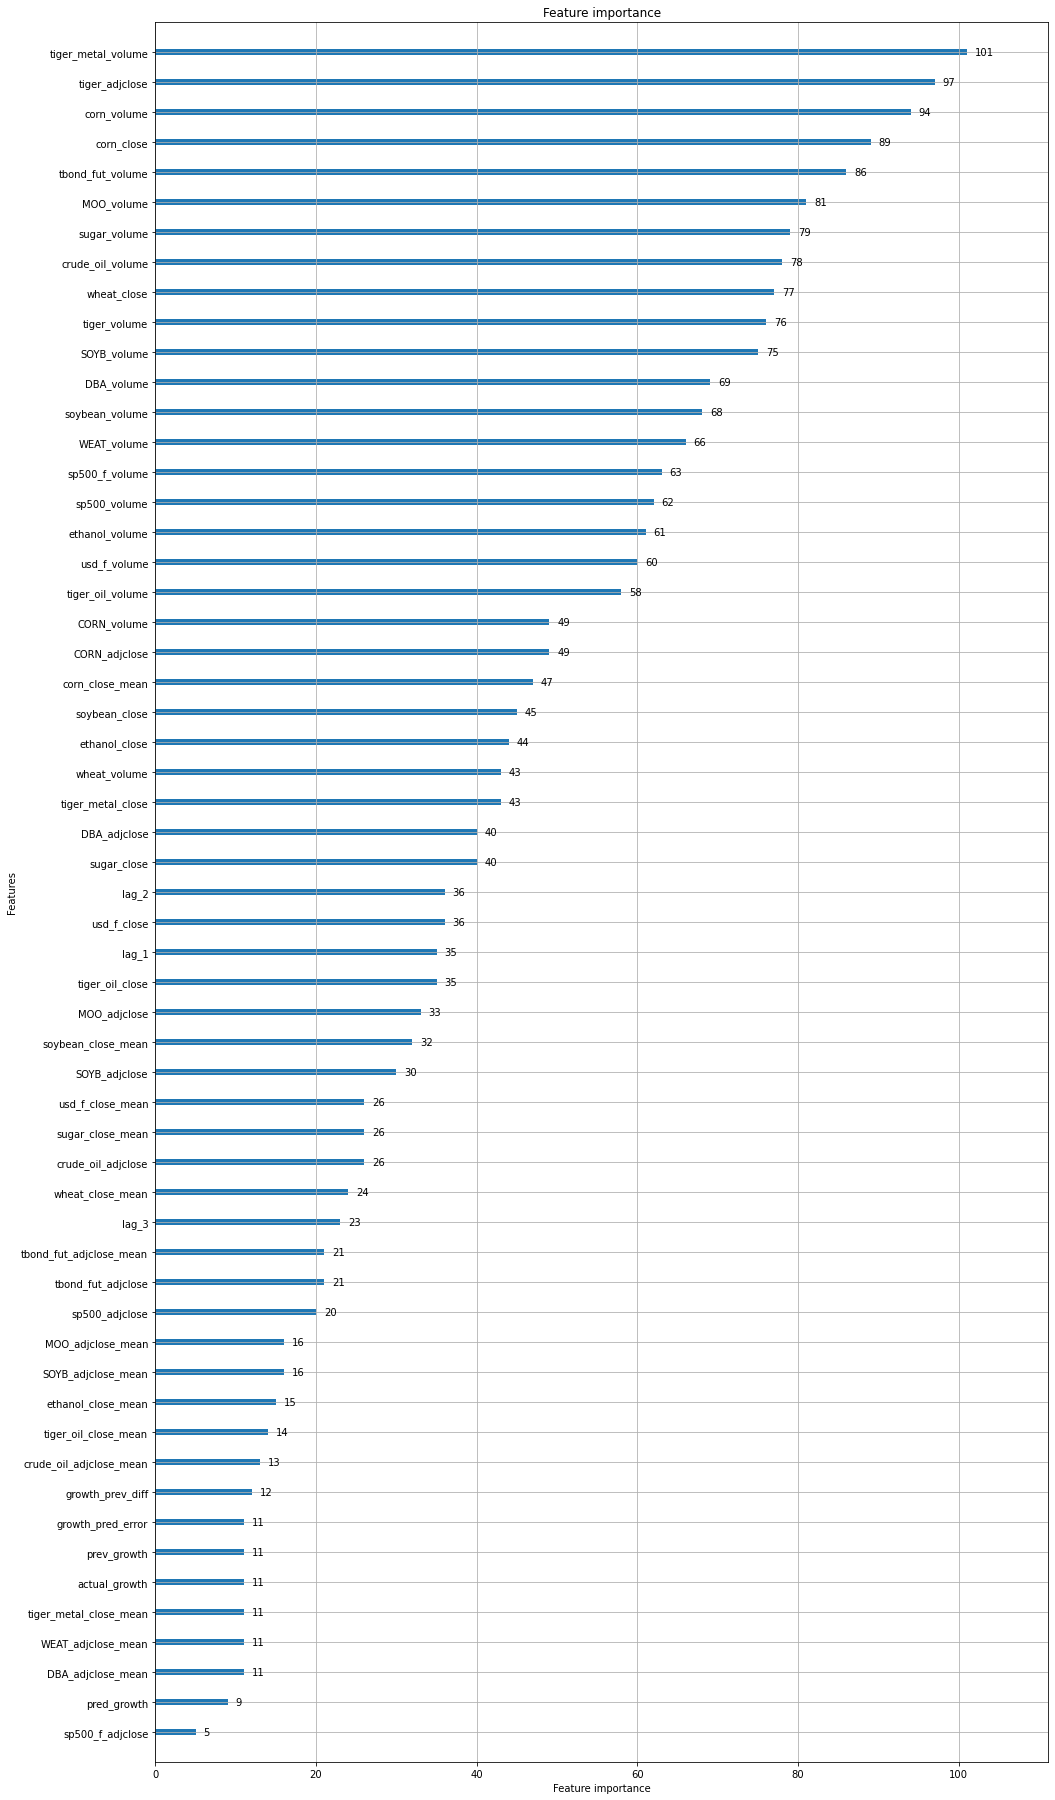

In [121]:
lgb_model1 = LGBMClassifier()

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32),ignore_zero=False)

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.674831
Model F1 Score :  0.6525198938992042


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

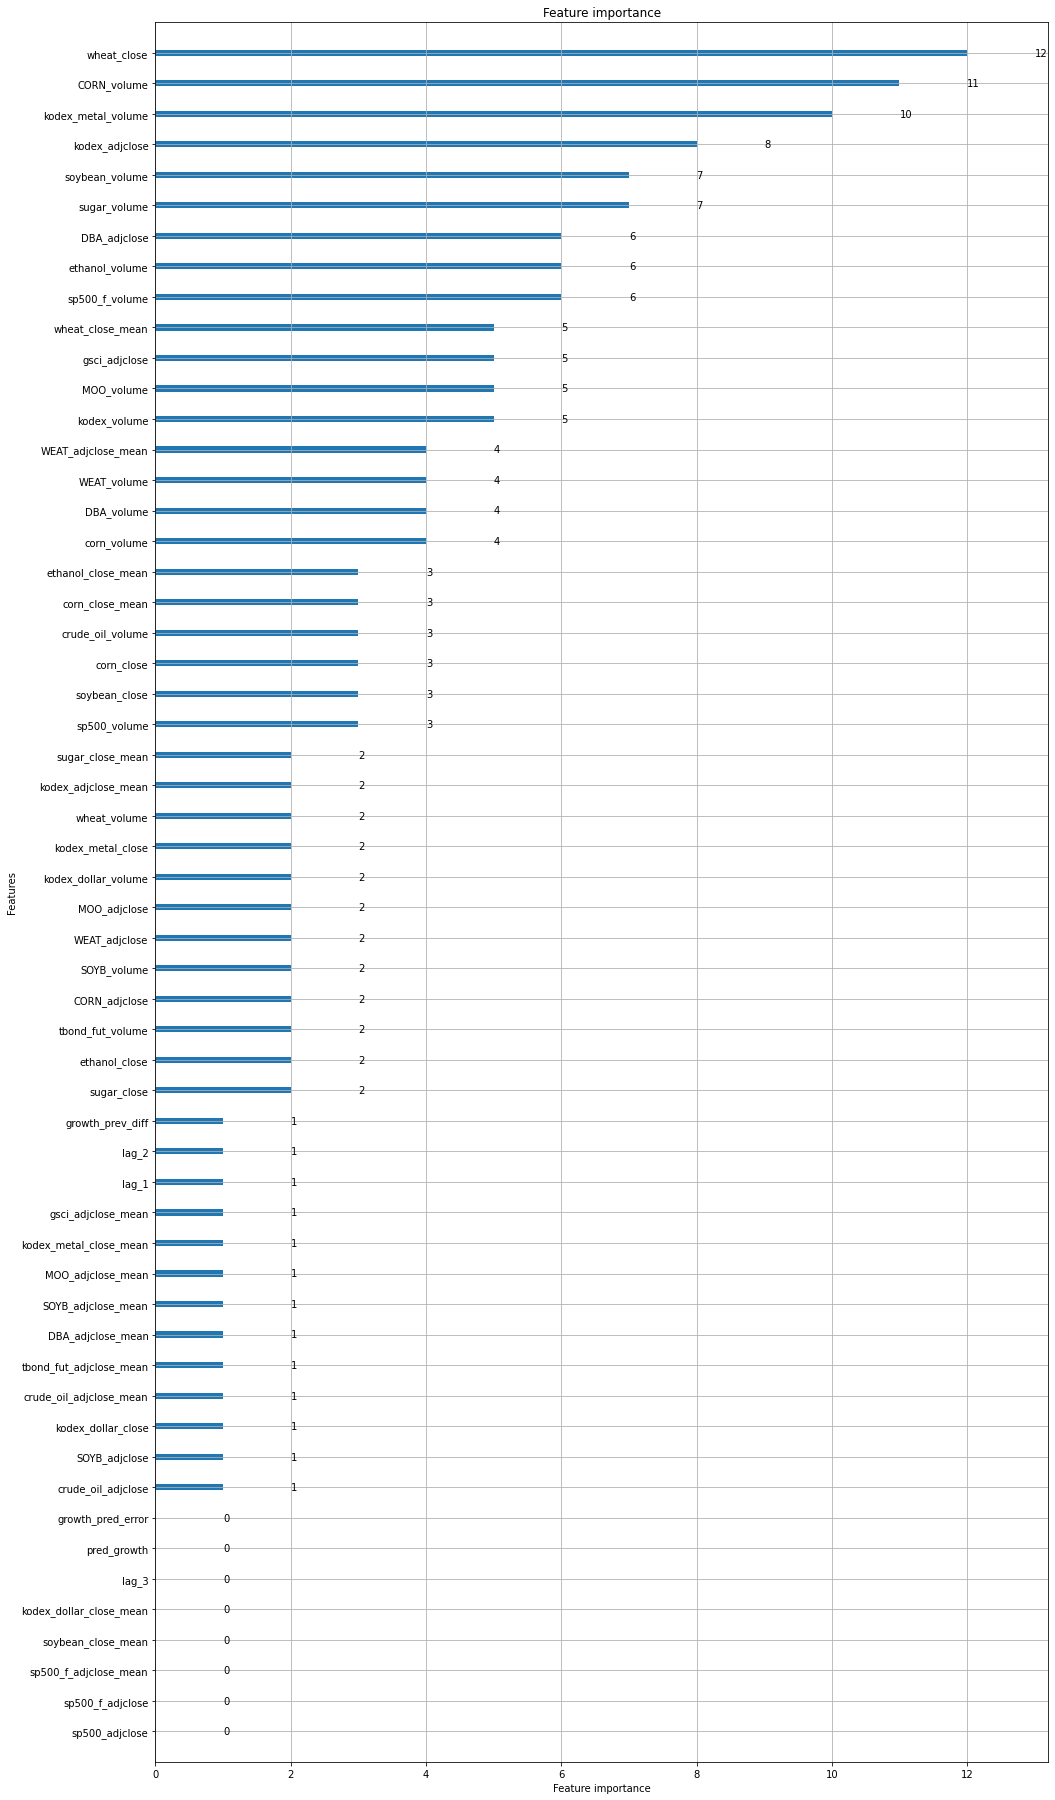

In [122]:
lgb_model2 = LGBMClassifier()

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds=25)
preds_mod2 = lgb_model2.predict(X_test_mod2,axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

In [21]:
# 승한이가 XGBoost 돌려서 튜닝까지 해봄
#input_df_mod1.to_csv('xg_mod1.csv')
#input_df_mod2.to_csv('xg_mod2.csv')

`위 모델로 베이지안 최적화 돌려보기`

In [16]:
from bayes_opt import BayesianOptimization

In [123]:
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

In [124]:
def lgb_f1_eval_mod1(max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model1 = LGBMClassifier(**params)
    lgb_model1.fit(X_train_mod1, y_train_mod1, 
                eval_set=[(X_valid_mod1, y_valid_mod1)],
                eval_metric= 'f1', verbose= 100, 
                early_stopping_rounds= 25)
    test_pred = lgb_model1.predict(X_test_mod1)
    f1_mod1 = f1_score(y_test_mod1, test_pred)
    
    return f1_mod1

In [125]:
def lgb_f1_eval_mod2(max_depth, num_leaves, min_child_samples, min_child_weight,
                subsample, colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model2 = LGBMClassifier(**params)
    lgb_model2.fit(X_train_mod2, y_train_mod2,
                eval_set=[(X_valid_mod2, y_valid_mod2)],
                eval_metric= 'f1', verbose= 100, 
                early_stopping_rounds= 25)
    test_pred = lgb_model2.predict(X_test_mod2)
    f1_mod2 = f1_score(y_test_mod2, test_pred)
    
    return f1_mod2

In [126]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO_mod1 = BayesianOptimization(lgb_f1_eval_mod1,bayesian_params ,random_state=42)
lgbBO_mod2 = BayesianOptimization(lgb_f1_eval_mod2,bayesian_params , random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO_mod1.maximize(init_points=5, n_iter=25)
lgbBO_mod2.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.680678
[200]	valid_0's binary_logloss: 0.676337
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.675716
|  1        |  0.6551   |  0.6873   |  475.9    |  13.32    |  123.7    |  8.645    |  30.24    |  2.914    |  8.662    |  0.8006   |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.687142
[200]	valid_0's binary_logloss: 0.682364
[300]	valid_0's binary_logloss: 0.67953
[400]	valid_0's binary_logloss: 0.678058
Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.677742
|  2        |  0.6559   |  0.854    |  20.09    |  15.7     |  168.2    |  11.4     |  31.27    |  9.178    |  3.043    |  0.7624   |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.691477
|  3        |  0.5688   |  0.716    |  152.7    |  12.12    |  36.5     |  15.32    |  38.65    |  22.81    |  7.852    |  0.5998   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  4        |  0.0      |  0.7571   |  300.3    |  6.465    |  125.4    |  9.356    |  26.6     |  47.44    |  9.656    |  0.9042   |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.683375
[200]	valid_0's binary_logloss: 0.678624
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.678166
|  5        |  0.5933   |  0.6523   |  57.86    |  12.84    |  93.63    |  6.98     |  43.81    |  1.729    |  9.093    |  0.6294   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.68769
[200]	valid_0's binary_logloss: 0.684416
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.684283
|  6        |  0.5845   |  0.9849   |  11.06    |  12.34    |  160.1    |  14.72    |  28.68    |  1.228    |  0.745    |  0.7715   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.686524
[200]	valid_0's binary_logloss: 0.681431
Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.680779
|  7        |  0.6628   |  0.8895   |  58.81    |  14.66    |  98.38    |  13.14    |  45.05    |  12.88    |  7.977    |  0.6609   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  8        |  0.0      |  1.0      |  84.48    |  16.0     |  168.4    |  45.92    |  64.0     |  50.0     |  10.0     |  0.7923   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  9        |  0.0      |  1.0      |  65.42    |  16.0     |  56.69    |  21.06    |  28.43    |  50.0     |  0.001    |  0.7476   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.692579
|  10       |  0.6376   |  0.6281   |  157.0    |  12.02    |  38.82    |  20.82    |  40.69    |  28.29    |  7.614    |  0.6852   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.680529
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.67811
|  11       |  0.6641   |  0.6846   |  473.1    |  12.06    |  122.3    |  10.44    |  37.04    |  1.606    |  2.428    |  0.9518   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  12       |  0.0      |  0.5      |  195.5    |  11.49    |  24.75    |  50.0     |  62.24    |  45.89    |  9.396    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693357
|  13       |  0.0      |  0.6747   |  35.96    |  9.275    |  129.9    |  11.14    |  62.66    |  12.87    |  5.301    |  0.7736   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.693266
|  14       |  0.0      |  0.8115   |  11.62    |  9.044    |  194.2    |  22.12    |  24.86    |  6.114    |  4.085    |  0.7707   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.679992
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.678396
|  15       |  0.7002   |  0.6171   |  467.6    |  10.54    |  120.9    |  3.967    |  37.14    |  1.63     |  3.985    |  0.8275   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.684126
[200]	valid_0's binary_logloss: 0.678027
[300]	valid_0's binary_logloss: 0.675501
Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.675231
|  16       |  0.6463   |  0.5      |  475.3    |  7.136    |  92.17    |  1.0      |  36.74    |  7.55     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.69318
|  17       |  0.4752   |  0.8729   |  466.3    |  9.867    |  116.2    |  1.0      |  44.09    |  33.15    |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.684257
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.68089
|  18       |  0.6365   |  0.5      |  449.8    |  16.0     |  101.9    |  16.52    |  24.0     |  0.01     |  7.543    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.693129
|  19       |  0.1532   |  0.5433   |  56.52    |  13.17    |  103.3    |  16.82    |  40.2     |  9.436    |  7.251    |  0.5059   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.692246
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.692218
|  20       |  0.6298   |  0.7453   |  66.79    |  13.93    |  101.4    |  8.296    |  54.99    |  22.08    |  7.593    |  0.8975   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682845
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.682321
|  21       |  0.6718   |  0.514    |  471.3    |  14.09    |  120.8    |  10.62    |  32.89    |  1.398    |  6.556    |  0.8144   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.693388
|  22       |  0.0      |  1.0      |  59.5     |  16.0     |  84.25    |  8.425    |  51.17    |  16.84    |  10.0     |  0.9011   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681812
[200]	valid_0's binary_logloss: 0.677524
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.677296
|  23       |  0.6436   |  0.6916   |  474.0    |  9.271    |  109.6    |  4.314    |  35.28    |  5.383    |  7.095    |  0.7366   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.683377
[200]	valid_0's binary_logloss: 0.680713
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.679857
|  24       |  0.6173   |  0.633    |  462.9    |  13.26    |  109.9    |  4.723    |  47.29    |  4.005    |  2.236    |  0.8025   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.686862
[200]	valid_0's binary_logloss: 0.680402
[300]	valid_0's binary_logloss: 0.677743
[400]	valid_0's binary_logloss: 0.675038
Early stopping, best iteration is:
[461]	valid_0's binary_logloss: 0.673925
|  25       |  0.651    |  1.0      |  470.6    |  16.0     |  120.3    |  5.333    |  41.97    |  11.47    |  10.0     |  1.0      |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.685713
[200]	valid_0's binary_logloss: 0.67811
Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.676531
|  26       |  0.6746   |  0.9853   |  454.3    |  10.14    |  107.0    |  5.312    |  25.89    |  10.59    |  9.87     |  0.589    |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.687081
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.686584
|  27       |  0.6615   |  0.5      |  461.4    |  16.0     |  100.6    |  4.964    |  32.68    |  0.4645   |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.693214
|  28       |  0.0      |  1.0      |  67.73    |  16.0     |  104.0    |  2.169    |  49.09    |  8.758    |  7.518    |  0.7364   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.690056
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.688019
|  29       |  0.6575   |  0.5272   |  466.7    |  11.65    |  108.3    |  6.9      |  36.41    |  17.2     |  2.884    |  0.6598   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.688531
[200]	valid_0's binary_logloss: 0.682928
[300]	valid_0's binary_logloss: 0.679176
[400]	valid_0's binary_logloss: 0.677158
[500]	valid_0's binary_logloss: 0.675181
Did not meet early stopping. Best iteration is:
[499]	valid_0's binary_logloss: 0.675143
|  30       |  0.6768   |  0.5408   |  463.6    |  15.03    |  112.9    |  2.394    |  29.9     |  11.02    |  4.661    |  0.7112   |
|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.676809


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[200]	valid_0's binary_logloss: 0.668823
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.666339
|  1        |  0.6543   |  0.6873   |  475.9    |  13.32    |  123.7    |  8.645    |  30.24    |  2.914    |  8.662    |  0.8006   |
Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.686263


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[200]	valid_0's binary_logloss: 0.683502
[300]	valid_0's binary_logloss: 0.680886
[400]	valid_0's binary_logloss: 0.679273
Early stopping, best iteration is:
[448]	valid_0's binary_logloss: 0.67887
|  2        |  0.6525   |  0.854    |  20.09    |  15.7     |  168.2    |  11.4     |  31.27    |  9.178    |  3.043    |  0.7624   |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  3        |  0.0      |  0.716    |  152.7    |  12.12    |  36.5     |  15.32    |  38.65    |  22.81    |  7.852    |  0.5998   |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  4        |  0.0      |  0.7571   |  300.3    |  6.465    |  125.4    |  9.356    |  26.6     |  47.44    |  9.656    |  0.9042   |
Training until validation scores don't improve for 25 rounds

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



[100]	valid_0's binary_logloss: 0.67233
[200]	valid_0's binary_logloss: 0.660004
[300]	valid_0's binary_logloss: 0.6546
[400]	valid_0's binary_logloss: 0.651469
Early stopping, best iteration is:
[375]	valid_0's binary_logloss: 0.651134
|  5        |  0.6413   |  0.6523   |  57.86    |  12.84    |  93.63    |  6.98     |  43.81    |  1.729    |  9.093    |  0.6294   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681574
[200]	valid_0's binary_logloss: 0.675844
[300]	valid_0's binary_logloss: 0.670801
[400]	valid_0's binary_logloss: 0.667886
[500]	valid_0's binary_logloss: 0.665754
Did not meet early stopping. Best iteration is:
[494]	valid_0's binary_logloss: 0.665666
|  6        |  0.6525   |  0.927    |  24.11    |  11.3     |  168.9    |  2.353    |  35.29    |  2.586    |  5.95     |  0.6584   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682312
[200]	valid_0's binary_logloss: 0.679697
[300]	valid_0's binary_logloss: 0.677129
[400]	valid_0's binary_logloss: 0.674024
[500]	valid_0's binary_logloss: 0.670537
Did not meet early stopping. Best iteration is:
[493]	valid_0's binary_logloss: 0.670519
|  7        |  0.6525   |  1.0      |  500.0    |  16.0     |  10.0     |  50.0     |  64.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  8        |  0.0      |  0.5      |  500.0    |  6.0      |  200.0    |  50.0     |  64.0     |  50.0     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  9        |  0.0      |  1.0      |  500.0    |  6.0      |  38.91    |  1.0      |  24.0     |  50.0     |  10.0     |  0.5      |
Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.684798
[200]	valid_0's binary_logloss: 0.67901
[300]	valid_0's binary_logloss: 0.673697
[400]	valid_0's binary_logloss: 0.669747
[500]	valid_0's binary_logloss: 0.668203
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.668203
|  10       |  0.6525   |  0.8664   |  20.04    |  6.949    |  166.8    |  16.35    |  36.48    |  5.422    |  4.374    |  0.8031   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  11       |  0.0      |  0.5      |  69.85    |  16.0     |  157.2    |  11.27    |  64.0     |  50.0     |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.667859
Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.658895
|  12       |  0.6543   |  1.0      |  10.0     |  7.357    |  114.4    |  1.0      |  24.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682271
[200]	valid_0's binary_logloss: 0.678593
[300]	valid_0's binary_logloss: 0.676579
[400]	valid_0's binary_logloss: 0.675151
Early stopping, best iteration is:
[430]	valid_0's binary_logloss: 0.674045
|  13       |  0.6462   |  0.5      |  10.0     |  16.0     |  72.29    |  50.0     |  50.36    |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.665549
|  14       |  0.627    |  1.0      |  11.4     |  6.0      |  28.6     |  1.0      |  24.0     |  0.01     |  0.2873   |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682487
[200]	valid_0's binary_logloss: 0.677159
[300]	valid_0's binary_logloss: 0.673647
[400]	valid_0's binary_logloss: 0.671575
[500]	valid_0's binary_logloss: 0.669336
Did not meet early stopping. Best iteration is:
[499]	valid_0's binary_logloss: 0.669252
|  15       |  0.6525   |  0.6298   |  25.32    |  8.371    |  165.3    |  23.04    |  29.68    |  4.104    |  8.882    |  0.9831   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682808
[200]	valid_0's binary_logloss: 0.679613
Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.678341
|  16       |  0.6525   |  0.8388   |  429.3    |  16.0     |  70.63    |  50.0     |  64.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682308
[200]	valid_0's binary_logloss: 0.678566
[300]	valid_0's binary_logloss: 0.676455
[400]	valid_0's binary_logloss: 0.674927
[500]	valid_0's binary_logloss: 0.670813
Did not meet early stopping. Best iteration is:
[497]	valid_0's binary_logloss: 0.670691
|  17       |  0.6525   |  1.0      |  381.0    |  6.0      |  10.0     |  50.0     |  64.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681455
[200]	valid_0's binary_logloss: 0.679869
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.67912
|  18       |  0.6525   |  0.5      |  431.8    |  16.0     |  10.0     |  50.0     |  24.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.673221
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.667365
|  19       |  0.6543   |  0.8493   |  60.24    |  14.14    |  86.64    |  4.556    |  40.59    |  1.564    |  5.76     |  0.7827   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  20       |  0.0      |  0.7616   |  10.26    |  11.66    |  13.13    |  31.48    |  61.77    |  46.15    |  7.018    |  0.5751   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.675971
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.672942
|  21       |  0.6525   |  0.514    |  471.3    |  14.09    |  120.8    |  10.62    |  32.89    |  1.398    |  6.556    |  0.8144   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.684127
[200]	valid_0's binary_logloss: 0.681056
[300]	valid_0's binary_logloss: 0.679321
[400]	valid_0's binary_logloss: 0.677872
[500]	valid_0's binary_logloss: 0.67674
Did not meet early stopping. Best iteration is:
[499]	valid_0's binary_logloss: 0.676739
|  22       |  0.6525   |  0.9295   |  24.71    |  15.93    |  173.2    |  12.53    |  34.84    |  6.343    |  4.075    |  0.7059   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.686853
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.684488
|  23       |  0.6543   |  1.0      |  419.3    |  16.0     |  10.0     |  1.0      |  64.0     |  0.01     |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.674029
[200]	valid_0's binary_logloss: 0.664328
Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.66342
|  24       |  0.6543   |  0.6954   |  465.9    |  10.17    |  116.8    |  14.45    |  31.75    |  0.5638   |  9.339    |  0.8051   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.683626
[200]	valid_0's binary_logloss: 0.679556
[300]	valid_0's binary_logloss: 0.677159
[400]	valid_0's binary_logloss: 0.673995
[500]	valid_0's binary_logloss: 0.671228
Did not meet early stopping. Best iteration is:
[496]	valid_0's binary_logloss: 0.6712
|  25       |  0.6525   |  1.0      |  412.5    |  16.0     |  200.0    |  1.0      |  24.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.665709
|  26       |  0.6525   |  1.0      |  347.0    |  16.0     |  10.0     |  1.0      |  24.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682365
[200]	valid_0's binary_logloss: 0.678326
[300]	valid_0's binary_logloss: 0.674336
[400]	valid_0's binary_logloss: 0.671364
[500]	valid_0's binary_logloss: 0.668145
Did not meet early stopping. Best iteration is:
[498]	valid_0's binary_logloss: 0.668121
|  27       |  0.6507   |  0.9858   |  26.72    |  13.43    |  171.3    |  13.85    |  30.77    |  2.12     |  7.14     |  0.6143   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  28       |  0.0      |  1.0      |  317.9    |  16.0     |  10.0     |  50.0     |  64.0     |  50.0     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.675834
[200]	valid_0's binary_logloss: 0.661503
[300]	valid_0's binary_logloss: 0.655337
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.654889
|  29       |  0.6525   |  1.0      |  393.5    |  16.0     |  79.28    |  1.0      |  24.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.677231
[200]	valid_0's binary_logloss: 0.673132
[300]	valid_0's binary_logloss: 0.666914
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.665311
|  30       |  0.6577   |  0.7991   |  474.5    |  15.71    |  127.5    |  12.56    |  32.65    |  4.185    |  3.793    |  0.6782   |


In [ ]:
# BayesianOptimization객체의 res는 iteration 수행 시마다 모든 함수 반환결과와 그때의 파라미터 결과값을 가지고 있음. 
print(lgbBO_mod1.res)
print(lgbBO_mod2.res)

In [127]:
# dictionary에 있는 target값을 모두 추출
target_list_mod1 = []
for result in lgbBO_mod1.res:
    target = result['target']
    target_list_mod1.append(target)
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict_mod1 = lgbBO_mod1.res[np.argmax(np.array(target_list_mod1))]

target_list_mod2 = []
for result in lgbBO_mod2.res:
    target = result['target']
    target_list_mod2.append(target)
max_dict_mod2 = lgbBO_mod2.res[np.argmax(np.array(target_list_mod2))]

In [128]:
max_dict_mod1['params']

{'colsample_bytree': 0.617113752116202,
 'max_bin': 467.5970695685513,
 'max_depth': 10.535046868272017,
 'min_child_samples': 120.87635595666313,
 'min_child_weight': 3.966836500335938,
 'num_leaves': 37.14400427664937,
 'reg_alpha': 1.6299608958358578,
 'reg_lambda': 3.9851768841980264,
 'subsample': 0.8274998115292258}

In [129]:
max_dict_mod2['params']

{'colsample_bytree': 0.7991228164876042,
 'max_bin': 474.52458251720276,
 'max_depth': 15.706784976364936,
 'min_child_samples': 127.5164202362338,
 'min_child_weight': 12.562246725958996,
 'num_leaves': 32.64799352849141,
 'reg_alpha': 4.184709779940802,
 'reg_lambda': 3.7928659546535837,
 'subsample': 0.6782351543504945}

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.679992
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.678396
Model F1 Score :  0.7001862197392924


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

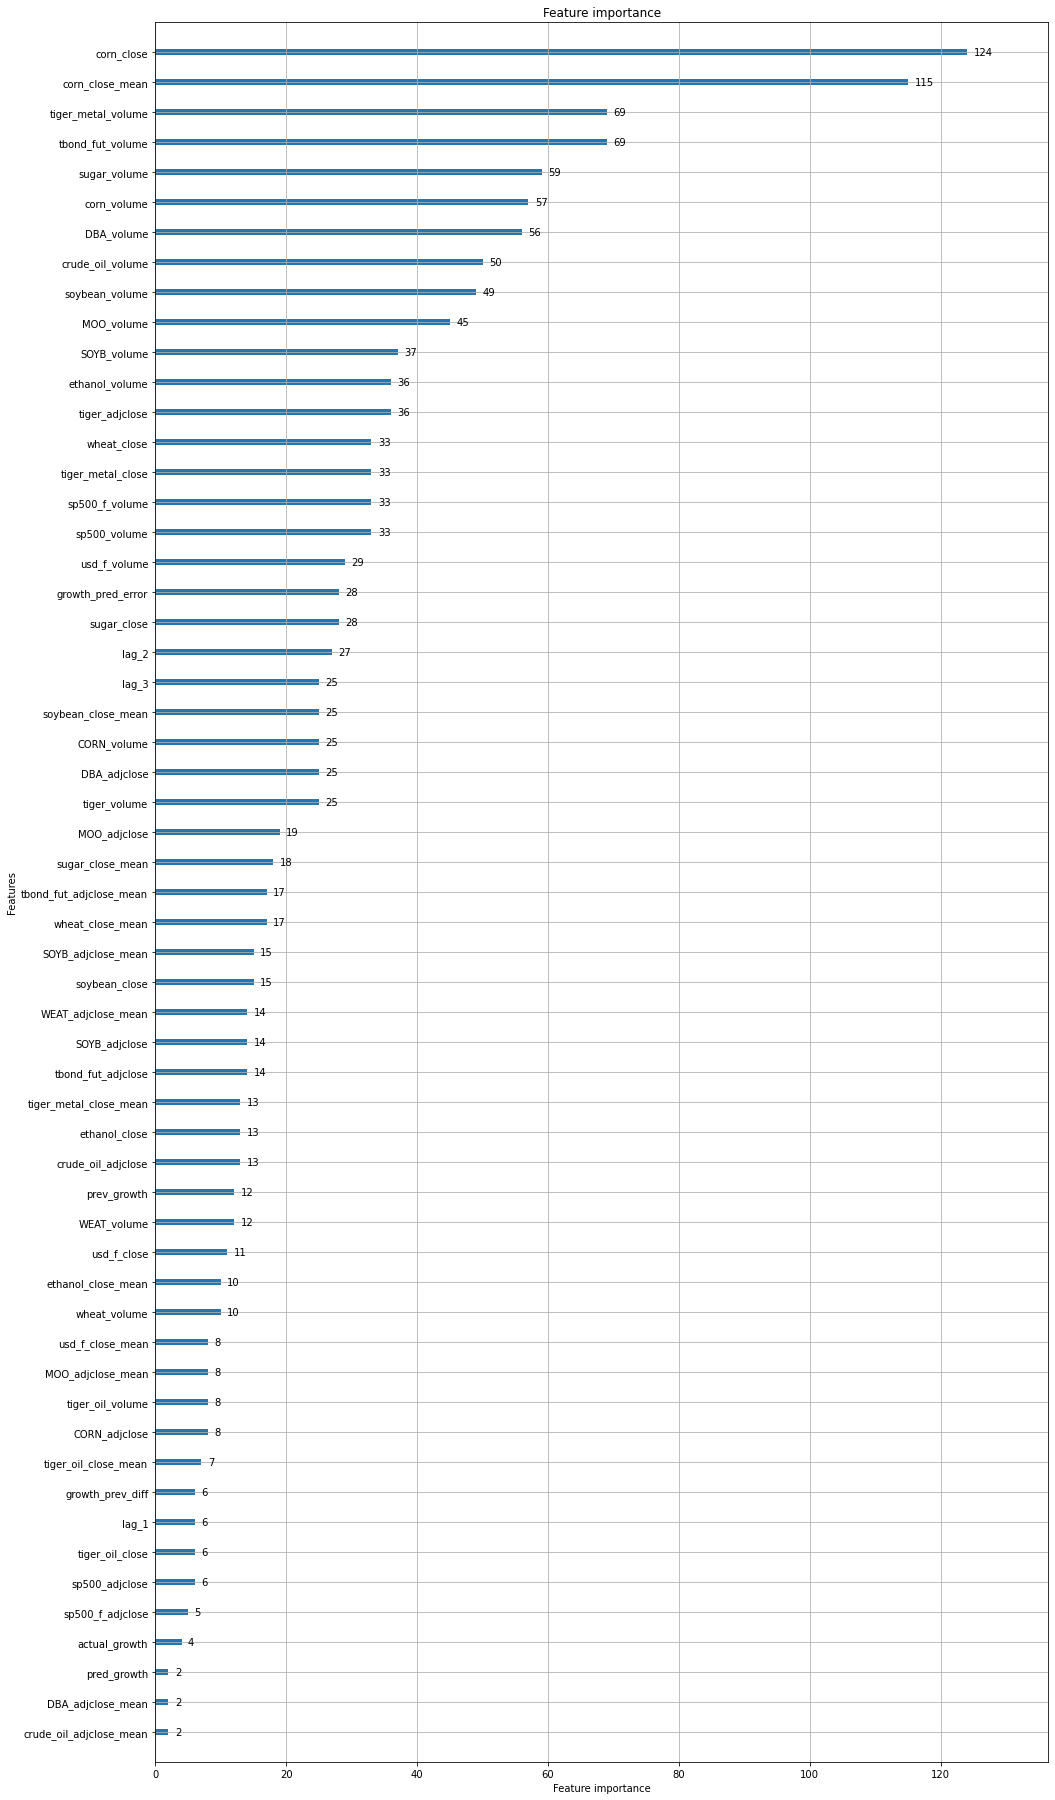

In [130]:
lgb_model1 = LGBMClassifier(n_estimators=500, learning_rate=0.02,
colsample_bytree= 0.617,
max_bin= 468,
max_depth= 11,
min_child_samples= 121,
min_child_weight= 4,
num_leaves= 37,
reg_alpha= 1.630,
reg_lambda= 3.985,
subsample= 0.827)

lgb_model1.fit(X_train_mod1, y_train_mod1,eval_set=[(X_valid_mod1, y_valid_mod1)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod1 = lgb_model1.predict(X_test_mod1, axis=1)

print("Model F1 Score : ",f1_score(y_test_mod1, preds_mod1))
plot_importance(lgb_model1, figsize=(16, 32),ignore_zero=False)

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.677231
[200]	valid_0's binary_logloss: 0.673132
[300]	valid_0's binary_logloss: 0.666914
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.665312
Model F1 Score :  0.6576819407008085


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

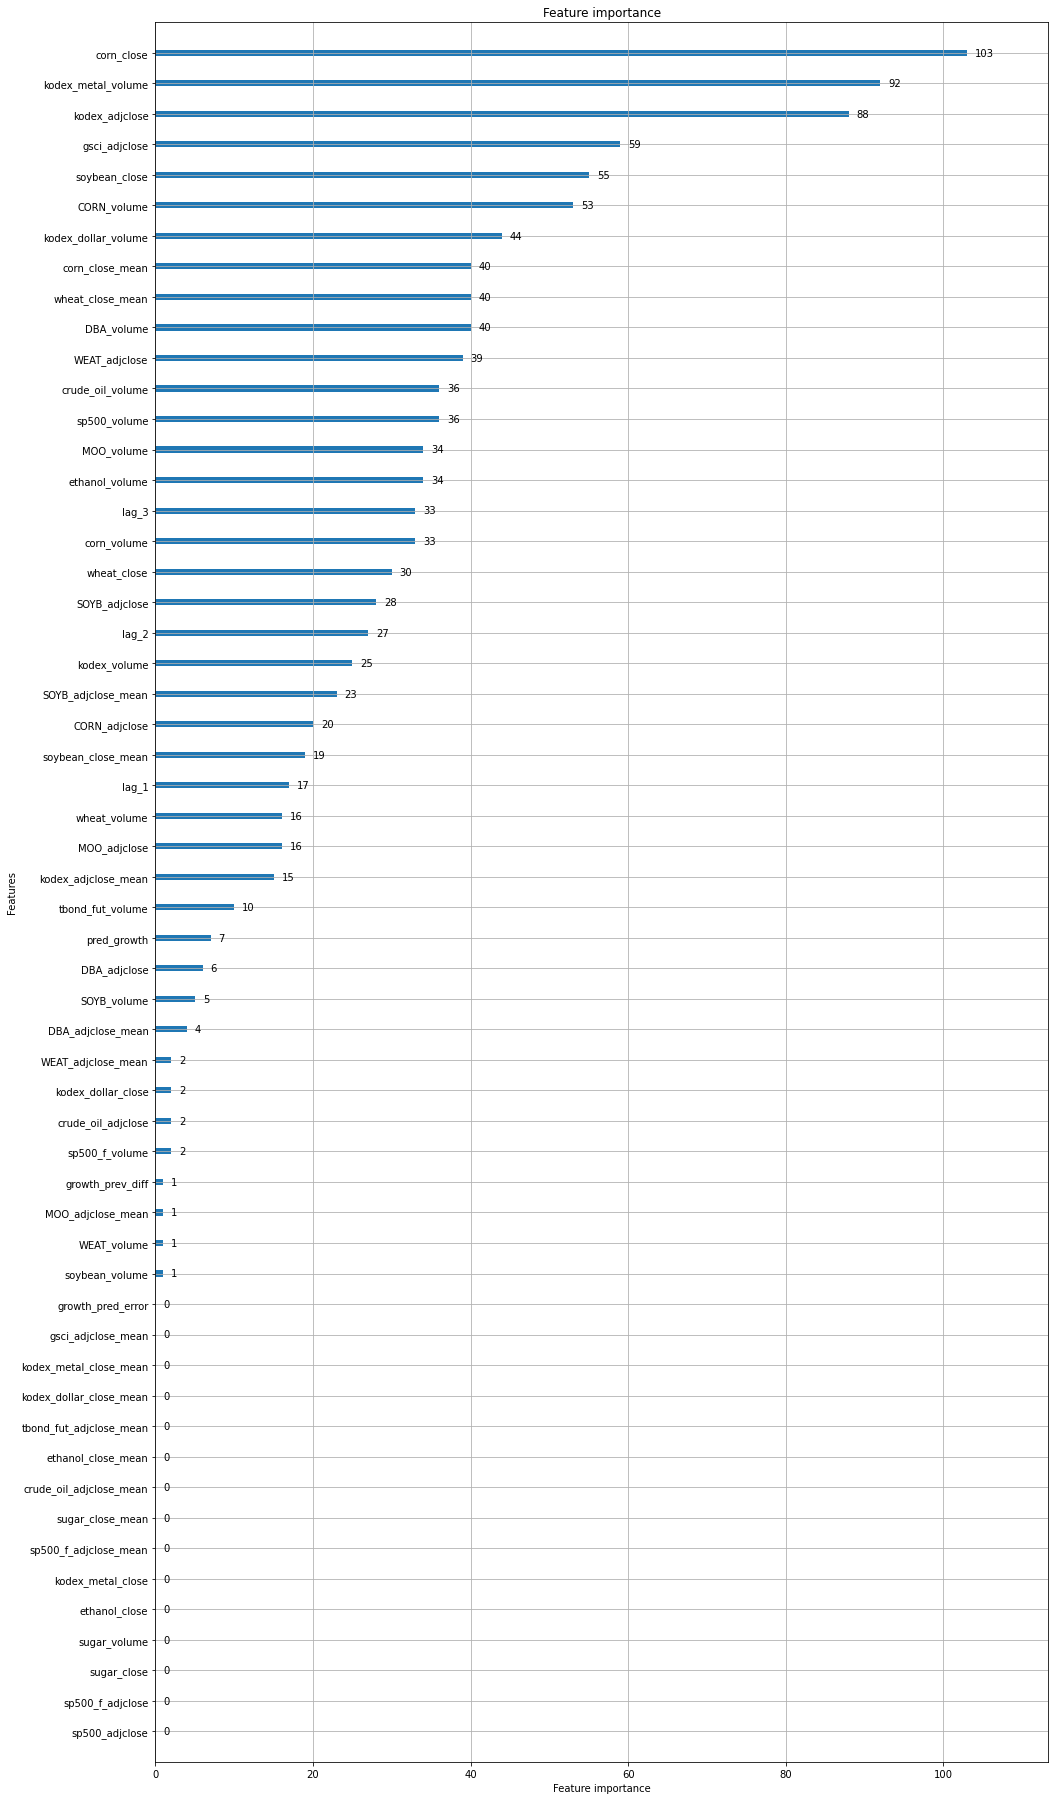

In [131]:
lgb_model2 = LGBMClassifier(n_estimators=500, learning_rate=0.02,
colsample_bytree= 0.799,
max_bin= 475,
max_depth= 16,
min_child_samples= 128,
min_child_weight= 13,
num_leaves= 33,
reg_alpha= 4.185,
reg_lambda= 3.793,
subsample= 0.678)

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod2 = lgb_model2.predict(X_test_mod2,axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

In [45]:
'''
이제 feature importance가 0인 컬럼을 드랍시켜보자.
'''

cond1 = (lgb_model1.feature_importances_==0)
cond2 = (lgb_model2.feature_importances_==0)

useless_feature_mod1 = list(pd.DataFrame(lgb_model1.feature_name_)[cond1][0])
useless_feature_mod2 = list(pd.DataFrame(lgb_model2.feature_name_)[cond2][0])

In [46]:
useless_feature_mod1

[]

In [47]:
useless_feature_mod2

['sp500_adjclose',
 'sp500_f_adjclose',
 'sugar_close',
 'sugar_volume',
 'ethanol_close',
 'kodex_metal_close',
 'sp500_f_adjclose_mean',
 'sugar_close_mean',
 'crude_oil_adjclose_mean',
 'ethanol_close_mean',
 'tbond_fut_adjclose_mean',
 'kodex_dollar_close_mean',
 'kodex_metal_close_mean',
 'gsci_adjclose_mean',
 'growth_pred_error']

In [48]:
input_df_mod1_rev = input_df_mod1.drop(useless_feature_mod1,axis=1)
input_df_mod2_rev = input_df_mod2.drop(useless_feature_mod2,axis=1)


In [49]:
'''
이걸로 베이지안 최적화 후 모델 돌려보자.
'''

'\n이걸로 베이지안 최적화 후 모델 돌려보자.\n'

In [50]:
X_temp_mod1 = input_df_mod1_rev[input_df_mod1_rev.index <= '2020-07-01'].drop(['tiger_label'],axis=1)
y_temp_mod1 = input_df_mod1_rev[input_df_mod1_rev.index <= '2020-07-01'][['tiger_label']]
X_train_mod1, X_valid_mod1, y_train_mod1, y_valid_mod1 = train_test_split(X_temp_mod1, y_temp_mod1, test_size=0.1, random_state=42)
X_test_mod1 = input_df_mod1_rev[input_df_mod1_rev.index > '2020-07-01'].drop(['tiger_label'],axis=1)
y_test_mod1 = input_df_mod1_rev[input_df_mod1_rev.index > '2020-07-01'][['tiger_label']]

X_temp_mod2 = input_df_mod2_rev[input_df_mod2_rev.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2_rev[input_df_mod2_rev.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2_rev[input_df_mod2_rev.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2_rev[input_df_mod2_rev.index > '2020-12-31'][['kodex_label']]

bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}
def lgb_f1_eval_mod1(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model1 = LGBMClassifier(**params)
    lgb_model1.fit(X_train_mod1, y_train_mod1, eval_set=[(X_valid_mod1, y_valid_mod1)], eval_metric= 'f1', verbose= 100, 
                early_stopping_rounds= 25)
    test_pred = lgb_model1.predict(X_test_mod1)
    f1_mod1 = f1_score(y_test_mod1, test_pred)
    
    return f1_mod1

def lgb_f1_eval_mod2(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model2 = LGBMClassifier(**params)
    lgb_model2.fit(X_train_mod2, y_train_mod2, eval_set=[(X_valid_mod2, y_valid_mod2)], eval_metric= 'f1', verbose= 100, 
                early_stopping_rounds= 25)
    test_pred = lgb_model2.predict(X_test_mod2)
    f1_mod2 = f1_score(y_test_mod2, test_pred)
    
    return f1_mod2

# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO_mod1 = BayesianOptimization(lgb_f1_eval_mod1,bayesian_params , random_state=42)
lgbBO_mod2 = BayesianOptimization(lgb_f1_eval_mod2,bayesian_params , random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO_mod1.maximize(init_points=5, n_iter=25)
lgbBO_mod2.maximize(init_points=5, n_iter=25)

# dictionary에 있는 target값을 모두 추출
target_list_mod1 = []
for result in lgbBO_mod1.res:
    target = result['target']
    target_list_mod1.append(target)
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict_mod1 = lgbBO_mod1.res[np.argmax(np.array(target_list_mod1))]

target_list_mod2 = []
for result in lgbBO_mod2.res:
    target = result['target']
    target_list_mod2.append(target)
max_dict_mod2 = lgbBO_mod2.res[np.argmax(np.array(target_list_mod2))]

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.680678
[200]	valid_0's binary_logloss: 0.676337
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.675716
|  1        |  0.6551   |  0.6873   |  475.9    |  13.32    |  123.7    |  8.645    |  30.24    |  2.914    |  8.662    |  0.8006   |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.687142
[200]	valid_0's binary_logloss: 0.682364
[300]	valid_0's binary_logloss: 0.67953
[400]	valid_0's binary_logloss: 0.678058
Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.677742
|  2        |  0.6559   |  0.854    |  20.09    |  15.7     |  168.2    |  11.4     |  31.27    |  9.178    |  3.043    |  0.7624   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.691477
|  3        |  0.5688   |  0.716    |  152.7    |  12.12    |  36.5     |  15.32    |  38.65    |  22.81    |  7.852    |  0.5998   |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  4        |  0.0      |  0.7571   |  300.3    |  6.465    |  125.4    |  9.356    |  26.6     |  47.44    |  9.656    |  0.9042   |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.683375
[200]	valid_0's binary_logloss: 0.678624
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.678166
|  5        |  0.5933   |  0.6523   |  57.86    |  12.84    |  93.63    |  6.98     |  43.81    |  1.729    |  9.093    |  0.6294   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.68769
[200]	valid_0's binary_logloss: 0.684416
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.684283
|  6        |  0.5845   |  0.9849   |  11.06    |  12.34    |  160.1    |  14.72    |  28.68    |  1.228    |  0.745    |  0.7715   |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.686524
[200]	valid_0's binary_logloss: 0.681431
Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.680779
|  7        |  0.6628   |  0.8895   |  58.81    |  14.66    |  98.38    |  13.14    |  45.05    |  12.88    |  7.977    |  0.6609   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  8        |  0.0      |  1.0      |  84.48    |  16.0     |  168.4    |  45.92    |  64.0     |  50.0     |  10.0     |  0.7923   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  9        |  0.0      |  1.0      |  65.42    |  16.0     |  56.69    |  21.06    |  28.43    |  50.0     |  0.001    |  0.7476   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.692579
|  10       |  0.6376   |  0.6281   |  157.0    |  12.02    |  38.82    |  20.82    |  40.69    |  28.29    |  7.614    |  0.6852   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.680529
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.67811
|  11       |  0.6641   |  0.6846   |  473.1    |  12.06    |  122.3    |  10.44    |  37.04    |  1.606    |  2.428    |  0.9518   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.694095
|  12       |  0.0      |  0.5      |  195.5    |  11.49    |  24.75    |  50.0     |  62.24    |  45.89    |  9.396    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693357
|  13       |  0.0      |  0.6747   |  35.96    |  9.275    |  129.9    |  11.14    |  62.66    |  12.87    |  5.301    |  0.7736   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.693266
|  14       |  0.0      |  0.8115   |  11.62    |  9.044    |  194.2    |  22.12    |  24.86    |  6.114    |  4.085    |  0.7707   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.679992
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.678396
|  15       |  0.7002   |  0.6171   |  467.6    |  10.54    |  120.9    |  3.967    |  37.14    |  1.63     |  3.985    |  0.8275   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.684126
[200]	valid_0's binary_logloss: 0.678027
[300]	valid_0's binary_logloss: 0.675501
Early stopping, best iteration is:
[307]	valid_0's binary_logloss: 0.675231
|  16       |  0.6463   |  0.5      |  475.3    |  7.136    |  92.17    |  1.0      |  36.74    |  7.55     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.69318
|  17       |  0.4752   |  0.8729   |  466.3    |  9.867    |  116.2    |  1.0      |  44.09    |  33.15    |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.684257
Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.68089
|  18       |  0.6365   |  0.5      |  449.8    |  16.0     |  101.9    |  16.52    |  24.0     |  0.01     |  7.543    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.693129
|  19       |  0.1532   |  0.5433   |  56.52    |  13.17    |  103.3    |  16.82    |  40.2     |  9.436    |  7.251    |  0.5059   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.692246
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.692218
|  20       |  0.6298   |  0.7453   |  66.79    |  13.93    |  101.4    |  8.296    |  54.99    |  22.08    |  7.593    |  0.8975   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682845
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.682321
|  21       |  0.6718   |  0.514    |  471.3    |  14.09    |  120.8    |  10.62    |  32.89    |  1.398    |  6.556    |  0.8144   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.693388
|  22       |  0.0      |  1.0      |  59.5     |  16.0     |  84.25    |  8.425    |  51.17    |  16.84    |  10.0     |  0.9011   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681812
[200]	valid_0's binary_logloss: 0.677524
Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.677296
|  23       |  0.6436   |  0.6916   |  474.0    |  9.271    |  109.6    |  4.314    |  35.28    |  5.383    |  7.095    |  0.7366   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.683377
[200]	valid_0's binary_logloss: 0.680713
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.679857
|  24       |  0.6173   |  0.633    |  462.9    |  13.26    |  109.9    |  4.723    |  47.29    |  4.005    |  2.236    |  0.8025   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.686862
[200]	valid_0's binary_logloss: 0.680402
[300]	valid_0's binary_logloss: 0.677743
[400]	valid_0's binary_logloss: 0.675038
Early stopping, best iteration is:
[461]	valid_0's binary_logloss: 0.673925
|  25       |  0.651    |  1.0      |  470.6    |  16.0     |  120.3    |  5.333    |  41.97    |  11.47    |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.685713
[200]	valid_0's binary_logloss: 0.67811
Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.676531
|  26       |  0.6746   |  0.9853   |  454.3    |  10.14    |  107.0    |  5.312    |  25.89    |  10.59    |  9.87     |  0.589    |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.687081
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.686584
|  27       |  0.6615   |  0.5      |  461.4    |  16.0     |  100.6    |  4.964    |  32.68    |  0.4645   |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.693214
|  28       |  0.0      |  1.0      |  67.73    |  16.0     |  104.0    |  2.169    |  49.09    |  8.758    |  7.518    |  0.7364   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.690056
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.688019
|  29       |  0.6575   |  0.5272   |  466.7    |  11.65    |  108.3    |  6.9      |  36.41    |  17.2     |  2.884    |  0.6598   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.688531
[200]	valid_0's binary_logloss: 0.682928
[300]	valid_0's binary_logloss: 0.679176
[400]	valid_0's binary_logloss: 0.677158
[500]	valid_0's binary_logloss: 0.675181
Did not meet early stopping. Best iteration is:
[499]	valid_0's binary_logloss: 0.675143
|  30       |  0.6768   |  0.5408   |  463.6    |  15.03    |  112.9    |  2.394    |  29.9     |  11.02    |  4.661    |  0.7112   |
|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.677663
[200]	valid_0's binary_logloss: 0.671996
[300]	valid_0's binary_logloss: 0.666646
Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.665997
|  1        |  0.6543   |  0.6873   |  475.9    |  13.32    |  123.7    |  8.645    |  30.24    |  2.914    |  8.662    |  0.8006   |
Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.686937
[200]	valid_0's binary_logloss: 0.683733


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[300]	valid_0's binary_logloss: 0.681317
[400]	valid_0's binary_logloss: 0.67968
Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.679511
|  2        |  0.6525   |  0.854    |  20.09    |  15.7     |  168.2    |  11.4     |  31.27    |  9.178    |  3.043    |  0.7624   |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  3        |  0.0      |  0.716    |  152.7    |  12.12    |  36.5     |  15.32    |  38.65    |  22.81    |  7.852    |  0.5998   |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  4        |  0.0      |  0.7571   |  300.3    |  6.465    |  125.4    |  9.356    |  26.6     |  47.44    |  9.656    |  0.9042   |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.676265
[200]	valid_0's binary_logloss: 0.66553
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.662359
|  5        |  0.6432   |  0.6523   |  57.86    |  12.84    |  93.63    |  6.98     |  43.81    |  1.729    |  9.093    |  0.6294   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681683
[200]	valid_0's binary_logloss: 0.6758
[300]	valid_0's binary_logloss: 0.670483
[400]	valid_0's binary_logloss: 0.667161
[500]	valid_0's binary_logloss: 0.665632
Did not meet early stopping. Best iteration is:
[497]	valid_0's binary_logloss: 0.665573
|  6        |  0.6525   |  0.927    |  24.11    |  11.3     |  168.9    |  2.353    |  35.29    |  2.586    |  5.95     |  0.6584   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682312
[200]	valid_0's binary_logloss: 0.679744
[300]	valid_0's binary_logloss: 0.677736
[400]	valid_0's binary_logloss: 0.674849
[500]	valid_0's binary_logloss: 0.670347
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.670347
|  7        |  0.6525   |  1.0      |  500.0    |  16.0     |  10.0     |  50.0     |  64.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  8        |  0.0      |  0.9461   |  500.0    |  6.0      |  200.0    |  50.0     |  64.0     |  50.0     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  9        |  0.0      |  0.5      |  500.0    |  6.0      |  38.95    |  1.0      |  24.0     |  50.0     |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.685089
[200]	valid_0's binary_logloss: 0.679079
[300]	valid_0's binary_logloss: 0.67316
[400]	valid_0's binary_logloss: 0.670292
[500]	valid_0's binary_logloss: 0.669026
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.669026
|  10       |  0.6525   |  0.8664   |  20.04    |  6.949    |  166.8    |  16.35    |  36.48    |  5.422    |  4.374    |  0.8031   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  11       |  0.0      |  0.5      |  69.45    |  16.0     |  156.4    |  10.76    |  64.0     |  50.0     |  10.0     |  0.8112   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.668359
[200]	valid_0's binary_logloss: 0.6578
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.657379
|  12       |  0.6543   |  1.0      |  10.0     |  7.548    |  114.2    |  1.0      |  24.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681581
[200]	valid_0's binary_logloss: 0.678117
[300]	valid_0's binary_logloss: 0.676743
[400]	valid_0's binary_logloss: 0.674757
Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.674448
|  13       |  0.6479   |  0.5      |  10.0     |  16.0     |  71.71    |  50.0     |  48.88    |  0.01     |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.68143
|  14       |  0.6525   |  1.0      |  12.51    |  6.0      |  28.53    |  1.0      |  24.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681877
[200]	valid_0's binary_logloss: 0.676176
[300]	valid_0's binary_logloss: 0.672314
[400]	valid_0's binary_logloss: 0.669381
[500]	valid_0's binary_logloss: 0.667593
Did not meet early stopping. Best iteration is:
[495]	valid_0's binary_logloss: 0.667483
|  15       |  0.6525   |  0.6298   |  25.32    |  8.371    |  165.3    |  23.04    |  29.68    |  4.104    |  8.882    |  0.9831   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682391
[200]	valid_0's binary_logloss: 0.679197
[300]	valid_0's binary_logloss: 0.677146
[400]	valid_0's binary_logloss: 0.675053
[500]	valid_0's binary_logloss: 0.670611
Did not meet early stopping. Best iteration is:
[496]	valid_0's binary_logloss: 0.670366
|  16       |  0.6525   |  1.0      |  410.4    |  16.0     |  10.0     |  50.0     |  64.0     |  0.01     |  0.001    |  0.9796   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682391
[200]	valid_0's binary_logloss: 0.679197
[300]	valid_0's binary_logloss: 0.677146
[400]	valid_0's binary_logloss: 0.675053
[500]	valid_0's binary_logloss: 0.670611
Did not meet early stopping. Best iteration is:
[496]	valid_0's binary_logloss: 0.670366
|  17       |  0.6525   |  1.0      |  433.3    |  16.0     |  88.75    |  50.0     |  64.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  18       |  0.0      |  0.7138   |  11.44    |  12.5     |  10.87    |  2.247    |  53.34    |  48.57    |  7.541    |  0.778    |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.686411
|  19       |  0.6525   |  0.8493   |  60.24    |  14.14    |  86.64    |  4.556    |  40.59    |  1.564    |  5.76     |  0.7827   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682676
[200]	valid_0's binary_logloss: 0.680703
Early stopping, best iteration is:
[222]	valid_0's binary_logloss: 0.679378
|  20       |  0.6525   |  0.5      |  325.4    |  16.0     |  10.0     |  50.0     |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.67693
[200]	valid_0's binary_logloss: 0.669972
Early stopping, best iteration is:
[269]	valid_0's binary_logloss: 0.667932
|  21       |  0.6543   |  0.514    |  471.3    |  14.09    |  120.8    |  10.62    |  32.89    |  1.398    |  6.556    |  0.8144   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.684212
[200]	valid_0's binary_logloss: 0.682061
[300]	valid_0's binary_logloss: 0.679299
[400]	valid_0's binary_logloss: 0.677791
[500]	valid_0's binary_logloss: 0.676605
Did not meet early stopping. Best iteration is:
[497]	valid_0's binary_logloss: 0.676536
|  22       |  0.6525   |  0.9295   |  24.71    |  15.93    |  173.2    |  12.53    |  34.84    |  6.343    |  4.075    |  0.7059   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.67864
[200]	valid_0's binary_logloss: 0.658944
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.658109
|  23       |  0.6525   |  1.0      |  363.0    |  6.0      |  10.0     |  1.0      |  24.0     |  0.01     |  10.0     |  0.5      |
Training until validation scores don't improve for 25 rounds


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[100]	valid_0's binary_logloss: 0.67297
[200]	valid_0's binary_logloss: 0.663802
[300]	valid_0's binary_logloss: 0.660234
Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.659329
|  24       |  0.6522   |  0.6954   |  465.9    |  10.17    |  116.8    |  14.45    |  31.75    |  0.5638   |  9.339    |  0.8051   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.690993
|  25       |  0.0      |  1.0      |  358.6    |  6.0      |  10.0     |  50.0     |  24.0     |  50.0     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.677071
[200]	valid_0's binary_logloss: 0.665963
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.66109
|  26       |  0.6471   |  0.5      |  386.5    |  16.0     |  57.45    |  1.0      |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.681654
[200]	valid_0's binary_logloss: 0.677661
[300]	valid_0's binary_logloss: 0.67436
[400]	valid_0's binary_logloss: 0.671152
[500]	valid_0's binary_logloss: 0.667877
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.667877
|  27       |  0.6507   |  0.9858   |  26.72    |  13.43    |  171.3    |  13.85    |  30.77    |  2.12     |  7.14     |  0.6143   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.687327
|  28       |  0.6499   |  1.0      |  294.6    |  16.0     |  10.0     |  1.0      |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.683497
[200]	valid_0's binary_logloss: 0.680399
[300]	valid_0's binary_logloss: 0.677935
[400]	valid_0's binary_logloss: 0.675191
[500]	valid_0's binary_logloss: 0.672589
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.672589
|  29       |  0.6525   |  0.5829   |  409.4    |  16.0     |  200.0    |  1.0      |  24.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.676795
[200]	valid_0's binary_logloss: 0.671173
[300]	valid_0's binary_logloss: 0.665898
Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.664565
|  30       |  0.6577   |  0.7991   |  474.5    |  15.71    |  127.5    |  12.56    |  32.65    |  4.185    |  3.793    |  0.6782   |


- 모델 1은 똑같으니 안돌림

In [52]:
max_dict_mod2['params']

{'colsample_bytree': 0.7991228164876042,
 'max_bin': 474.52458251720276,
 'max_depth': 15.706784976364936,
 'min_child_samples': 127.5164202362338,
 'min_child_weight': 12.562246725958996,
 'num_leaves': 32.64799352849141,
 'reg_alpha': 4.184709779940802,
 'reg_lambda': 3.7928659546535837,
 'subsample': 0.6782351543504945}

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.676796
[200]	valid_0's binary_logloss: 0.671174
[300]	valid_0's binary_logloss: 0.665898
Early stopping, best iteration is:
[340]	valid_0's binary_logloss: 0.664565
Model F1 Score :  0.6576819407008085


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

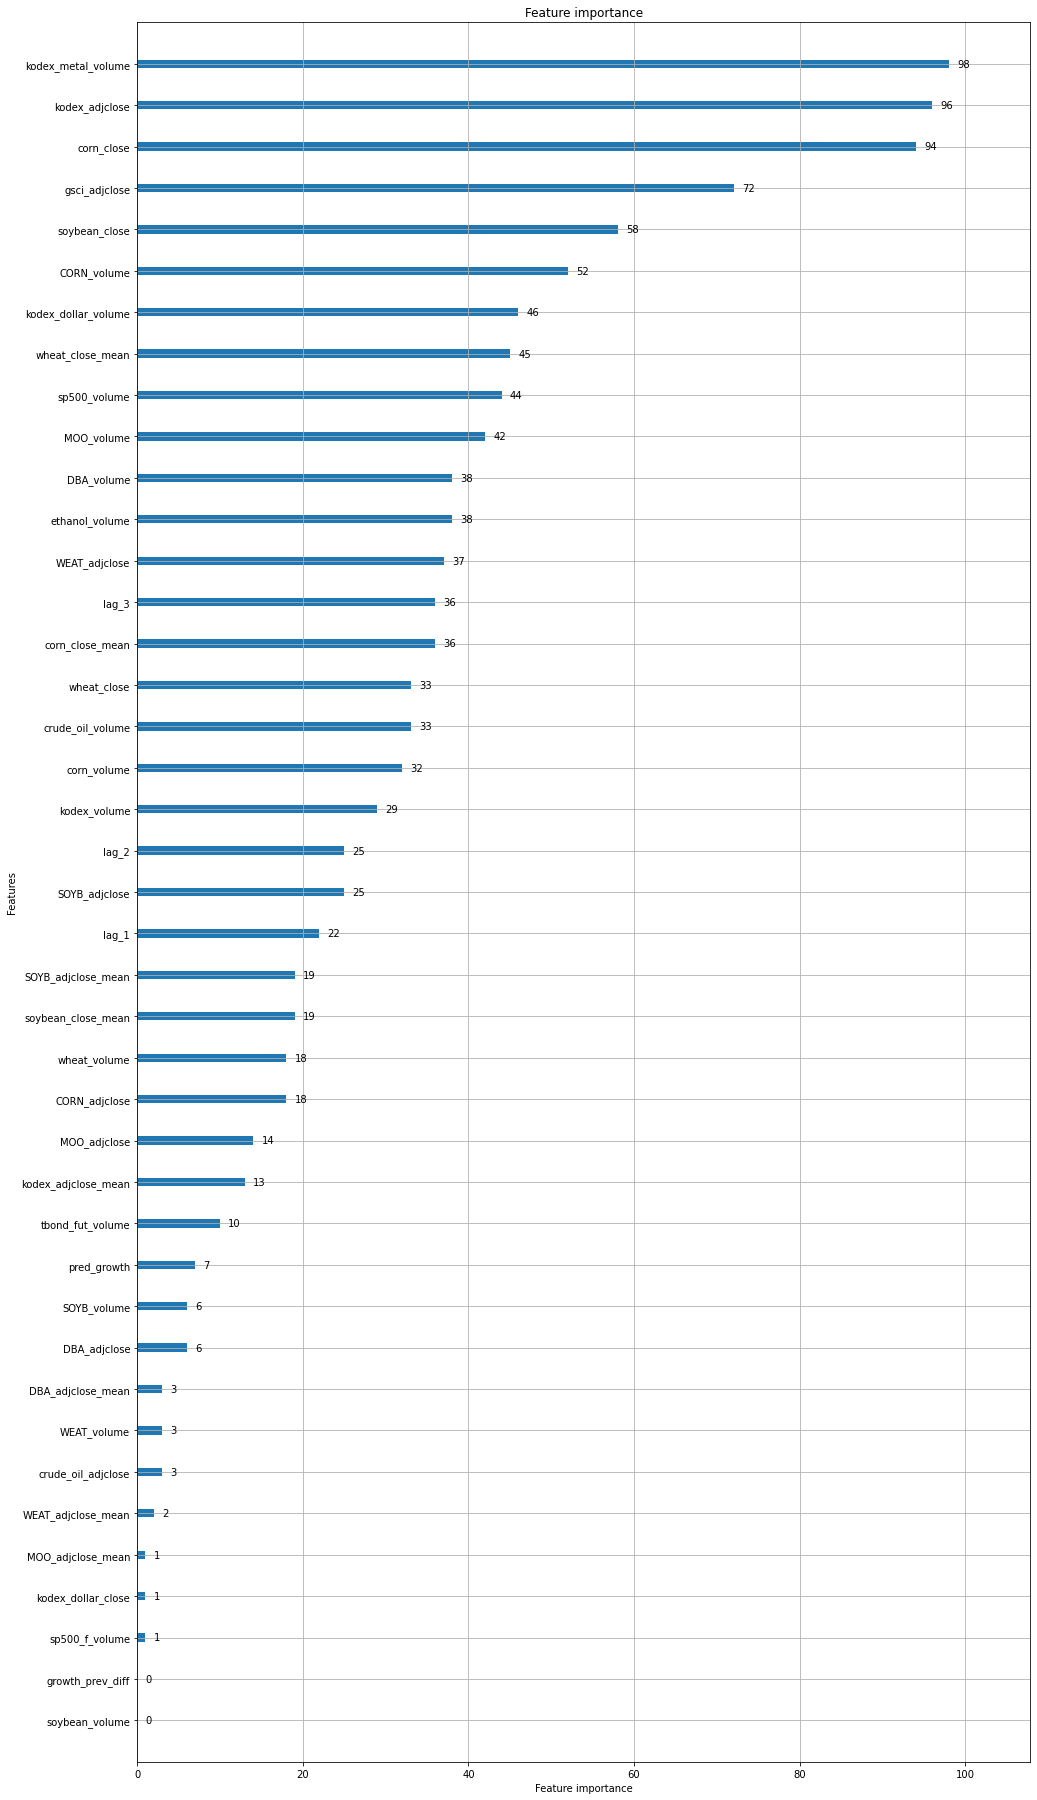

In [53]:
lgb_model2 = LGBMClassifier(n_estimators=500, learning_rate=0.02,
colsample_bytree= 0.799,
max_bin= 475,
max_depth= 16,
min_child_samples= 128,
min_child_weight= 13,
num_leaves= 33,
reg_alpha= 4.185,
reg_lambda= 3.793,
subsample= 0.678)

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod2 = lgb_model2.predict(X_test_mod2,axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

- 모델2도 스코어 차이 없음

In [132]:
'''
이제 예측한 결과를 바탕으로 벡테스팅 하기 위해, 자료를 넘겨주자.

'''
cond1 = (input_df_mod1.index >= '2021-01-01')
cond2 = (input_df_mod2.index >= '2021-01-01')

result_mod1 = X_test_mod1[['tiger_adjclose']]
result_mod2 = X_test_mod2[['kodex_adjclose']]

result_mod1['pred'] = preds_mod1
result_mod2['pred'] = preds_mod2

result_mod1.to_csv('result_mod1.csv')
result_mod2.to_csv('result_mod2.csv')

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_29544/642828643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_mod1['pred'] = preds_mod1
C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_29544/642828643.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_mod2['pred'] = preds_mod2


`피처 임포턴스 0인 컬럼 제거 전의 모델2에서 비트코인` 추가

In [133]:
from bayes_opt import BayesianOptimization

In [134]:
input_df_mod2 = pd.read_csv(DATA_PATH+'lag_df2.csv',index_col=0)

btc=pd.read_csv(DATA_PATH+'btc.csv',index_col=0)
btc=btc[['btc_close','btc_volume']]
btc=btc.astype(float)
btc.index=pd.to_datetime(btc.index)
input_df_mod2.index=pd.to_datetime(input_df_mod2.index)
input_df_mod2= input_df_mod2.join(btc)

df2_cols = [x for x in input_df_mod2.columns]
df2_cols.remove('actual_growth')
df2_cols.remove('pred_growth')
df2_cols.remove('growth_pred_error')
df2_cols.remove('growth_prev_diff')
df2_cols.remove('prev_growth')
df2_cols.remove('kodex_label')

def robust_scaling_kodex(df,cols):
    scaler = preprocessing.RobustScaler()
    normalized_data = scaler.fit_transform(df[cols])
    normalized_df = pd.DataFrame(normalized_data, columns=cols, index=df.index)
    return normalized_df.join(df[['actual_growth','pred_growth','prev_growth','growth_pred_error','growth_prev_diff','kodex_label']])

input_df_mod2 = robust_scaling_kodex(input_df_mod2,df2_cols)

input_df_mod2.drop(['actual_growth', 'prev_growth', 'tbond_fut_adjclose', 'sp500_adjclose_mean', 'CORN_adjclose_mean'],axis=1,inplace=True)



In [140]:


X_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'].drop(['kodex_label'],axis=1)
y_temp_mod2 = input_df_mod2[input_df_mod2.index <= '2020-12-31'][['kodex_label']]
X_train_mod2, X_valid_mod2, y_train_mod2, y_valid_mod2 = train_test_split(X_temp_mod2, y_temp_mod2, test_size=0.1, random_state=42)
X_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'].drop(['kodex_label'],axis=1)
y_test_mod2 = input_df_mod2[input_df_mod2.index > '2020-12-31'][['kodex_label']]

bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

def lgb_f1_eval_mod2(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model2 = LGBMClassifier(**params)
    lgb_model2.fit(X_train_mod2, y_train_mod2, eval_set=[(X_valid_mod2, y_valid_mod2)], eval_metric= 'f1', verbose= 100, 
                early_stopping_rounds= 25)
    test_pred = lgb_model2.predict(X_test_mod2)
    f1_mod2 = f1_score(y_test_mod2, test_pred)
    
    return f1_mod2

    # BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO_mod2 = BayesianOptimization(lgb_f1_eval_mod2,bayesian_params , random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO_mod2.maximize(init_points=5, n_iter=25)

target_list_mod2 = []
for result in lgbBO_mod2.res:
    target = result['target']
    target_list_mod2.append(target)
max_dict_mod2 = lgbBO_mod2.res[np.argmax(np.array(target_list_mod2))]

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.682272
[200]	valid_0's binary_logloss: 0.672626
[300]	valid_0's binary_logloss: 0.667135
Early stopping, best iteration is:
[316]	valid_0's binary_logloss: 0.666944
|  1        |  0.6543   |  0.6873   |  475.9    |  13.32    |  123.7    |  8.645    |  30.24    |  2.914    |  8.662    |  0.8006   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.686515
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.68647
|  2        |  0.6525   |  0.854    |  20.09    |  15.7     |  168.2    |  11.4     |  31.27    |  9.178    |  3.043    |  0.7624   |
Training until validation scores don't improve for 25 rounds

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.691355
|  3        |  0.0      |  0.716    |  152.7    |  12.12    |  36.5     |  15.32    |  38.65    |  22.81    |  7.852    |  0.5998   |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.691355
|  4        |  0.0      |  0.7571   |  300.3    |  6.465    |  125.4    |  9.356    |  26.6     |  47.44    |  9.656    |  0.9042   |
Training until validation scores don't improve for 25 rounds

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



[100]	valid_0's binary_logloss: 0.674886
[200]	valid_0's binary_logloss: 0.66898
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.668531
|  5        |  0.6525   |  0.6523   |  57.86    |  12.84    |  93.63    |  6.98     |  43.81    |  1.729    |  9.093    |  0.6294   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.683325
[200]	valid_0's binary_logloss: 0.676707
[300]	valid_0's binary_logloss: 0.673177
Early stopping, best iteration is:
[363]	valid_0's binary_logloss: 0.670982
|  6        |  0.645    |  0.8671   |  64.45    |  8.943    |  91.39    |  16.23    |  44.73    |  6.555    |  4.448    |  0.8666   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.66892
|  7        |  0.6525   |  1.0      |  500.0    |  16.0     |  10.0     |  1.0      |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.691355
|  8        |  0.0      |  0.5      |  10.0     |  16.0     |  60.16    |  50.0     |  64.0     |  50.0     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.687416
[200]	valid_0's binary_logloss: 0.680382
[300]	valid_0's binary_logloss: 0.675092
[400]	valid_0's binary_logloss: 0.666224
[500]	valid_0's binary_logloss: 0.66075
Did not meet early stopping. Best iteration is:
[499]	valid_0's binary_logloss: 0.660474
|  9        |  0.6484   |  1.0      |  90.07    |  6.0      |  164.9    |  1.0      |  62.5     |  0.01     |  0.001    |  1.0      |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.689011


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  10       |  0.6282   |  0.9689   |  94.69    |  7.03     |  165.2    |  2.821    |  61.6     |  2.906    |  2.077    |  0.9706   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.691355
|  11       |  0.0      |  1.0      |  500.0    |  6.0      |  72.96    |  50.0     |  64.0     |  50.0     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.687466
|  12       |  0.6525   |  0.5      |  483.0    |  16.0     |  200.0    |  1.0      |  24.0     |  0.01     |  1.27     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.66237
|  13       |  0.6525   |  0.5      |  426.4    |  16.0     |  10.0     |  1.0      |  24.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.682665
|  14       |  0.6264   |  1.0      |  69.2     |  6.0      |  200.0    |  50.0     |  24.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.688591
|  15       |  0.6453   |  1.0      |  423.9    |  16.0     |  200.0    |  50.0     |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.691355
|  16       |  0.0      |  0.5      |  424.5    |  16.0     |  200.0    |  1.0      |  24.0     |  50.0     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.688234
|  17       |  0.6453   |  1.0      |  500.0    |  6.0      |  200.0    |  50.0     |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.688283
|  18       |  0.6453   |  1.0      |  370.2    |  16.0     |  10.0     |  50.0     |  64.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.687247
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.685464
|  19       |  0.6525   |  0.5      |  52.68    |  6.0      |  146.6    |  50.0     |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.691355
|  20       |  0.0      |  0.5      |  381.5    |  16.0     |  10.0     |  1.0      |  64.0     |  50.0     |  10.0     |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.691355
|  21       |  0.0      |  0.5      |  65.92    |  6.0      |  147.8    |  1.0      |  24.0     |  50.0     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.68611
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.685572
|  22       |  0.6525   |  1.0      |  41.34    |  16.0     |  200.0    |  23.74    |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.688596
|  23       |  0.6453   |  1.0      |  476.7    |  16.0     |  166.2    |  50.0     |  24.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.68253
[200]	valid_0's binary_logloss: 0.679097
Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.677584
|  24       |  0.6573   |  1.0      |  10.0     |  16.0     |  200.0    |  50.0     |  24.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.689609
|  25       |  0.6525   |  1.0      |  500.0    |  16.0     |  163.3    |  1.0      |  64.0     |  0.01     |  10.0     |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.688232
|  26       |  0.6203   |  1.0      |  161.9    |  6.0      |  200.0    |  50.0     |  64.0     |  0.01     |  0.001    |  1.0      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.685521
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.684988
|  27       |  0.6525   |  0.5401   |  21.85    |  11.91    |  170.1    |  17.3     |  25.23    |  7.268    |  2.368    |  0.8803   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.688283
|  28       |  0.6453   |  1.0      |  307.7    |  6.0      |  10.0     |  50.0     |  24.0     |  0.01     |  0.001    |  0.5      |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.688283
|  29       |  0.6453   |  1.0      |  404.8    |  16.0     |  66.24    |  50.0     |  24.0     |  0.01     |  0.001    |  0.5      |
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.690072
|  30       |  0.6525   |  0.7802   |  91.86    |  6.934    |  166.2    |  3.548    |  63.87    |  3.714    |  7.161    |  0.6241   |


C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [141]:
max_dict_mod2['params']

{'colsample_bytree': 1.0,
 'max_bin': 10.0,
 'max_depth': 16.0,
 'min_child_samples': 200.0,
 'min_child_weight': 50.0,
 'num_leaves': 24.0,
 'reg_alpha': 0.01,
 'reg_lambda': 0.001,
 'subsample': 1.0}

C:\Users\heunj\anaconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 25 rounds
[100]	valid_0's binary_logloss: 0.68253
[200]	valid_0's binary_logloss: 0.679097
Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.677584
Model F1 Score :  0.6573033707865168


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

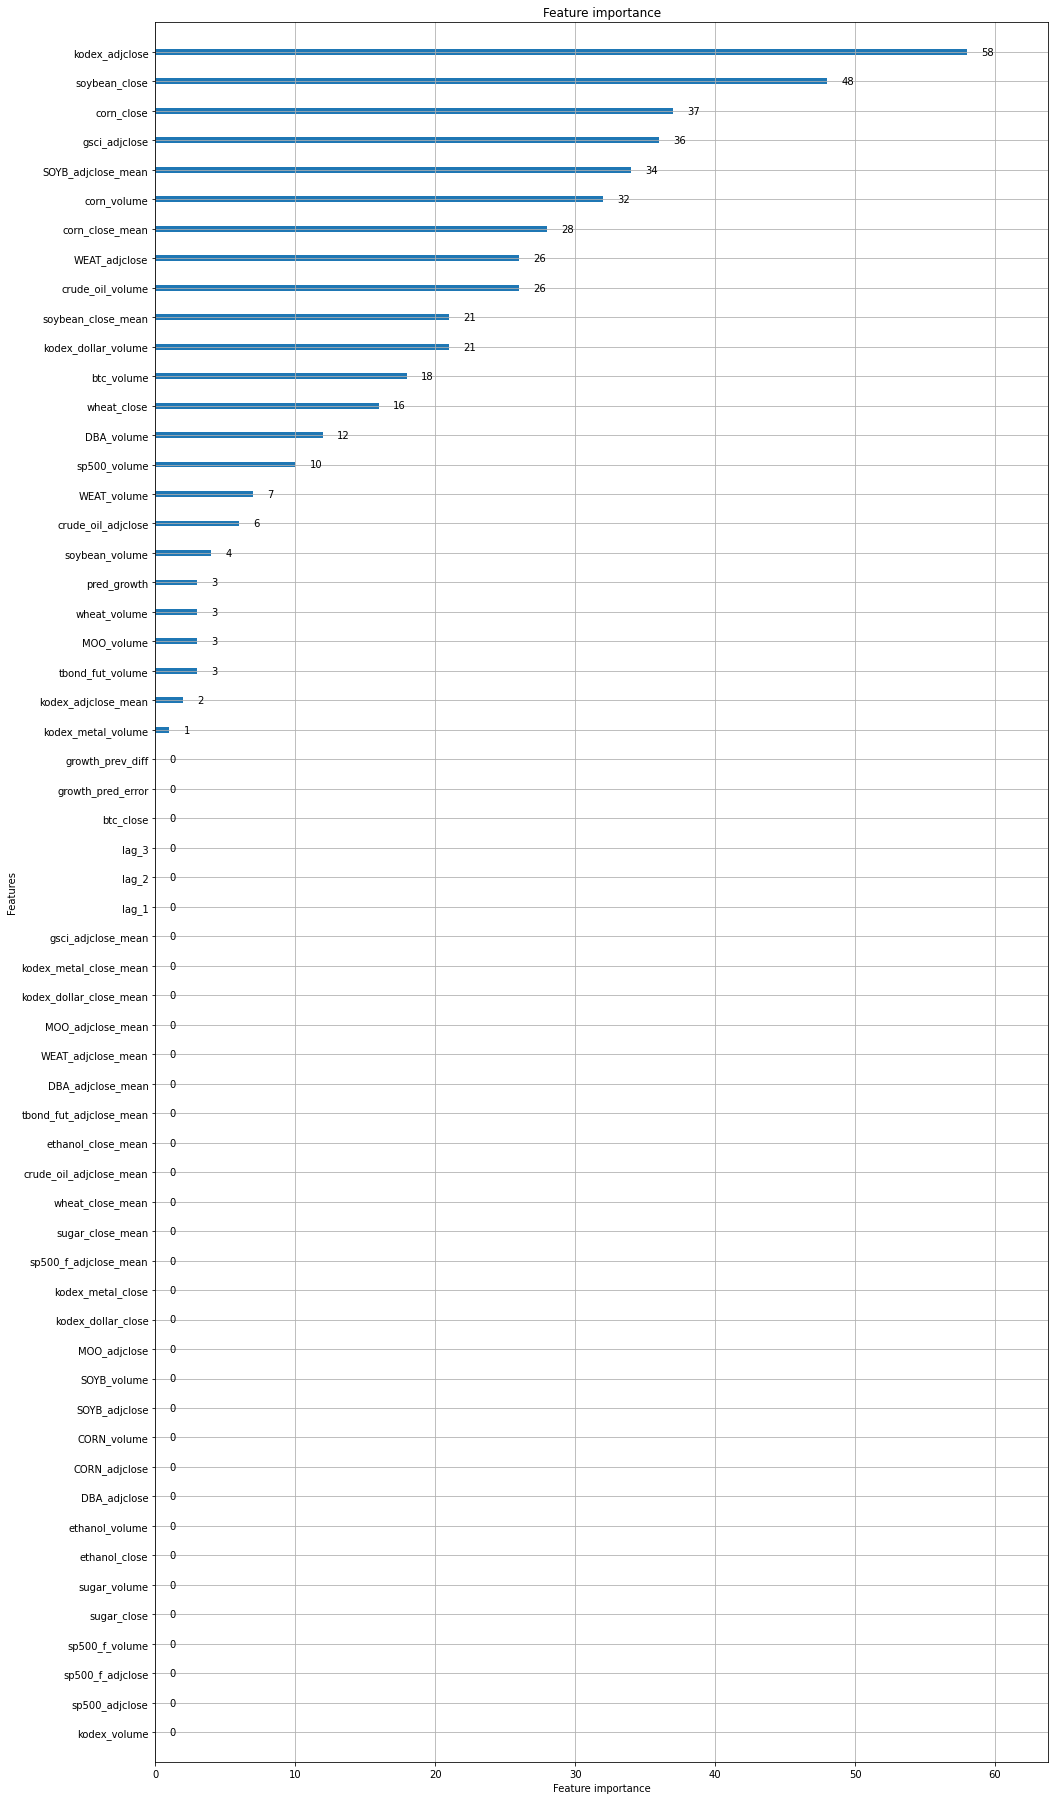

In [144]:
lgb_model2 = LGBMClassifier(n_estimators=500, learning_rate=0.02,
colsample_bytree= 1,
max_bin= 10,
max_depth= 16,
min_child_samples= 200,
min_child_weight= 50,
num_leaves= 24,
reg_alpha= 0.01,
reg_lambda= 0.001,
subsample= 1)

lgb_model2.fit(X_train_mod2, y_train_mod2,eval_set=[(X_valid_mod2, y_valid_mod2)],eval_metric= 'f1', verbose= 100, early_stopping_rounds= 25)
preds_mod2 = lgb_model2.predict(X_test_mod2,axis=1)

print("Model F1 Score : ",f1_score(y_test_mod2, preds_mod2))
plot_importance(lgb_model2, figsize=(16, 32),ignore_zero=False)

In [36]:
DATA_PATH='C:/'
tmp = pd.read_csv(DATA_PATH+'result_mod1.csv')

(tmp['pred'] != preds_mod1).sum()



0

In [29]:
len(preds_mod1)

375